# import libraries

In [39]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter
import time
from scipy import ndimage
from scipy.stats import chi2
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
from utility import *
import utility as utl
import LammpsPostProcess2nd as lp
import imp
imp.reload(lp)
imp.reload(utl)

<module 'utility' from '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/utility.py'>

# Parameters

In [2]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!

#--- uncomment if modified in 'submitPY.py'   
itime = int(os.environ.get('itime'))
indx = int(os.environ.get('indx'))

ValueError: not enough values to unpack (expected 2, got 1)

In [2]:
#--- comment out parameters if you pass them
#--- by arguments

#--- timestep
#
dlgr0 = 2.52 #--- 1st peak  in g(r)
dlgr = 4.0 #--- 2nd peak in g(r) !!!!!!!!!!
cutoff = 10.0*1    #--- cut-off radius for g(r)
NMAX = 1000 #0*1    #--- max. number of atoms included for the g(r) analysis
#
cutoff = 4.5 #--- neighbor list
#
TimeSeries = False
#
ReadStrsFromDump = False #--- don't change!
#
#--- if np.any(AssignYieldTime,AssignMaxDropTime,AssignFlowTime,TimeSeries) -> comment itime (here and above!)
AssignYieldTime = False #--- stress peak
AssignMaxDropTime = False #--- max drop
AssignFlowTime = False #--- flow stress
#
CompDisp = False
ShuffleDisp = False
CrltnFunctionUnstructured = False
#
PairCorrelationFunction = False
#
VorAnl = False
#
StrnAnalysis = False
#
DminAnalysis = False
#
ModuAnl = True
#
NeighList = False
#
CompFluc = False
#
Ovitos = True #--- don't change!
#
nevery = 8 #200 #8 #--- postproc. every n times
#
RemoteMachine = True #--- tex issue: don't run corresponding cells
#
ml = False; ReadDisc = False; WritDisc = True
#
# 'Co', 'Ni', 'Cr', 'Fe', 'Mn',,,,,,
#LatticeConstant = {1:58.933,2:58.690,3:51.960,4:55.847,5:54.940} #--- from library_CoNiCrFeMn.meam
#AtomicRadius = {1:1.35,2:1.35,3:1.4,4:1.4,5:1.4} #--- https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)
AtomicRadius = {1:1.25,2:1.25,3:1.28,4:1.27,5:1.26}
#ModuMismatch = {1:0.0119,2:0.0162,3:0.0426,5:0.0399,6:0.0303}
Gmodu={1:75.0, 2:76.0, 3:115.0, 4:82.0, 5:80.0} #---https://en.wikipedia.org/wiki/Elastic_properties_of_the_elements_(data_page)#Shear_modulus
#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0/'
#itime = 0

#--- stress files
#indx = 5
fileNamee = {0:'FeNi.txt', 
             1:'CoNiFe.txt', 
             2:'CoNiCrFe.txt',
             3:'CoCrFeMn.txt',
             4:'CoNiCrFeMn.txt',
             5:'Co5Cr2Fe40Mn27Ni26.txt',
             6:'CuZr.txt',
            }[indx]

#--- xyz and atom-wise stress files
fileName = '%s/%s'%(path,{
            0:'FeNi_glass.dump',
            1:'CoNiFe_glass.dump',
            2:'CoNiCrFe_glass.dump',
            3:'CoCrFeMn_glass.dump',
            4:'CoNiCrFeMn_glass.dump',
            5:'Co5Cr2Fe40Mn27Ni26_glass.dump',
            6:'dumpSheared.xyz'}
            [indx])#--- parse cords


In [3]:
#--- figure settings
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
DFset=(0.18,0.17,0.15,0.06,0.05)
FontSize = 19



## Dump File

In [4]:
#--- parse lammps data
#--- dump files
print('parsing %s'%fileName)
t0 = time.time()
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, 
                 columns = {'c_mystress[4]':'sxy'},
#                 columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'},
#                 columns = {'c_1[4]':'sxy'},
                )
print('duration=%s s'%(time.time()-t0))

parsing /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
duration=147.24647903442383 s


In [5]:
lmpData.coord_atoms_broken.keys()

dict_keys([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000, 1000000, 1010000, 1020000, 1030000, 1040000, 1050000, 1060000, 1070000, 1080000, 1090000, 1100000, 1110000, 1120000, 1130000, 1140000, 1150000, 1160000, 1170000, 1180000, 1190000, 1200000, 1210000, 12200

In [6]:
lmpData.coord_atoms_broken[0].head()

id  type        x        y         z  c_mystress[1]  c_mystress[2]  \
0   1     4  14.9445 -10.6741 -42.78180      -673841.0       620696.0   
1   2     2 -11.3083 -19.8201  -9.71689      -884160.0        70546.5   
2   3     1 -36.6012 -16.5765  11.12710      1071040.0      1953980.0   
3   4     2 -27.7480 -20.6086 -19.67470      -239511.0     -1226530.0   
4   5     2 -13.4647  19.5767  16.91930      -193637.0      -663106.0   

   c_mystress[3]       sxy  c_mystress[5]  c_mystress[6]  
0      -901386.0  544120.0      -879532.0      -169457.0  
1      -517176.0 -326479.0      -171561.0       667658.0  
2     -1022250.0   86649.9       668240.0       815182.0  
3      -349854.0 -817913.0       876769.0       453296.0  
4       -12542.3 -270661.0      -325333.0      -872719.0

# stress-strain curve

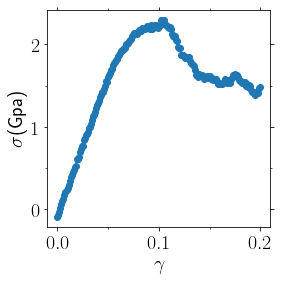

In [242]:
if not ReadStrsFromDump:
    try:
        stress = np.loadtxt('%s/%s'%(path,fileNamee) ) #--- stress input file
        strain = stress[:,0]
        Virial = stress[:,1]
        PltErr(strain,Virial,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               title=fileNamee[:-4]+'.png'
              )
        #
        np.savetxt('loadCurve.txt',np.c_[np.array(strain), Virial],header='gamma\tsigma')
    except:
        ReadStrsFromDump = True
        
if ReadStrsFromDump:
    times = lmpData.coord_atoms_broken.keys()
    try: 

        func_sxy = lambda x: np.sum(lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                             GetVolume(lmpData,x)
        Virial = np.array(list(map(func_sxy,times)))*1.0e-04
        strainDump = np.array(list(map(lambda x: GetStrain(lmpData,x,0),times)))
        #
        PltErr(strainDump,Virial,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               title=fileNamee[:-4]+'.png'
              )
        #
        np.savetxt('loadCurve.txt',np.c_[strainDump, Virial],header='gamma\tsigma')

    except AttributeError: #--- dump file has no stress entry! 
        traceback.print_exc()
        ReadStrsFromDump = False



## multiple systems

In [18]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                            'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/Run2/loadCurve.txt'%GlassType)
#        gmodu = np.loadtxt('StrsStrn%s/Run2/ShearModulus.txt'%GlassType)[1]
    #    sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
    #    assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        nfreq = np.max([1,int(len(sarr)/100)])
        ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
#         if unrescaled:
#             gmodu = 1
    #
#        ax.plot(xdata,ydata/gmodu,'-',color=color)#, label = GlassType)
        ax.plot(xdata,ydata,
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/10),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## multiple Realizations

In [19]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=20)
    ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         '0','1','2'
                                        ],markers, colors, fillstyles )):

        try:
            gglass=['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26'][3]
            sarr  = np.loadtxt('d2min%s/Run%s/loadCurve.txt'%(gglass, GlassType) )
            #--- fliter
            nfreq = np.max([1,int(len(sarr)/1000)])
            ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
            xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
        #
            ax.plot(xdata,ydata,
                    markersize=10,
                    color=color,
                    marker=marker,
                    markerfacecolor=fillstyle,
                    markeredgecolor='black' if not fillstyle else None,
                    markevery=int(len(xdata)/10),
                    label = '%s'%GlassType)
        except:
            continue
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## find stress peak and corresponding strain
### Fit a spline

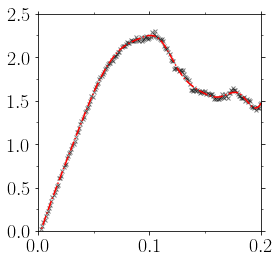

In [243]:
if ReadStrsFromDump:
    strain = strainDump

x, y = np.array(strain), np.array(Virial)
#--- training points
transfrm = ReturnShapeFunc(x,13)
    
#--- train
reg = TrainModel(transfrm,np.c_[y])

#--- prediction
y_pred = reg.predict( transfrm )
    

#--- validate
#mse = Validate(reg, strain,np.c_[y])

#--- yield stress
try:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress(x,y_pred)
except:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress2nd(x,y_pred)

#--- write on the disk
np.savetxt('NegativeModulus.txt',np.c_[em,-dsm],header='Strain\tModulus')
np.savetxt('ShearModulus.txt',np.c_[0,gmodu],header='Strain\tModulus')

#--- Plot
attrs={ 'alpha':0.5,
        'fmt':'x',
        'markersize':4,
        'color':'C0',
         'markerfacecolor':'white',
         'markeredgecolor':'black',
         'markevery':int(len(x)/128),
       
      }
ax=None   
kwargs = {
        'borderwidth' : 0.1,
       'xlim':(0,0.2),
       'ylim':(0,2.5),
        'title':'hminIllustration.png',
         }
#
ax = PltErr(x,y, 
       yerr=None, 
       attrs = attrs,
       Plot = False,
       xstr=r'$\gamma$',
       ystr=r'$\sigma$(Gpa)',
      )
#
PltErr(x,y_pred, 
       yerr=None, 
       attrs = {'fmt':'-.r'},
       Plot = False,
       ax = ax,
       **kwargs
      )
if AssignYieldTime:
    PltErr([ey,ey], [ax.axis()[2],sy], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = True,
           ax = ax,
           **kwargs
          )    
elif AssignMaxDropTime:
    PltErr(em, sm, 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':8},
           Plot = True,
           ax = ax,
           **kwargs
          )    
elif AssignFlowTime:
    PltErr([ef,ef], [ax.axis()[2],sf], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = True,
           ax = ax,
           **kwargs
          )    


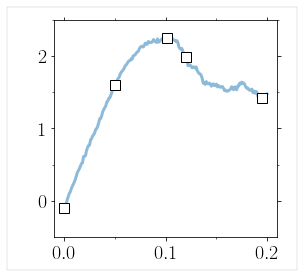

In [244]:
if not RemoteMachine:
    #--- Plot
    attrs={ 'alpha':0.5,
            'fmt':'-',
    #        'markersize':4,
            'color':'C0',
             'markerfacecolor':'white',
             'markeredgecolor':'black',
             'markevery':int(len(x)/128),
             'linewidth':3,

          }
    ax=None   
    kwargs = {
            'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
           'xlim':(-0.01,0.21),
           'ylim':(-0.5,2.5),
            'title':'loadCurve.png',
             }
    #
    ax = PltErr(x,y, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
          )
    #
    PltErr([0.0,0.05,ey,em,ef], [y[0],y[x>=0.05][0],sy,sm,sf]
           , 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':10,
                    'markerfacecolor':'white',
                    'markeredgecolor':'black'},
           Plot = True,
           ax = ax,
           **kwargs
          )

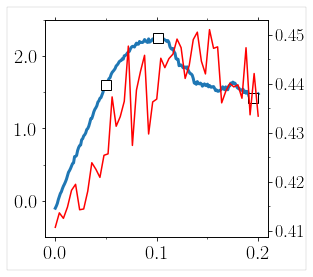

In [248]:
if not RemoteMachine:
    #--- Plot
    attrs={ 
#            'alpha':0.5,
            'fmt':'-',
    #        'markersize':4,
            'color':'C0',
             'markerfacecolor':'white',
             'markeredgecolor':'black',
             'markevery':int(len(x)/128),
             'linewidth':3,

          }
    ax=None   
    kwargs = {
#            'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
           'xlim':(-0.01,0.21),
           'ylim':(-0.5,2.5),
             }
    #----------------
    #--- load curve
    #----------------
    ax = PltErr(x,y, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
           yticks = (['0.0','1.0','2.0'],['0.0','1.0','2.0']),
          )
    #----------------
    #--- symbols
    #----------------
    ax = PltErr([0.05,ey,ef], [y[x>=0.05][0],sy,sf]
           , 
           yerr=None, 
            attrs = {'fmt':'s','color':'black','markersize':10,
                     'markerfacecolor':'white',
                     'markeredgecolor':'black'},
           Plot = False,
           ax = ax,
           **kwargs
          )
    #---
    kwargs = {                       

            'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
           'xlim':(-0.01,0.21),
#           'ylim':(0.06,0.2),
            'title':'ModuAnl/loadCurve.png',
            'fontsize':18,
#             'yticks':(['0.06','0.13','0.20'],['0.06','0.13','0.20']),
             }
    #----------------
    #--- probablility
    #----------------
    PltErr(ax_s.lines[0].get_xdata(),ax_s.lines[0].get_ydata(),
       yerr=None, 
        attrs = {'fmt':'-','color':'red','markersize':10,
                 'markerfacecolor':'white',
                 'markeredgecolor':'black'},
       Plot = True,
       ax = ax,
       twinx = True,
       **kwargs
      )

    


In [246]:
ax_s.lines[0].get_xdata()

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  ])

In [10]:
# import statsmodels
# import statsmodels.api as sm
# ols = sm.OLS(np.c_[y], transform)
# ols_result = ols.fit()
# ols_result.summary()

In [329]:
times = lmpData.coord_atoms_broken.keys()
times = np.array(sorted(times))
if AssignYieldTime:
    itime = times[strainDump>=ey][0]
    print('itime(peak)=%s'%itime)    
elif AssignMaxDropTime:
    itime = times[strainDump>=em][0]
    print('itime(max. drop)=%s'%itime)
elif AssignFlowTime:
    itime = times[strainDump>=ef][0]
    print('itime(flow)=%s'%itime)

### test error vs. complexity

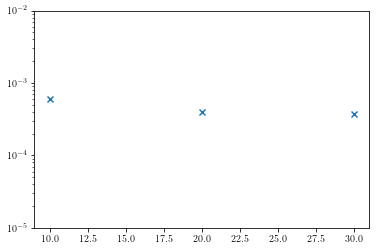

In [22]:
# if AssignYieldTime or AssignMaxDropTime or AssignFlowTime:
#     mse = Validate(reg, strain,np.c_[y])
#     try:
#         keys=mse.keys()
#         plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#         plt.yscale('log')
#     #    plt.xscale('log')
#         plt.ylim(1e-5,1e-2)
#         plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#         plt.show()
#     except:
#         pass

## mismatch parameter 

In [281]:
def GetMismatch(lmpData,itime,AtomicRadius):
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    df = pd.DataFrame(atoms.__dict__)
    #size = list(map(LatticeConstant.get,list(map(int,df['type'].tolist()))))
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])

    return df['size'].std()/df['size'].mean()

delta = GetMismatch(lmpData,0,AtomicRadius)
delta_g = GetMismatch(lmpData,0,Gmodu)
       
       
np.savetxt('YieldDelta.txt',np.c_[delta,sy],header='AtomMismatch\tYieldStress')
np.savetxt('ModuMismatch.txt',[delta_g],header='ModuMismatch')



NameError: name 'sy' is not defined

### multiple frames

In [24]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    Xdata = []
    Ydata = []
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel('$\delta$',fontsize=20)
#     ax.set_ylabel('$\sigma_y$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = MultipleFrames2nd(path='YieldStrs%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        #--- fliter
        xdata = sarr[:,0]
        ydata = sarr[:,1]
        Xdata += list(xdata[~np.isnan(xdata)])
        Ydata += list(ydata[~np.isnan(ydata)])
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%GlassType)

    #
#    ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('YieldDelta.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    np.savetxt('YieldDelta.txt',np.c_[Xdata,Ydata],header='Mismatch\tYieldStrs')
    plt.show()

## Avalanche Size

564991 [-1.02496576]
117648 [-0.02073347]


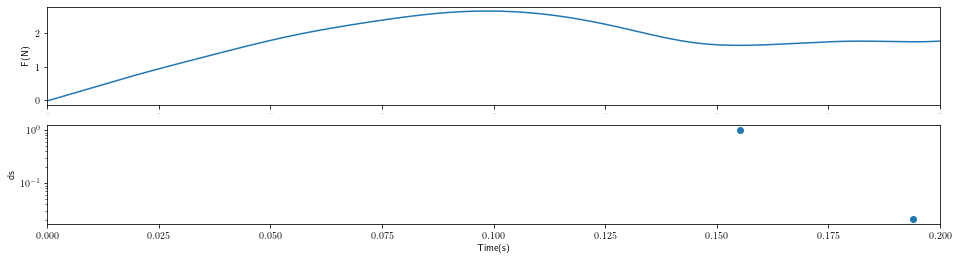

In [25]:
if ReadStrsFromDump:
    strain = strainDump
df = AvalancheSize(strain, y_pred) #
esmax,dsmax=df.sort_values(by='ds',ascending=False).iloc[0][['t_end','ds']]
np.savetxt('StrsDrop.txt',np.c_[esmax,dsmax],header='StressDrop')

# #--- plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(211)
ax.set_xlim(strain.min(),strain.max())
ax.tick_params(axis='x',labelsize=0)
ax.set_ylabel('F(N)')
#
ax.plot(strain, y_pred,'-')
#
ax = fig.add_subplot(212)
ax.set_ylabel('ds')
ax.set_xlabel('Time(s)')
ax.set_yscale('log')
ax.set_xlim(strain.min(),strain.max())
#
ax.scatter(df['t_end'],df['ds'])
#
plt.show()

### Correlations with band width

In [26]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    # ax.set_xlabel('$w(A^o)$',fontsize=20)
    # ax.set_ylabel('$\Delta\sigma$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                         'CoNiCrFe',
                                         'CoCrFeMn',
                                         'CoNiCrFeMn',
                                         'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles)):

        sarr_StrsDrop  = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='StrsDrop.txt',ncols=2)
        sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        ydata = sarr_StrsDrop[:,1] #--- first 2nd col is stress drop
        xdata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        xdata = xdata[~np.isnan(xdata)]
        ydata = ydata[indices]
        assert xdata.shape == ydata.shape
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%GlassType)

    #
    #ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('StrsDropAndWidth.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### (negative) modulus and band width

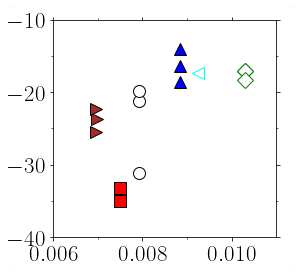

In [69]:
if not RemoteMachine:
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$h_{min}$',
                        title='SoftModuAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(-40.0,-10.0),
#                        legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

### correlation coefficient

In [29]:
def zscore(x):
    y = np.copy(x)
    y-=np.mean(y)
    y/=np.std(y)
    return y

if not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel('$w(A^o)$',fontsize=16)
    ax.set_ylabel('$H$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    x = zscore(Xdata)
    y = zscore(Ydata)
    ax.scatter(x,y,
                   marker='x',s=50,
    #               label=GlassType
              )

    print(np.sum(x*y)/len(x))

# Displacements


In [31]:
if CompDisp:
    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- wrap coordinates
    wrap = lp.Wrap( atoms, box )
    wrap.WrapCoord()
    wrap.Set( atoms ) #--- atoms: set wrapped xyz     

    #--- print actual xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #              open( 'xyz_actual.xyz','w'), 
    #              footer = 'ITIME=%s'%itime,
    #              attr_list=['id','type','x','y','z'])

    #--- map to square box
    mapp = lp.Map( atoms, box ) 
    mapp.ChangeBasis()
    mapp.Set( atoms ) #--- atoms: add mapped xyz

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #             open( 'xyz_mapped.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- include copies
    copy = lp.Copy( atoms, box )
    copy.FullCopies()
    xatoms = copy.Get()

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(xatoms.__dict__), 
    #             open( 'xyz_full.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- compute displacements
    #--- need attributes for the reference state
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    wrap = lp.Wrap( atoms0, box0 )
    wrap.WrapCoord()
    wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
    mapp = lp.Map( atoms0, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( atoms0 ) #--- atoms: add mapped xyz
    copy = lp.Copy( atoms0, box0 )
    copy.FullCopies()
    xatoms0 = copy.Get()
    #
    cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
    cdisp.SetWrapped() 
    uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
    #
    pd.DataFrame(uatoms.__dict__).head()

In [32]:
# #--- shuffled displacements
if CompDisp and ShuffleDisp:
    xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
    np.random.shuffle(xrand)
    junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
           uatoms.zm]
    cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
    #np.c_[junk,xrand]
    uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

## Print

In [33]:
#--- get a chunk
# cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
# indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
#                                   epsilon = 0.0, mode = 'isotropic' )


# PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','x','y','z','dx','dy','dz'] )

# Neighbor list

In [494]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass

    #--- subset of timesteps
#    frames = GetFrames(lmpData,nevery=nevery)
    frames = utl.GetFrames(lmpData,times=[ itime ] )

    !ovitos OvitosCna.py $fileName neighList.xyz $frames 4 $cutoff

InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=1/201


In [319]:
#NeighList=True
#nevery=200

In [495]:
if NeighList:
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)

In [496]:
lmpNeigh.coord_atoms_broken[itime].head()

id  type        J  Jtype      DIST        DX       DY        DZ  \
0   1     4  23048.0    5.0  2.737616  1.747700  0.19000 -2.098568   
1   1     4  38733.0    4.0  2.542341  2.358799  0.89626  0.310299   
2   1     4   6382.0    4.0  3.046923 -2.713800 -1.38420 -0.054901   
3   1     4  39313.0    4.0  2.373153 -1.194800 -0.35730 -2.019070   
4   1     4   1837.0    4.0  2.659663 -1.251400 -0.50270  2.292400   

   PBC_SHIFT_X  PBC_SHIFT_Y  PBC_SHIFT_Z  
0          0.0          0.0         -1.0  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0         -1.0  
4          0.0          0.0          0.0

#  Pair correlation function

In [34]:
# if PairCorrelationFunction and not Ovitos:
#     d2min = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#     thresh=np.log10(thresh[itime])
#     cutoff=20.0/2
#     NMAX=10000*4
#     filtr = np.log10(d2min.d2min)>thresh


#     rdf = lp.ComputeRdf(  atoms, box, 
#                        cutoff = cutoff, NMAX = NMAX)

#     rdf.Distance(WRAP = True, FilterCenter = filtr)
#     rdf.PairCrltn( nbins = 100, bins=np.linspace(2.0,cutoff,100) )
#     bin_edges, hist, err = rdf.Get()

#     #--- plot
#     plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    
#     #---
#     np.savetxt('grGood95.txt',np.c_[bin_edges,hist,err],header='r\tg(r)\terr', fmt='%s')
#     plt.show()

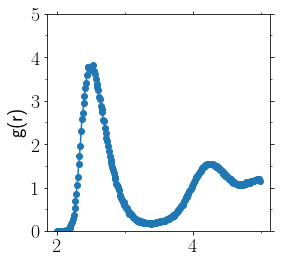

In [249]:
if PairCorrelationFunction:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn(  
                  bins=np.linspace(2.0,cutoff,250), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()

    #--- print
    np.savetxt('gr.txt',np.c_[bin_edges, hist, err],header='r\tg(r)\terr')
    #--- plot
    #plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

    PltErr(bin_edges,hist,err,
          ylim=[0,5],
           ystr='g(r)',
           title='gr.png'
          )

In [227]:
#PairCorrelationFunction=True

## 1st peak evolution

In [66]:
def GetFirstPeak(lmpData,lmpNeigh,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]
    #
    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 250, 
                  bins=np.linspace(2.0,cutoff,250), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()
    return hist.max()
    
if PairCorrelationFunction:
    #--- 
    times = list(lmpNeigh.coord_atoms_broken.keys())
    times.sort()
    #---
    
    #
    ydata = np.array(list(map(lambda x:GetFirstPeak(lmpData,lmpNeigh,x),times)))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('gr_peak_gamma.txt',np.c_[xdata,ydata],header='gamma\td2min')


### multiple frames

error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiFe/Run0/gr_peak_gamma.txt


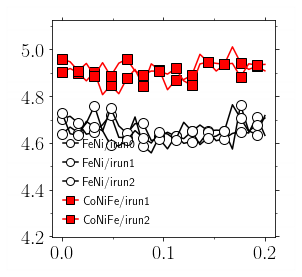

In [228]:
if not RemoteMachine:
    PlotPaperVersion(0,7,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='gr_peak_gamma.png',
#                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

## Multiple Systems

modify path!
modify path!
modify path!
modify path!
modify path!
modify path!


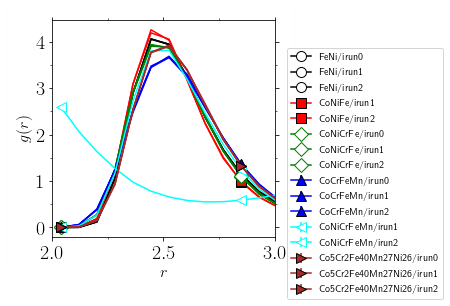

In [80]:
if not RemoteMachine:    
    
    PlotPaperVersion(0,0,
                        xlabel=r'$r$',
                        ylabel=r'$g(r)$',
                        title='gr_itime0_inset.png',
                        xlim=(2,3),#(0,10),
                    )

## ovito output

In [35]:
# try:
#     sfile = open('../testRuns/glassFeNi/Run0/FeNi_gr.xyz') #--- run testRuns2nd.py
#     gr={}
#     while True:
#         sfile.readline()
#         iitime=int(sfile.readline().split()[0])
# #        print(iitime)
#         sfile.readline()
#         nrow=int(sfile.readline().split()[0])
#         sfile.readline()
#         gr[iitime] = np.array([list(map(float,sfile.readline().split())) for i in range(nrow)])
# except:
# #    traceback.print_exc()
#     pass


## Plot

In [36]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlim(2,3)
    
#    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for strain, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        '0.0','0.2'
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        iitime = int(float(strain)*2000000/0.2)
        print(iitime)
        #--- fliter
        data  = gr[iitime]
        ydata = data[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = data[0::nfreq,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,'-',color=color)#, label = GlassType)
        ax.plot(xdata[-1],ydata[-1],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%strain)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('CrysFrac.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## plot gr good vs bad

In [37]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e-2,1e1)
    ax.set_xlim(0,10)

    ax.set_yscale('log')
    #
    PutMinorTicks(ax, LOGY=True)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    ydata = {}
    xdata = {}
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Out','In','Diff'
#                                        '5','95','QuantDiff'
                                         ('Good','Co5Cr2Fe40Mn27Ni26'),('Bad','CoNiCrFe'),('Diff','Difference')
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        sarr  = np.loadtxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/gr%s95.txt'%GlassType[0])
        #--- fliter
        ydata[ indx ] = sarr[:,1] #--- first 2nd col is stress drop
        xdata[ indx ] = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata[ indx ],ydata[ indx ],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata[ indx ])/5),
                label = '%s'%GlassType[1])
    #
    ax.legend(frameon=False, fontsize=12,loc=1)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('grD2min.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

In [220]:
#np.savetxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/grDiff95.txt',np.c_[xdata[0],ydata[1]-ydata[0]])

# D2min

In [520]:
os.system('mkdir D2minAnl')

mkdir: 

256

D2minAnl: File exists


## partition the space, make fits, and compute squared errors 

In [521]:
#fileName='/Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump'
#fileName='/Users/Home/Desktop/Tmp/txt/CoNiCrFe_glass.dump'
#nevery=1
#itime=2000000 #1600000 #1300000 #1000000 #700000
#itime=10000
#DminAnalysis=True

In [522]:
if DminAnalysis and not Ovitos:
    #--- Create "Atoms" object with dx,x attributes and
    #--- atoms within the original box
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.0, mode = 'isotropic' )
    #--- filter the full copy
    atomd = lp.Atoms(**pd.DataFrame(uatoms.__dict__)[indices].to_dict(orient='list'))
    #
    d2min = lp.ComputeD2min(atomd, box0, dlgr)
    d2min.Partition()
    d2min.D2min()
#    pdb.set_trace()
    d2min = d2min.Get(attrs=['id','type','x','y','z','xm','ym','zm','d2min'])
    #
    pd.DataFrame(d2min.__dict__).head()


## Run Ovitos

In [634]:
#--- input: dump file output: d2min.xyz
if DminAnalysis and Ovitos:
    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease it!'
    try:
        os.system('rm D2minAnl/d2min.xyz')
    except:
        pass
    
    GetTimeStep = lambda x: list(lmpData.coord_atoms_broken.keys())[x]
    #--- set parameters
    use_frame_offset = True #--- set it to False if reference frame = 0
    frame_offset = -1
#    reference_frame = 1
    frames = [100] #GetFrames(lmpData,nevery=100) #times=[1000000,2000000])

    
    !ovitos OvitosCna.py $fileName D2minAnl/d2min.xyz $frames 2 $fileName $use_frame_offset $frame_offset $reference_frame 


rm: D2minAnl/d2min.xyz: No such file or directory


InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=100/201
frame=200/201
Traceback (most recent call last):
  File "OvitosCna.py", line 185, in <module>
    every_nth_frame = 100, #nevery,
  File "/Applications/Ovito.app/Contents/MacOS/Ovito.App/Contents/MacOS/../Resources/python/ovito/io/__init__.py", line 295, in export_file
    if not node.wait(time = time):
  File "/Applications/Ovito.app/Contents/MacOS/Ovito.App/Contents/MacOS/../Resources/python/ovito/__init__.py", line 173, in _ObjectNode_wait
    raise RuntimeError("Data pipeline evaluation failed with the following error: %s" % state.status.text)
RuntimeError: Data pipeline evaluation failed with the following error: Requested reference frame -1 is out of range.
ERROR: The Python script 'OvitosCna.py' has exited with an error.


In [614]:
itime = GetTimeStep(reference_frame)
frames

array([  0, 100, 200])

In [577]:
#--- read from d2min.xyz
if DminAnalysis and Ovitos:
    lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

In [578]:
lmpDmin.coord_atoms_broken.keys()

dict_keys([0, 1000000, 2000000])

## PDF

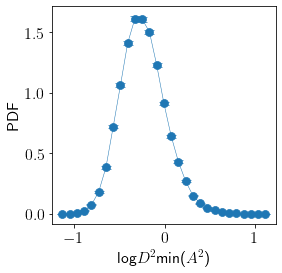

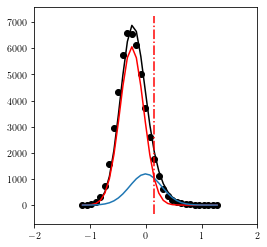

mu_divide= 0.15142014104755694


In [420]:
import utility as utl

if DminAnalysis and Ovitos:
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )

    #--- filter
#     d2min = lp.Atoms( **FilterDataFrame(pd.DataFrame(d2min.__dict__),
#                     column='d2min',
#                     limits =(1.0e-3,np.max(d2min.d2min))).to_dict(orient='series'))
                   
    utl.PdfD2min( d2min, 
              #times = [0,2000000],
#              times=[itime],#list(lmpDmin.coord_atoms_broken.keys()),     
              Plott = True,
             Limit=(-3,np.max(np.log10(d2min.d2min)))
             )
    
    thresh, ratio, junk = gaussian_mixture(
                                     d2min.d2min,
#                                     times = list(d2min.keys()), 
                                     PLOT = True,
                                 )
    mu_divide = np.log10(thresh)
    print('mu_divide=',mu_divide)
        #--- save
#     strn = GetStrain(lmpDmin, 
#                      times = [itime], #list(lmpDmin.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#     np.savetxt('varD2minGamma.txt',
#                np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#                header='gamma\tratio')


In [466]:
help(PltErr)

Help on function PltErr in module utility:

PltErr(xdata, ydata, yerr=None, xstr='', ystr='', Plot=True, **kwargs)



### mean & variance 

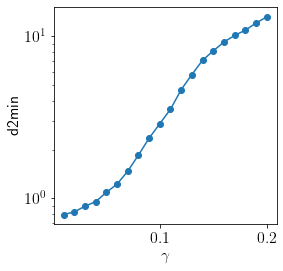

In [148]:
if DminAnalysis and Ovitos:
    #--- lambda function
    GetMeanD2min = lambda x: lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ).d2min.mean()
    
    #--- 
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)
    #
    ydata = np.array(list(map(GetMeanD2min,times)))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('d2min_gamma.txt',np.c_[xdata,ydata],header='gamma\td2min')
    #--- plot
    PltErr(xdata,
           ydata,#/xdata**2,
           0*ydata,
#      ylim=[0,5],
       ystr='d2min',
       xstr='$\gamma$',
       yscale='log',
#       xscale='log',
       title='dmin_gamma.png'
      )

#### multiple realizations

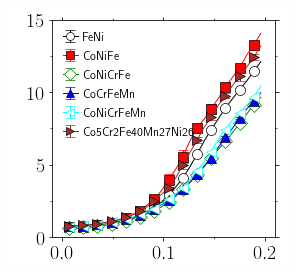

In [32]:
if not RemoteMachine:
    PlotPaperVersion(2,2,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='dmin_gamma.png',
                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = True,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

### multiple systems

In [46]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                          'FeNi', #0,1,2
#                                           'CoNiFe', #0,2
                                             'CoNiCrFe/Run2', #0,1,2  ## bad 7
#                                             'CoCrFeMn', #0,1,2
#                                             'CoNiCrFeMn', #1,2 ##
                                            'Co5Cr5Fe40Mn27Ni26/Run0'# 0,1,2 # good 13
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/D2minGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=6*4,
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Interpolation

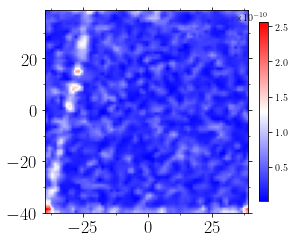

In [579]:
if DminAnalysis:
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    PlotAttrs = {
                'zscore' : False,
#                'scale' : 'log',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
#                'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
                'colorbar':True,
                'labels' : True,
#                'vmin':-0.5,
#                'vmax':+2.1,
                'fontsize':18,
                }
    junk, junk, d2intrp = Intrp(atom, box0,
                    attr = 'd2min',
                    Plot = True,
                    title='DminAnalysis/map_d2min.png',
                    **PlotAttrs
                    )

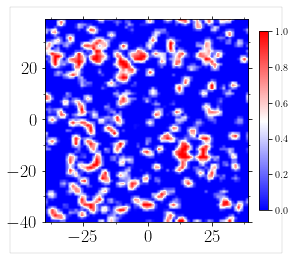

In [448]:
atom.tmp = np.log10(d2min.d2min) >= 0

PlotAttrs = {
            'zscore' : False,
#            'scale' : 'log',
            'xlabel' : '', #r'$x$(\r{A})', 
            'ylabel' : '', #r'$y$(\r{A})',
            'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
            'colorbar':True,
            'labels' : True,
#             'vmin':-0.5,
#             'vmax':+2.1,
            'fontsize':18,
            }

    
junk, junk, junk=Intrp(atom, box0,
                    attr = 'tmp',
                    Plot = True,
                    title='DminAnalysis/map_d2min.png',
                    **PlotAttrs
                    )

### time evolution

itime=1000000,gamma=0.10


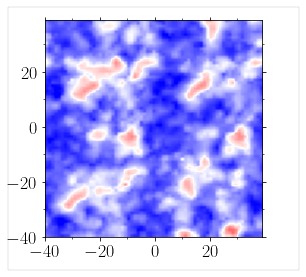

itime=2000000,gamma=0.20


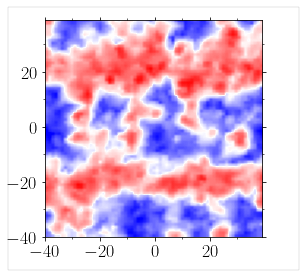

In [96]:
if not RemoteMachine:
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    for itimee in np.array([0,100,200])*10000: #times[0::10]:
        if itimee == 0:
            continue
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%3.2f'%(itimee,GetStrain(lmpData, itimee, 0 )))
        atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='series') )
        #---
        junk, junk, d2intrp = Intrp(atom, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='DminAnalysis/map_d2min_%s.png'%itimee,
                        **PlotAttrs                   
                                   )

### Print Ovito output

In [22]:
if not RemoteMachine:
    #--- print 
    file_name = 'd2min.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass



    # PrintOvito( pd.DataFrame(d2intrp.__dict__), 
    #             open(file_name,'a'), 
    #             footer = 'ITIME=%s'%itime,
    # #                attr_list=['id','type','xm','ym','zm','d2min'],
    #             attr_list=['x','y','z','d2min'] 
    #           )
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()

    for itimee in times: #=2000000
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%2.1e'%(itimee,GetStrain(lmpData, itimee, 0 )))
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='series') )

                #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        PrintOvito( pd.DataFrame(d2min.__dict__), 
                    open(file_name,'a'), 
                    footer = 'ITIME=%s'%itimee,
        #                attr_list=['id','type','xm','ym','zm','d2min'],
                    attr_list=['id','type','xm','ym','zm','d2min'] 
                  )

        # #--- current frame
        # d2minList=pd.DataFrame(d2min.__dict__).sort_values(by='id', ascending=True, inplace=False)['d2min']
        # df = pd.DataFrame(atoms.__dict__).sort_values(by='id', ascending=True, inplace=False)
        # #attrs = 
        # d2min2 = lp.Compute( atoms, box )
        # d2min2.Set(np.c_[df,d2minList],attrs=list(df.keys()) + ['d2min'])
        # attrs = ['id','type','x','y','z','d2min']
        # d2min2 = pd.DataFrame(np.c_[list(map(d2min2.__dict__.get,attrs))].T, columns = attrs )
        # PrintOvito( d2min2, 
        #             open(file_name,'a'), 
        #             footer = 'ITIME=%s'%itime,
        #             attr_list=['id','type','x','y','z','d2min'] )

    # if DminAnalysis:# and not Ovitos:
    #     PlotOvito( d2intrp,
    #               itime
    #              )

itime=0,gamma=0.00
itime=10000,gamma=0.00
itime=20000,gamma=0.00
itime=30000,gamma=0.00
itime=40000,gamma=0.00
itime=50000,gamma=0.01
itime=60000,gamma=0.01
itime=70000,gamma=0.01
itime=80000,gamma=0.01
itime=90000,gamma=0.01
itime=100000,gamma=0.01
itime=110000,gamma=0.01
itime=120000,gamma=0.01
itime=130000,gamma=0.01
itime=140000,gamma=0.01
itime=150000,gamma=0.02
itime=160000,gamma=0.02
itime=170000,gamma=0.02
itime=180000,gamma=0.02
itime=190000,gamma=0.02
itime=200000,gamma=0.02
itime=210000,gamma=0.02
itime=220000,gamma=0.02
itime=230000,gamma=0.02
itime=240000,gamma=0.02
itime=250000,gamma=0.02
itime=260000,gamma=0.03
itime=270000,gamma=0.03
itime=280000,gamma=0.03
itime=290000,gamma=0.03
itime=300000,gamma=0.03
itime=310000,gamma=0.03
itime=320000,gamma=0.03
itime=330000,gamma=0.03
itime=340000,gamma=0.03
itime=350000,gamma=0.03
itime=360000,gamma=0.04
itime=370000,gamma=0.04
itime=380000,gamma=0.04
itime=390000,gamma=0.04
itime=400000,gamma=0.04
itime=410000,gamma=0.04
itime=

## Crltn Function (Unstructured points)

In [217]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

In [218]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

### Plot Crltns

In [203]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

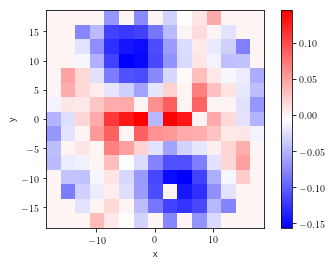

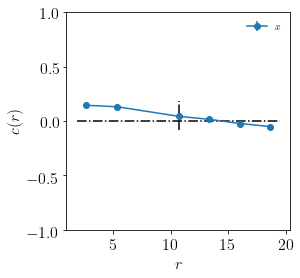

10.699313962120927

In [219]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           xvv, yvv, zvv,
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 xv2d, yv2d,
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

## Crltn Function (FFT)

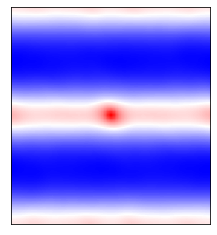

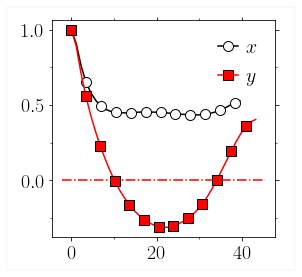

In [43]:
def CrltnFunctionFFT( atom, box, box0, attr, Plot = True):
    
        (xlin,ylin,zlin), (xv, yv, zv), d2intrp = Intrp( atom, box,
                                                         attr, 
                                                         Plot = None 
                                                       )

        (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
        #
        value = np.c_[d2intrp.d2min].reshape((ny,nx,nz))

        #--- shuffle
        #     ( nx, ny, nz ) =  value.shape
        #     slist = value.flatten()
        #     np.random.shuffle(slist)
        #     value=slist.reshape((nx, ny, nz))    
        #
        #--- filter value
        #     value = FilterMatrix( CellVector[0], CellOrigin[0],
        #                   (xlin, ylin, zlin),
        #                   (xv, yv, zv ),
        #                    value )

        crltn = GetAutoCorrelation( value )

#        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
#        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    

        #--- xy plane
        val = crltn[:,:,0].copy()
        if Plot:
            PltCrltn( val, 
                      xlabel = 'x', ylabel = 'y',
                      xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                      frac = 1, #--- plot a patch
                      zscore = False,
                      fileName = 'cxy_d2minBad.png',
                      dpi = 60
                    )

        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
        #---
        (xc, yc), (xdata0,ydata0), (xdata,ydata) =\
                PltCrltnFunc(   crltn, 
                                 xv,yv,
                                 fileName = 'cr_d2minBad.png',
                                 title = '', #r'$\gamma=%3.2f$'%(ebulk),
                                 cTOL = 1.0e-2,
                                 dpi = 150,
                                 PLOT = Plot,
                                )
        
        #--- save
        return  (ebulk, xc, yc)
    
if DminAnalysis:
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    ebulk, xc, yc = CrltnFunctionFFT(atom, box, box0,'d2min', 
                    Plot = True,
                    )

#    np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')


### Multiple Frames

In [44]:
if DminAnalysis:
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lambda x:lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') )

    exy=list(map(lambda x:CrltnFunctionFFT(atom(x), box(x), box0,'d2min', Plot=False), times))
    np.savetxt('rc_d2min.txt',np.c_[exy],header='gamma\txc\tyc')


modify path!
modify path!
modify path!
modify path!
modify path!
modify path!


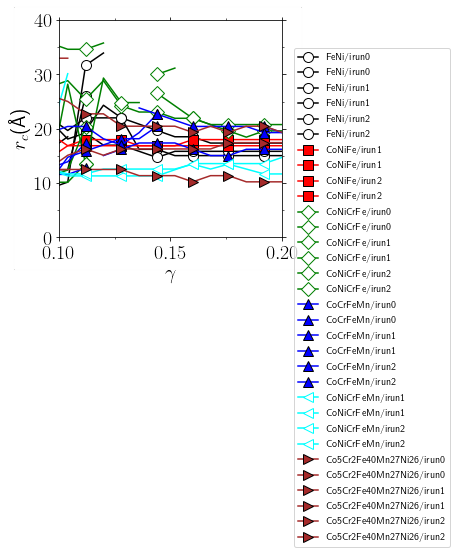

In [68]:
if not RemoteMachine:
    PlotPaperVersion(
                        xlabel=r'$\gamma$',
                        ylabel=r'$r_c$(\r{A})',
                        title='rc_gamma.png',
                        ylim=(0,40),
                        xlim=(0.1,.2),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

#### Plot

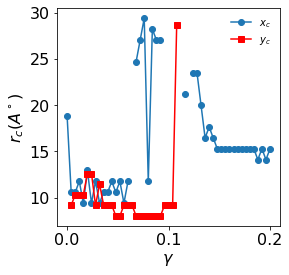

In [74]:
if not RemoteMachine:
    sarr = MultipleFrames('widthFeNi','rc_d2min.txt',irun=0)
#--- plot
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    xstr = r'$\gamma$'
    ystr = r'$r_c(A^\circ)$'
    ax.set_xlabel(xstr,fontsize=16)
    ax.set_ylabel(ystr,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    ax.plot( sarr[:,0], sarr[:,1],'-o', color='C0', label = r'$x_c$')
    ax.plot( sarr[:,0], sarr[:,2],'-s', color='red', label = r'$y_c$')
    ax.legend(frameon=False)
    plt.savefig('rc.png',dpi=75,bbox_inches='tight')
    plt.show()


### Band width vs. mismatch

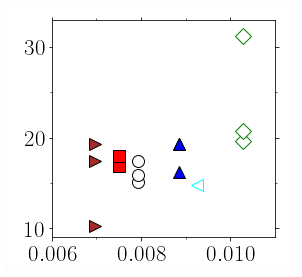

In [493]:
if not RemoteMachine:
    ax=PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=3, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$w_{sb}$',
                        title='WidthAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(9.0,33.0),
#                         legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

# Voronoi Analysis

In [425]:
os.system('mkdir VorAnl')

0

In [426]:
nevery=200
#itime=2000000
VorAnl=True

In [427]:
if VorAnl and Ovitos:
    try:
        !rm Voronoi.xyz
    except:
        pass
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    rad4=0.0#AtomicRadius[4]
    rad5=0.0#AtomicRadius[5]
    !ovitos OvitosCna.py $fileName VorAnl/Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3 $rad4 $rad5  

InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [428]:
#--- read from d2min.xyz
if VorAnl and Ovitos:
    lmpVor = lp.ReadDumpFile( 'VorAnl/Voronoi.xyz' )
    lmpVor.GetCords( ncount = sys.maxsize)

## histogram

(0, 0, 12, 0)	5315	(10.5 %)
(0, 1, 10, 2)	4566	(9.0 %)
(0, 2, 8, 4)	2500	(4.9 %)
(0, 1, 10, 3)	2053	(4.1 %)
(0, 3, 6, 4)	2051	(4.0 %)
(0, 0, 12, 2)	2018	(4.0 %)
(0, 2, 8, 2)	1847	(3.6 %)
(0, 1, 10, 4)	1704	(3.4 %)
(0, 0, 12, 3)	1112	(2.2 %)
(0, 2, 8, 5)	1076	(2.1 %)


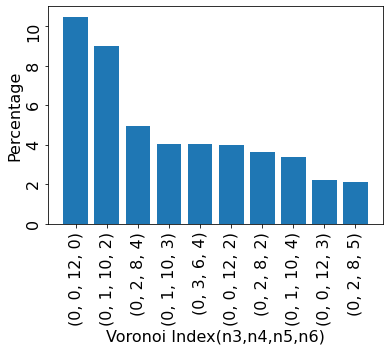

In [20]:
if VorAnl and Ovitos:
     GetMotifs( lmpVor, 
                times = [itime], #[2000000], #lmpData.coord_atoms_broken.keys(),
                Plot = True
              )

## Timeseries

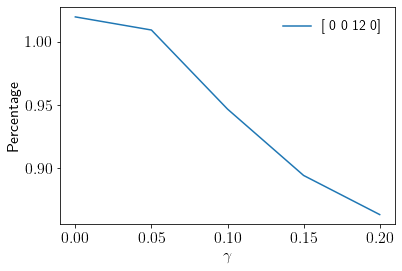

In [19]:
def GetMotifsTimeseries( lmpData, 
                         Motif = np.array([[0,0,12,0]]),
                       ):
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    Unique_indices, Counts = GetMotifs( lmpData, 
                                         times = times,
                                         Plot = False,
                                       )
    vol = GetVolume(lmpData,0)
    natom = len(lmpData.coord_atoms_broken[0].x)
    #
    strn =  list(map(lambda x:GetStrain(lmpData,x,time0=0), times))

    #
    #
    percent = {}
    for motif,indx in zip(Motif,range(len(Motif))):
        percent[indx] = {}
        for itime in times:
            counts = Counts[itime]
            unique_indices = Unique_indices[itime]
            percent[indx][itime] = counts[np.all(unique_indices== motif,axis=1)] * natom / vol
    #--- plot
#     plt.yscale('log')
#     plt.ylim(.1,100)
    plt.xlabel('$\gamma$',fontsize=16)
    plt.ylabel('Percentage',fontsize=16)
    plt.tick_params(labelsize=16)
    #
    for indx in range(len(Motif)):
        plt.plot(strn,list(map(percent[indx].get,times)),
                 '-',
                 label = Motif[indx]
                )
    #
    plt.legend(frameon=False,fontsize=14)
    plt.savefig('motifsTimeSeries.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    np.savetxt('icoPercentageWithStrain.txt',
               np.c_[strn,list(map(percent[indx].get,times))],
               header='gamma\tpercentage'
              )
    
    

if VorAnl and Ovitos:
    GetMotifsTimeseries( lmpVor, 
                         Motif = np.array([[0,0,12,0]]), #,[0,1,10,2],[0,2,8,2],[0,3,6,4],[0,2,8,4]]),
                       )

### Multiple Systems

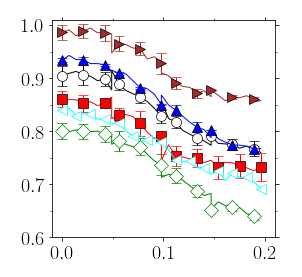

In [36]:
if not RemoteMachine:    

    PlotPaperVersion(2,1,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='icoPercentage.png',
                        ylim=(0.6,1.01),
                        xlim=(-0.01,.21),
                        PlotMean = True,
#                        legend = True
                    )
    

## conditional pdf of d2min

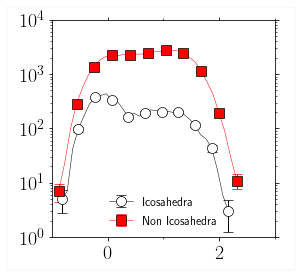

In [74]:

    


if DminAnalysis and VorAnl:
    
    PdfCondD2min( lmpVor, lmpDmin,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minBad.png',
              axisLabels = False,
             )

### gaussian mixture

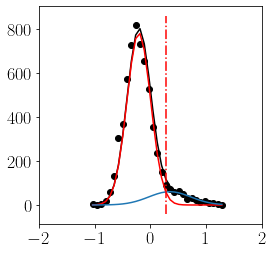

In [431]:
if DminAnalysis and VorAnl:
    
    d2minFiltrd, d2minTotal = PdfCondD2min( lmpVor, lmpDmin,
                                           #times = list(lmpData.coord_atoms_broken.keys()), 
                                           times=[itime], #[2000000],
                                           Plot = False,
                 )
    
    thresh, ratio, gsfitTotal = gaussian_mixture(
                                      #d2minTotal,
                                      d2minFiltrd[itime],
#                                     times = list(d2minFiltrd.keys()), 
                                      #times = [2000000],
                                      PLOT = True,
                                     )
    #--- save
#     nn=len(d2minFiltrd[2000000])
    np.savetxt('d2minFiltrdGood%s.txt'%itime,d2minFiltrd[itime])
    np.savetxt('gsfitTotalGood%s.txt'%itime,gsfitTotal)

#     strn = GetStrain(lmpData, 
#                      times = list(lmpData.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#    np.savetxt('varD2minCondGamma.txt',
#               np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#               header='gamma\tratio')


#### evolution with strain

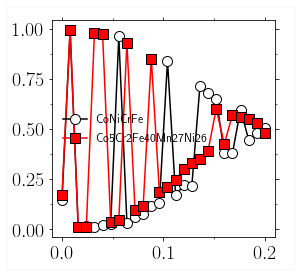

In [419]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                         'FeNi',
#                                         'CoNiFe',
                                        'CoNiCrFe/Run2',
#                                         'CoCrFeMn', 
#                                         'CoNiCrFeMn', 
                                        'Co5Cr2Fe40Mn27Ni26/Run0'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2minRatio%s/d2minRaioGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/20),
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### good, bad, and ugly!

No handles with labels found to put in legend.


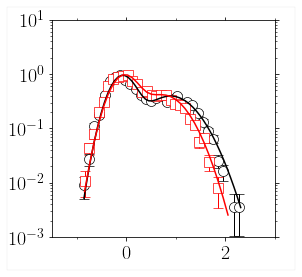

In [464]:
def PdfD2minGoodBad( lmpData, lmpDmin, badfit, goodfit,  times,  
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                    **kwargs
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_xscale('linear' if not 'xscale' in kwargs else kwargs['xscale'])
        ax.set_yscale('linear' if not 'yscale' in kwargs else kwargs['yscale'])
        #
#         ax.set_ylim(1,1e4)
#         ax.set_xlim(-1,3)
#         #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
#        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 



        #--- filtered
        value = lmpDmin
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = True,
                                                        )
        #--- invert
        valinv = lmpData
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = True,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
            nmark = 16
            label = kwargs['label1'] if 'label1' in kwargs else ''
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label=label, markevery = int(len(edges_filtrd)/nmark),
                        errorevery = int(len(edges_filtrd)/nmark), zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpDmin)
            dx=goodfit[:,0][1]-goodfit[:,0][0]
            ax.plot(goodfit[:,0],goodfit[:,1]/nn/dx,'-',color='black',zorder=2)
            
            #
            label = kwargs['label2'] if 'label2' in kwargs else ''
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='s', color='red',
                        markerfacecolor='white', markeredgecolor='red',
                        label=label,markevery = int(len(edges_inv)/nmark),
                        errorevery = int(len(edges_inv)/nmark),zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpData)
            dx=badfit[:,0][1]-badfit[:,0][0]
            ax.plot(badfit[:,0],badfit[:,1]/nn/dx,'-',color='red',zorder=2)
    #
    if Plot:
        #
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
        #
        LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
        LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
        PutMinorTicks(ax,LOGY=LOGY,LOGX=LOGX)
        #
        ax.legend(frameon=False, handletextpad=.01, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=LOGY,LOG_X=LOGX)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()


if DminAnalysis and VorAnl:
    itime = [700000,1000000,1300000,1600000,2000000][3]
    badData = np.loadtxt('d2minFiltrdBad%s.txt'%itime)
    goodData = np.loadtxt('d2minFiltrdGood%s.txt'%itime)
    goodfit =   np.loadtxt('gsfitTotalGood%s.txt'%itime)
    badfit =   np.loadtxt('gsfitTotalbad%s.txt'%itime)

    PdfD2minGoodBad( badData, goodData, badfit, goodfit,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minGoodBad%s.png'%itime,
              axisLabels = False,
#              label1='Co5Cr2Fe40Mn27Ni26', label2='CoNiCrFe',
#              xlim=(-1,2.0,0,1),
              xlim=(-1.5,3.0,1e-3,10),
              yscale='log',
             )

### scatter plot

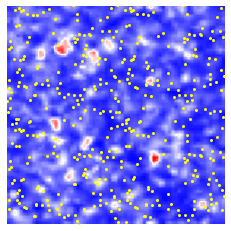

In [430]:
if DminAnalysis and VorAnl:

#     PlotDminVor( lmpVor, lmpDmin, 
#                  times = [itime], #[2000000],#list(lmpData.coord_atoms_broken.keys()),
#                 title='d2minBad',
#                )

    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))

    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    d2min, box, 'd2min',
                    vor,
                    Plot = True,
                    title='d2minGood20000002nd.png',
                    ticklabels = False,
                    colorbar = False,
                   )
    

## SRO density

InputFile= junk.xyz
num_frames= 1
frame=0


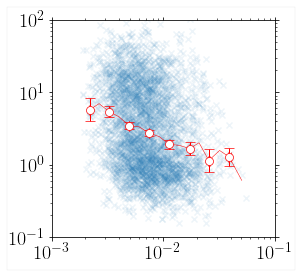

cxy= -0.2638464317166046


In [198]:
if DminAnalysis and VorAnl:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    d2min.tmp = d2min.d2min
    #
    crs = ScatterXY(  vor, d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                axisLabels = True,
                xlim=(1e-3,1e-1,1e-1,1e2),
                title = 'scatterD2minRhoBad2nd.png', 
                )                      
    print('cxy=',crs)    
    #--- save
    strn = GetStrain(lmpData, 
                     times = itime, #list(lmpData.coord_atoms_broken.keys()), 
                     time0 = 0 )
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[strn,crs], 
               header='gamma\tCrltnCoeff')


### kde

(nx,ny)= (128, 128)


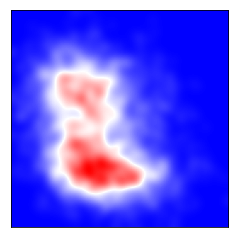

In [199]:
def GetInterpolatedData2d( x,y, 
                         xv, yv
                       ):
    dx = xv[1]-xv[0]
    dy = yv[1]-yv[0]
    dr = (dx*dx+dy*dy)**0.5
    r2nd=3*dr #--- g(r)
    sigma = int(r2nd/dr)
    heatmap, edges = np.histogramdd( np.c_[y, x],
                                    bins=[np.append(yv,yv[-1]+dy),
                                          np.append(xv,xv[-1]+dx)],
                                    normed=True)

    print('(nx,ny)=', heatmap.shape )
    
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap

def DensityMap2d(xs, ys, **kwargs):    
    #--- scattered points
#     xs = np.array(atoms0.xm)[filtr] #--- must be reference frame!
#     ys = np.array(atoms0.ym)[filtr]
#     zs = np.array(atoms0.zm)[filtr]

#    (nx,ny,nz)=list(map(len,[xv,yv,zv]))
    
    xv=np.linspace((xs.min()),(xs.max()),128)
    yv=np.linspace((ys.min()),(ys.max()),128)
    #--- density
    heatmap2d=GetInterpolatedData2d(xs,ys,
                                xv, yv,
                               )
    #--- bitmap
    PltBitmap(
          heatmap2d, #transpose? 
          **kwargs
          )

    
    return heatmap2d
    
if DminAnalysis and VorAnl:
    #--- cross crltn.
    x = np.array(vor.tmp)
    y = np.array(d2min.tmp)
    #---

    y=y[x>0]
    x=x[x>0]

    attrs={
          'xlabel' : r'$x$(\r{A})', 'ylabel' : r'$y$(\r{A})',
#          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
          'zscore' : None,
          'frac' : 1.0, #--- plot a patch
          'title' : 'kdeRhoBad.png',
#          'colorbar':True,
          'labels' : False,
          'color':'black',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
    }
    DensityMap2d(np.log10(x), np.log10(y),**attrs)


### multiple frames

InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1


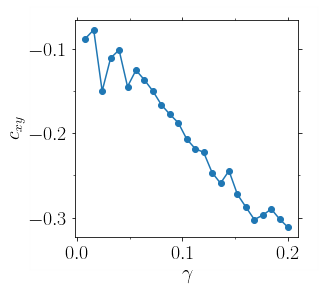

In [92]:
def vor(x):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ))
    tmp = lp.Atoms( **lmpVor.coord_atoms_broken[x].to_dict(orient='series') )
    rho = sroDensityDiscrete( tmp, box,
                              AtomicRadius )
    tmp.tmp = rho
    return tmp
#
def d2min(x):
    tmp = lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ) 
    tmp.tmp = tmp.d2min
    return tmp

if DminAnalysis and VorAnl:
    #
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)

    crs = map(lambda x:ScatterXY(  vor(x), d2min(x),
                Plot = False, 
                PLOT_AVERAGE = False,
                ),times)                     
    
    #--- save
    ydata = np.array(list(crs))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[xdata,ydata], 
               header='gamma\tCrltnCoeff')
    

    #--- plot
    PltErr(xdata,
           ydata,
           yerr=None,
#      ylim=[0,5],
       ystr='$c_{xy}$',
       xstr='$\gamma$',
#       yscale='log',
#       xscale='log',
#       title='dmin_gamma.png'
      )

### multiple systems

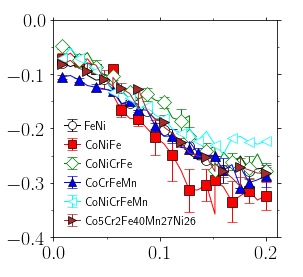

In [44]:
if not RemoteMachine:
    PlotPaperVersion(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        title='cxyGamma2nd.png',
#                        xlabel=r'$\gamma$',
#                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        PlotMean = True,
                      )

### hmin and cxy

[-0.27945408 -0.27890289 -0.28570318 -0.3773356  -0.28736781 -0.3139864
 -0.25742434 -0.24308035 -0.29776095 -0.25823142 -0.34262832 -0.22980893
 -0.30211744 -0.3071519  -0.25745512]
[44.16854417 -9.3326129 ]


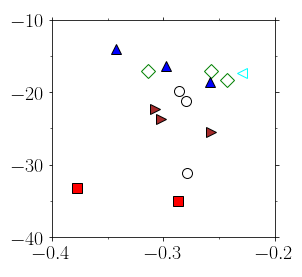

In [276]:
if not RemoteMachine:
    
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$c_{xy}$',
#                        ylabel=r'$h_{min}$',
                        title='hCxy2nd.png',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
#                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        fontsize = 20,
                            
                           )


# Local Moduli
+ analysis of local modulus fluctuations
+ output files in "ModuAnl" directory

In [153]:
LAOS = False
os.system('mkdir ModuAnl')

0

## parse data

In [35]:
#if ModuAnl:
#     t0=time.time()    
#     #--- read initial atomic positions/stresses
#     atomi, boxi = utl.GetAtoms( '%s/dump_init.xyz'%path, nevery = 1 ) #--- change it to 1
#     atoms0 = utl.GetTimeAverageAtom( atomi ) #--- argument: dic with key: time and val: atom object
#     #
#     itime0 = list(atomi.keys())[0]
#     box0=boxi[itime0]
#     #
#     atomd = {}
#     boxd = {}
#     ebulk = {}
#     #--- read data for deformed configurations
#     #for dirr, mode in zip(range(1,7),['xx','yy','zz','yz','xz','xy']):
#     for dirr, mode in zip([6],['xy']):
#         atomt, boxt = utl.GetAtoms( '%s/dump_def%s.xyz'%(path,dirr), nevery=1 )
#         atomt.pop(0) #--- time 0 is not equilibrated!
#         atomd[mode] = utl.GetTimeAverageAtom( atomt )
#         #
#         itime0 = list(atomt.keys())[0]
#         boxd[mode] = boxt[itime0]
#         #
#         #--- evaluate strain
#         if dirr == 1 or dirr == 2 or dirr == 3:
#             indxi = dirr - 1
#             indxj = dirr - 1
#         elif dirr == 6: #--- xy
#             indxi = 0
#             indxj = 1
#         dx=boxd[mode].CellVector[indxi,indxj]-box0.CellVector[indxi,indxj]
#         l0=box0.CellVector[indxj,indxj]        
#         ebulk[mode] = dx/l0    
#     ebulk['yz']=ebulk['xz']=ebulk['xy']
#     print('ebulk=',ebulk)
#     #
#     print('duration=%s s'%(time.time()-t0))

    
    

In [102]:
if ModuAnl and not LAOS:
    t0 = time.time()
    modDataInit = lp.ReadDumpFile( '%s/dump_init.xyz'%path )
    modDataUp   = lp.ReadDumpFile( '%s/dumpUp_6.xyz'%path )
    modDataDown = lp.ReadDumpFile( '%s/dumpDown_6.xyz'%path )
    modDataInit.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    modDataUp.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    modDataDown.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    print('duration=%s s'%(time.time()-t0))
    print('timesteps=',modDataInit.coord_atoms_broken.keys())

duration=63.20726704597473 s
timesteps= dict_keys([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])


In [12]:
if ModuAnl and LAOS:
    t0 = time.time()
    modData = lp.ReadDumpFile( '%s/shearOscillation.xyz'%path )
    modData.GetCords( ncount = sys.maxsize, 
    #                 columns = {'c_mystress[4]':'sxy'},
    #                 columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'},
                     columns = {'c_1[4]':'sxy'},
                    )
    print('duration=%s s'%(time.time()-t0))
    modData.coord_atoms_broken.keys()

duration=31.364439964294434 s


In [103]:
if ModuAnl and not LAOS:
    #--- add volumes
    neveryy = 100
    os.system('ovitos OvitosCna.py %s %s %s %s %s %s %s'\
              %('%s/dump_init.xyz'%path,'ModuAnl/Voronoi.xyz',neveryy,3,0.0,0.0,0.0))  
    ovtData = lp.ReadDumpFile( 'ModuAnl/Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- insert column
    times = modDataInit.coord_atoms_broken.keys()
    loc=len(modDataInit.coord_atoms_broken[0].keys())
    val = ovtData.coord_atoms_broken[0]['AtomicVolume'].to_list()
    #modData.coord_atoms_broken[0].drop(['AtomicVolume'], axis=1,inplace=True)
    list(map(lambda x:modDataInit.coord_atoms_broken[x].insert(loc, 'AtomicVolume', val),times))
    list(map(lambda x:modDataUp.coord_atoms_broken[x].insert(loc, 'AtomicVolume', val),times))
    list(map(lambda x:modDataDown.coord_atoms_broken[x].insert(loc, 'AtomicVolume', val),times))
    
    display(modDataInit.coord_atoms_broken[0].head())

InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//dump_init.xyz
num_frames= 42
frame=0/42


id  type      x      y       z  c_peratom[1]  c_peratom[2]  c_peratom[3]  \
0   1     4  14.94 -10.67 -42.780     -711200.0      702700.0     -903800.0   
1   2     2 -11.31 -19.82  -9.717     -878900.0       89310.0     -492500.0   
2   3     1 -36.60 -16.58  11.130     1134000.0     1819000.0    -1046000.0   
3   4     2 -27.75 -20.61 -19.670     -269600.0    -1223000.0     -439800.0   
4   5     2 -13.46  19.58  16.920     -156700.0     -652300.0      -90080.0   

        sxy  c_peratom[5]  c_peratom[6]  AtomicVolume  
0  644200.0     -889000.0     -143000.0     12.545086  
1 -316500.0     -159600.0      690300.0     11.543468  
2   72530.0      667600.0      872400.0     12.094778  
3 -809000.0      933000.0      446000.0     11.440464  
4 -290700.0     -325500.0     -871700.0     11.546827

In [13]:
if ModuAnl and LAOS:
    #--- add volumes
    neveryy = 100
    os.system('ovitos OvitosCna.py %s %s %s %s %s %s %s'\
              %('%s/shearOscillation.xyz'%path,'ModuAnl/Voronoi.xyz',neveryy,3,0.0,0.0,0.0))  
    ovtData = lp.ReadDumpFile( 'ModuAnl/Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- insert column
    times = modData.coord_atoms_broken.keys()
    loc=len(modData.coord_atoms_broken[0].keys())
    val = ovtData.coord_atoms_broken[0]['AtomicVolume'].to_list()
    #modData.coord_atoms_broken[0].drop(['AtomicVolume'], axis=1,inplace=True)
    list(map(lambda x:modData.coord_atoms_broken[x].insert(loc, 'AtomicVolume', val),times))
    
    display(modData.coord_atoms_broken[0].head())

InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//shearOscillation.xyz
num_frames= 41
frame=0/41


id  type       x       y        z     c_1[1]     c_1[2]     c_1[3]  \
0   1     4  14.926 -10.421 -43.0160  -589600.0   340600.0 -1025000.0   
1   2     2 -11.200 -19.846  -9.7167    46290.0   887800.0   149900.0   
2   3     1 -36.750 -16.962  10.9490  1554000.0  2210000.0  -459200.0   
3   4     2 -27.661 -20.699 -19.6700  -418800.0 -1413000.0   405700.0   
4   5     2 -13.481  19.515  16.8060   110000.0 -1470000.0   345200.0   

        sxy    c_1[5]     c_1[6]  AtomicVolume  
0  762800.0 -292800.0  -423200.0     12.237026  
1  269900.0 -131800.0   724400.0     11.940458  
2 -119100.0   23990.0  -150400.0     12.178074  
3 -527600.0  166000.0  -350300.0     11.328290  
4 -306800.0 -788500.0 -1031000.0     11.488884

### Plot

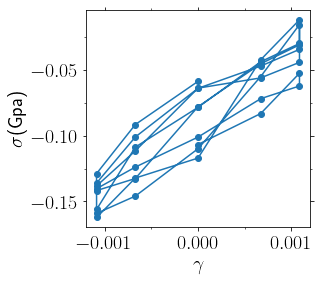

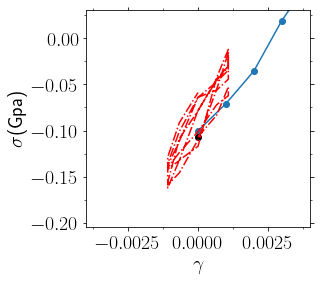

mu=49.57516914949795 Gpa


In [67]:
if ModuAnl and LAOS:
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: np.sum(lp.Atoms( **modData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                         utl.GetVolume(modData,x)
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    #
    PltErr(strainDump,Virial,
           yerr=None,
    #      ylim=[0,5],
           xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
          )


    xarray=np.loadtxt('loadCurve.txt')
    ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
    eps = GetStrain(lmpData,itime,0)
    #eps=0.9*0.2 #--- itime=90
    ax=PltErr(strainDump[0]+eps, Virial[0],
           Plot=False,
           attrs={'fmt':'-.o','color':'black'},
           ax=ax,
          )
    PltErr(strainDump+eps, Virial,
           Plot=True,
           ax=ax,
           xlim=(eps-strainDump.max(),eps+strainDump.max()),
           ylim=(Virial.min()-Virial.std(),Virial.max()+Virial.std()),
           attrs={'fmt':'-.r'},
          xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
          )
    print('mu=%s Gpa'%(np.polyfit(strainDump, Virial, 1)[0]))

mu=37.61467874093232 Gpa


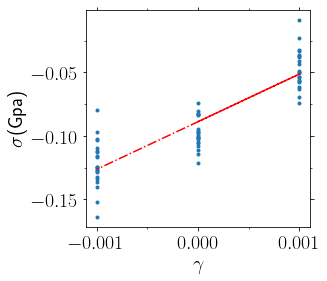

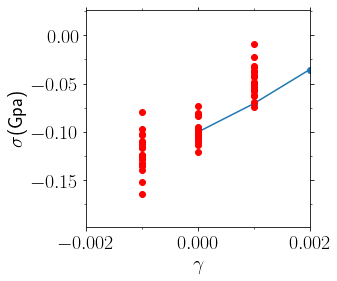

In [104]:
def Wrapper(modData):
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: np.sum(lp.Atoms( **modData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                         utl.GetVolume(modData,x)
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    return strainDump, Virial

def GetStrainn(box0,box ):
    ebulk = {}
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    return ebulk

def func(x,a,b):
    return a*x+b

if ModuAnl and not LAOS:
    
    strainDump, VirialInit = Wrapper(modDataInit)
    strainUp, VirialUp = Wrapper(modDataUp)
    strainDown, VirialDown = Wrapper(modDataDown)
    
    dgammaUp = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))
    dgammaDown = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))

    #
    strainDump = np.concatenate([strainDump,dgammaUp*np.ones(len(strainDump)),dgammaDown*np.ones(len(strainDump))])
    Virial = np.concatenate([VirialInit, VirialUp, VirialDown] )
    ax=PltErr(strainDump, Virial,
           yerr=None,
    #      ylim=[0,5],
           xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
           attrs={'fmt':'.'},
            Plot=False,
          )
    print('mu=%s Gpa'%(np.polyfit(strainDump, Virial, 1)[0]))
    PltErr(strainDump, func(strainDump,*np.polyfit(strainDump, Virial, 1)),
       yerr=None,
#      ylim=[0,5],
       xstr=r'$\gamma$',
       ystr=r'$\sigma$(Gpa)',
       attrs={'fmt':'-.r'},
       ax=ax,
      )

    #---
    xarray=np.loadtxt('loadCurve.txt')
    ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
    eps = GetStrain(lmpData,itime,0)
    #eps=0.9*0.2 #--- itime=90
    ax=PltErr(strainDump[0]+eps, Virial[0],
           Plot=False,
           attrs={'fmt':'-.o','color':'black'},
           ax=ax,
          )
    PltErr(strainDump+eps, Virial,
           Plot=True,
           ax=ax,
           xlim=(eps-2*strainDump.max(),eps+2*strainDump.max()),
           ylim=(Virial.min()-Virial.std(),Virial.max()+Virial.std()),
           attrs={'fmt':'or'},
          xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
          )


In [16]:
# #--- x,y bounds
# xlo=0;xhi=1e-5
# filtr=np.all([sarray[:,0]>=xlo,sarray[:,0]<xhi],axis=0)
# ylo=sarray[:,1][filtr].min()
# yhi=ylo=sarray[:,1][filtr].max()

# PltErr(sarray[:,0],sarray[:,1],
#       xlim=(xlo,xhi),
#        ylim=(ylo,yhi)
#       )

# ax=PltErr(sarray[:,0],sarray[:,1],Plot=False)
# eps = GetStrain(lmpData,itime,0)
# #eps=0.9*0.2 #--- itime=90
# ax=PltErr(strainDump[0]+eps, Virial[0],
#        Plot=False,
#        attrs={'fmt':'-.o','color':'black'},
#        ax=ax,
#       )
# PltErr(strainDump+eps, Virial,
#        Plot=True,
#        ax=ax,
#        xlim=(eps-0.002,eps+0.002),
#        ylim=(Virial.min()-Virial.std(),1.5*Virial.max()+Virial.std()),
#        attrs={'fmt':'-.r'},
#       xstr=r'$\gamma$',
#        ystr=r'$\sigma$(Gpa)',
#       )

In [101]:
# def GetStrainn(box0,box ):
#     ebulk = {}
# #    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0], AddMissing = np.array([0.0,0.0,0.0] ))
#     if 1:
# #    for itime in times:
# #        itime = times
# #        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
#         #
#         #--- bulk strain
#         dx=box.CellVector[0,1]-box0.CellVector[0,1]
#         l1=box.CellVector[1,1]
#         ebulk = dx/l1
#     return ebulk

# #--- debuging: stress perturbation
# pathhh=path #'/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/testRuns/Preparation'
# atomi, boxi = GetAtoms( '%s/dump_init.xyz'%pathhh, nevery = 1 ) #--- change it to 1
# atomf, boxf = GetAtoms( '%s/dump_def6.xyz'%pathhh, nevery = 1 ) #--- change it to 1

# #--- volumes
# CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( boxi[0].CellVector )
# voli= np.linalg.det( CellVectorOrtho )
# CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( boxf[0].CellVector )
# volf= np.linalg.det( CellVectorOrtho )

# #--- initial and final stress
# s0=list(map(lambda x:pd.DataFrame(atomi[x].__dict__).sxy.sum()*1e-4, atomi.keys()))/voli
# s1=list(map(lambda x:pd.DataFrame(atomf[x].__dict__).sxy.sum()*1.0e-4, atomf.keys()))/volf
# ax=PltErr(atomi.keys(),s0,Plot=False)
# PltErr(atomf.keys(),s1,ax=ax,attrs={'fmt':'.-r'})

# #--- strain step
# dgamma=GetStrainn(boxi[0],boxf[0] )
# eps = GetStrain(lmpData,itime,0)

# xarray=np.loadtxt('loadCurve.txt')
# ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
# #eps=0.9*0.2 #--- itime=90
# PltErr(np.ones(len(s0))*eps,s0,Plot=False,ax=ax)
# PltErr(np.ones(len(s0))*(eps+dgamma),s1,Plot=False,ax=ax,xlim=(0.96*eps,1.04*eps)) #,ylim=(0.5,1))



## elastic constants

In [20]:
# if ModuAnl:
#     cfac = 1.0e-4 #--- bar to gpa
#     dxx={}
#     dyy={}
#     dzz={}
#     dyz={}
#     dxz={}
#     dxy={}
#     for mode in ['xy']: #['xx','yy','zz','yz','xz','xy']:
#         dxx[mode]=(atomd[mode].sxx/atomd[mode].AtomicVolume-atoms0.sxx/atoms0.AtomicVolume)/ebulk[mode]*cfac
#         dyy[mode]=(atomd[mode].syy/atomd[mode].AtomicVolume-atoms0.syy/atoms0.AtomicVolume)/ebulk[mode]*cfac
#         dzz[mode]=(atomd[mode].szz/atomd[mode].AtomicVolume-atoms0.szz/atoms0.AtomicVolume)/ebulk[mode]*cfac
#         dyz[mode]=(atomd[mode].syz/atomd[mode].AtomicVolume-atoms0.syz/atoms0.AtomicVolume)/ebulk[mode]*cfac
#         dxz[mode]=(atomd[mode].sxz/atomd[mode].AtomicVolume-atoms0.sxz/atoms0.AtomicVolume)/ebulk[mode]*cfac
#         dxy[mode]=(atomd[mode].sxy/atomd[mode].AtomicVolume-atoms0.sxy/atoms0.AtomicVolume)/ebulk[mode]*cfac

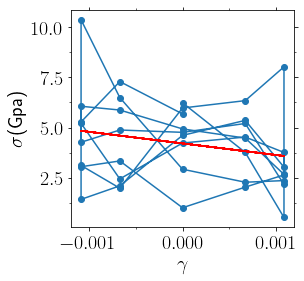

id  type       x       y        z     c_1[1]     c_1[2]     c_1[3]  \
0   1     4  14.926 -10.421 -43.0160  -589600.0   340600.0 -1025000.0   
1   2     2 -11.200 -19.846  -9.7167    46290.0   887800.0   149900.0   
2   3     1 -36.750 -16.962  10.9490  1554000.0  2210000.0  -459200.0   
3   4     2 -27.661 -20.699 -19.6700  -418800.0 -1413000.0   405700.0   
4   5     2 -13.481  19.515  16.8060   110000.0 -1470000.0   345200.0   

        sxy    c_1[5]     c_1[6]  AtomicVolume          C66  
0  762800.0 -292800.0  -423200.0     12.237026  -577.894441  
1  269900.0 -131800.0   724400.0     11.940458  -962.336765  
2 -119100.0   23990.0  -150400.0     12.178074  -466.303997  
3 -527600.0  166000.0  -350300.0     11.328290   213.442720  
4 -306800.0 -788500.0 -1031000.0     11.488884 -1309.959600

mu=49.97192866703905 Gpa


In [17]:
def func(x,a,b):
    return a*x+b

def GetModulus(atomid,modData, Plot=False):
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: modData.coord_atoms_broken[x].iloc[atomid].sxy/\
                         modData.coord_atoms_broken[x].iloc[atomid].AtomicVolume
    
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    #--- fit
    z = np.polyfit(strainDump, Virial, 1)
    
    
    if Plot:
        ax=PltErr(strainDump,Virial,
                  Plot=False,
              )
        PltErr(strainDump,func(strainDump,*z),
               ax=ax,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               attrs={'fmt':'-r'}
              )
        
    return z[0]

if ModuAnl and LAOS:
    #--- fit
    junk = GetModulus(0,modData, Plot=True)
    
    
    virials = np.c_[list(map(lambda x: 1.0e-04*modData.coord_atoms_broken[x].sxy/\
                          modData.coord_atoms_broken[x].AtomicVolume,times))]
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    gmodu = list(map(lambda x:np.polyfit(strainDump, x, 1)[0],virials.T))
    
    #--- add columns
    loc=len(modData.coord_atoms_broken[0].keys())
    val = gmodu
    #modData.coord_atoms_broken[0].drop(['AtomicVolume'], axis=1,inplace=True)
    modData.coord_atoms_broken[0].insert(loc, 'C66', val)
    display(modData.coord_atoms_broken[0].head())
    #--- atom object
    atomm = lp.Atoms(**modData.coord_atoms_broken[0])
    print('mu=%s Gpa'%(atomm.C66.mean()))

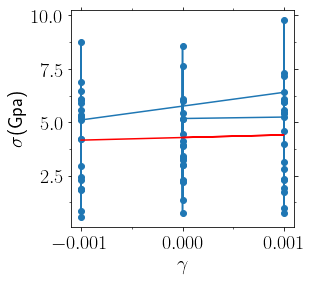

virialsInit.shape= (21, 50688)
virials.shape= (63, 50688)
strainDump.shape= (63,)


id  type      x      y       z  c_peratom[1]  c_peratom[2]  c_peratom[3]  \
0   1     4  14.94 -10.67 -42.780     -711200.0      702700.0     -903800.0   
1   2     2 -11.31 -19.82  -9.717     -878900.0       89310.0     -492500.0   
2   3     1 -36.60 -16.58  11.130     1134000.0     1819000.0    -1046000.0   
3   4     2 -27.75 -20.61 -19.670     -269600.0    -1223000.0     -439800.0   
4   5     2 -13.46  19.58  16.920     -156700.0     -652300.0      -90080.0   

        sxy  c_peratom[5]  c_peratom[6]  AtomicVolume         C66  
0  644200.0     -889000.0     -143000.0     12.545086  122.277058  
1 -316500.0     -159600.0      690300.0     11.543468   70.068484  
2   72530.0      667600.0      872400.0     12.094778   56.453289  
3 -809000.0      933000.0      446000.0     11.440464   33.916790  
4 -290700.0     -325500.0     -871700.0     11.546827  -85.546298

mu=37.94406719850039 Gpa


In [105]:
def func(x,a,b):
    return a*x+b

def Wrapper(atomid,modData):
    times = modData.coord_atoms_broken.keys()
    func_sxy = lambda x: modData.coord_atoms_broken[x].iloc[atomid].sxy/\
                         modData.coord_atoms_broken[x].iloc[atomid].AtomicVolume
    
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    return strainDump, Virial
    
def GetModulus(atomid,modDataInit,modDataUp,modDataDown, Plot=False):

    strainDump, VirialInit = Wrapper(atomid,modDataInit)
    strainUp, VirialUp = Wrapper(atomid,modDataUp)
    strainDown, VirialDown = Wrapper(atomid,modDataDown)
    
    dgammaUp = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))
    dgammaDown = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))

    #
    strainDump = np.concatenate([strainDump,dgammaUp*np.ones(len(strainDump)),dgammaDown*np.ones(len(strainDump))])
    Virial = np.concatenate([VirialInit, VirialUp, VirialDown] )

    
    #--- fit
    z = np.polyfit(strainDump, Virial, 1)
    
    
    if Plot:
        ax=PltErr(strainDump,Virial,
                  Plot=False,
              )
        PltErr(strainDump,func(strainDump,*z),
               ax=ax,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               attrs={'fmt':'-r'}
              )
        
    return z[0]

if ModuAnl and not LAOS:
    #--- fit: atom id = 0
    junk = GetModulus(0,modDataInit,modDataUp,modDataDown, Plot=True)
    

    #--- atom-wise virials
    virialsInit = np.c_[list(map(lambda x: 1.0e-04*modDataInit.coord_atoms_broken[x].sxy/\
                      modDataInit.coord_atoms_broken[x].AtomicVolume,times))]
    print('virialsInit.shape=',virialsInit.shape)
    virialsUp = np.c_[list(map(lambda x: 1.0e-04*modDataUp.coord_atoms_broken[x].sxy/\
                      modDataUp.coord_atoms_broken[x].AtomicVolume,times))]
    virialsDown = np.c_[list(map(lambda x: 1.0e-04*modDataDown.coord_atoms_broken[x].sxy/\
                      modDataDown.coord_atoms_broken[x].AtomicVolume,times))]

    virials = np.concatenate([virialsInit,virialsUp,virialsDown],axis=0)
    print('virials.shape=',virials.shape)
    
    boxInit = lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ))
    boxUp = lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) )
    boxDown = lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) )
                     
    dgammaUp = GetStrainn(boxInit , boxUp)
    dgammaDown = GetStrainn( boxInit , boxDown)
    #
    strainDump = np.concatenate([np.zeros(len(times)),dgammaUp*np.ones(len(times)),dgammaDown*np.ones(len(times))])
    print('strainDump.shape=',strainDump.shape)

    
    gmodu = list(map(lambda x:np.polyfit(strainDump, x, 1)[0],virials.T))
    
#     #--- add columns
    modData = modDataInit
    loc=len(modData.coord_atoms_broken[0].keys())
    val = gmodu
    #modData.coord_atoms_broken[0].drop(['C66'], axis=1,inplace=True)
    modData.coord_atoms_broken[0].insert(loc, 'C66', val)
    display(modData.coord_atoms_broken[0].head())
    #--- atom object
    atomm = lp.Atoms(**modData.coord_atoms_broken[0])
    print('mu=%s Gpa'%(atomm.C66.mean()))

### output dump

In [21]:
# if ModuAnl:
#     df=pd.DataFrame(atoms0.__dict__)
#     cols = list(df.keys())+['C66'] # + ['C55'] + ['C44']#--- C66 is cxyxy
#     df = pd.DataFrame(np.c_[df,dxy['xy'],
#     #                        dxz['xz'],
#     #                        dyz['yz']
#                            ],
#                       columns=cols)
#     atomm = lp.Atoms(**df)
#     wd = lp.WriteDumpFile(atomm, box0)
#     wd.Write('ModuAnl/dump.xyz',
#              attrs=['id', 'type','x', 'y', 'z', 'sxx', 'syy', 'szz', 'sxy', 'sxz', 'syz',
#                    'AtomicVolume', 'C66'],
#              fmt='%i %i %15.14e %15.14e %15.14e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e')
# #    os.system('tar czf dump.gz dump.xyz')

tar: dump.xyz: Cannot stat: No such file or directory
tar: Error exit delayed from previous errors.


#### append

In [150]:
# if not RemoteMachine:
#     try:
#         os.system('rm Modu.xyz')
#     except:
#         pass
#     for i in range(200):
#         os.system('tar xzf FeNiT300Elasticity%s/Run1/dump.gz'%(i))
#         os.system('cat dump.xyz >> Modu.xyz')
# #        os.system('cat FeNiT300Elasticity%s/Run1/dump.xyz >> Modu.xyz'%(i))

### map

In [22]:
# itime = times[strainDump>=ey][0]
# print('itime(peak)=%s'%itime)    
# itime = times[strainDump>=em][0]
# print('itime(max. drop)=%s'%itime)
# itime = times[strainDump>=ef][0]
# print('itime(flow)=%s'%itime)
#itime=0

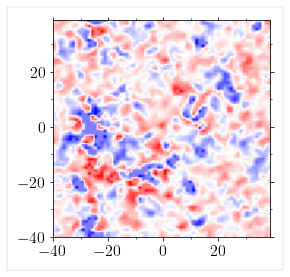

In [106]:
if ModuAnl:
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

    (xlin, ylin, zlin), (xv, yv, zv), d2intrp = Intrp(atomm, box0, 'C66',
                    Plot = True,
                    title='ModuAnl/mapCxyxy.%s.png'%itime,
#                    cmap='Greys',
#                    colorbar=True,
                    zscore=True,
                    DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                    xlabel = '', ylabel = '',
#                    vmin=,vmax=,
                   )

## crltn with D2min 

In [305]:
if ModuAnl and not RemoteMachine :
    #--- d2min associated with the perturbed states
    refs='%s/dump_init.xyz'%path
    curr='%s/dump_def%s.xyz'%(path,6)
    !rm 'd2min.xyz'
    !ovitos OvitosCna.py $curr 'd2min.xyz' 1 2 $refs
    #--- read from d2min.xyz
    lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

rm: d2min.xyz: No such file or directory
InputFile= /Users/Home/Desktop/Tmp/txt/itime0/dump_def6.xyz
num_frames= 21
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20


### average 

In [394]:
if ModuAnl and not RemoteMachine:
    #slist=[]
    atoms={}
    for key in lmpDmin.coord_atoms_broken.keys():
        if key ==0:
            continue
        atoms[key] = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
#        slist += [atoms[key]['d2min'].iloc[0]]
    #plt.hist(slist,bins=32)
    #plt.show()
    d2min = GetTimeAverageAtom( atoms )

### Spatial map 

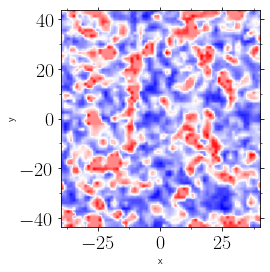

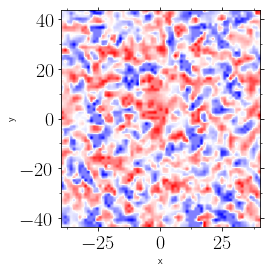

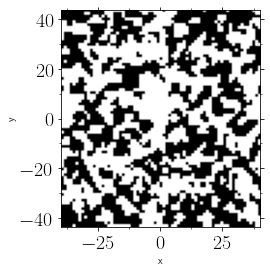

In [321]:
#---
if ModuAnl and not RemoteMachine:
#    itime=2000000
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
#     (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = IntrpScatter(
#                     d2min, box0, 'd2min',
#                     vor,
#                     Plot = True,
#                     title='scatterD2minRhoGood.png'
#                    )
    (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = Intrp(
                    d2min, box0, 'd2min',
                    Plot = True,
                    title='D2minPerturbIntrp.%s.png'%itime
                   )

    junk, (xv, yv, zv), mu_intrp = Intrp(atomm, box0, 'C66',
                    Plot = True,
                    title='mapCxyxy.png'
                   )

    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()

    junk = PltBinary(
                        xlin,ylin,zlin, mu_intrp.C66,
                        box0,
                        mu,
                        cmap='Greys',
#                        title='negative_mu.%s.png'%itime,
                        #                    cmap='Greys',
                        zscore=False,
                        #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )

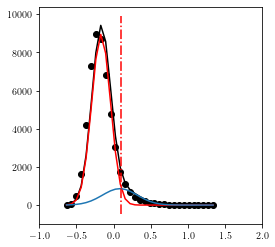

thresh= 0.10582942168843111


In [45]:
if ModuAnl and not RemoteMachine:
    thresh, ratio, junk = gaussian_mixture(
                                     dict(zip([itime],[d2min.d2min])),
                                     times = [itime], 
                                     PLOT = True,
                                 )
    mu_divide = np.log10(thresh[itime])
    print('thresh=',mu_divide)

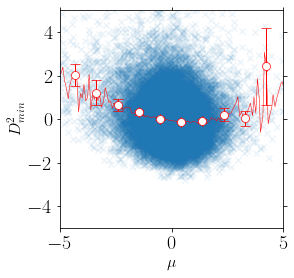

In [407]:
if ModuAnl and not RemoteMachine:
    atomm.tmp = atomm.C66
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atomm,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*5,
    #            title = 'scatterModuRho.png',
                axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

## mu auto correlation

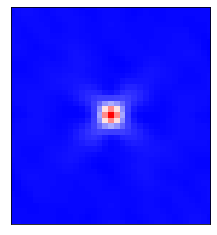

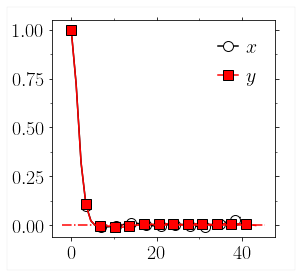

In [48]:
if ModuAnl and not RemoteMachine:
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[mu_intrp.C66].reshape((ny,nx,nz))
    Crltn = GetAutoCorrelation( value )
    #
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    #--- xy plane
    val = Crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_mu.png',
              dpi = 60
            )
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_mu.png',
                 title = '',
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    #--- bulk strain
    dx=box0.CellVector[0,1]
    l1=box0.CellVector[1,1]
    ebulk = dx/l1
    #--- save
    np.savetxt('mu_length.txt',np.c_[ebulk,xc,yc],header='strain\txc\tyc')
    xc,yc

### discrete version

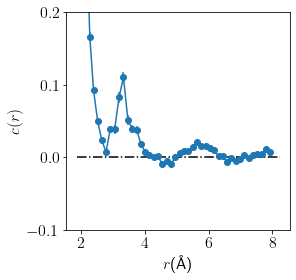

In [49]:
if ModuAnl and not RemoteMachine:
    #--- neighbor list
    neigh = lmpNeigh.coord_atoms_broken[itime]
    
    #--- ij pairs
    atomiIds = np.array(neigh.id)
    atomjIds = np.array(neigh.J,dtype=int)

    #--- product of rho and mu
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_modi = FilterDataFrame(df_mod,key='id',val=atomiIds)
    df_modj = FilterDataFrame(df_mod,key='id',val=atomjIds)
    x = df_modi['C66']
    y = df_modj['C66']
    #---
    crltn = lp.ComputeCrltn(  atomm, box0, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh.DIST,
                    rvect = np.c_[neigh[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
           ylim=[-0.1,0.2],#[-.1,.3],
           title='crMuMu.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuMu.%s.txt'%itime,np.c_[rv, hist, err],header='r\tc(r)\terr')
    

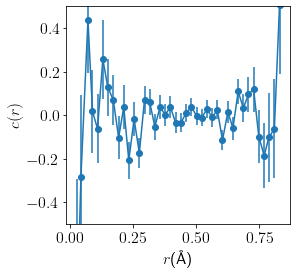

In [1289]:
# n=3*10000
# x=np.random.random(size=n)-0.5
# x=x.reshape((int(n/3),3))
# r=(x[:,0]**2+x[:,1]**2+x[:,2]**2)**.5
# v=np.random.random(size=int(n/3))
# vs = v.copy()
# np.random.shuffle(v)
# if 1:
#     crltn = lp.ComputeCrltn(  atoms, box, 
#                               atomm.C66, #--- values
#                               dx = 0.02)
#     crltn.AutoCrltn2nd(RADIAL = True, 
#                     rlist = r,
#                     rvect = x,
#                     xlist = v,
#                     ylist = vs #np.random.shuffle(v)
#                    )
#     rv, hist, err = crltn.Get()
#     #--- plot
#     PltErr(rv,hist,err,      
#            ylim=[-0.5,0.5],#[-.1,.3],
#            title='crMuMu.png',
#            xstr=r'$r$(\r{A})',
#           )
# # #plt.hist(x)
# # #plt.show()

### multiple files

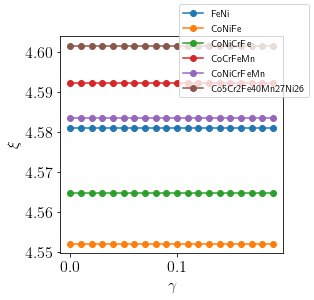

In [499]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylabel(r'$\xi$',fontsize=16)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))

        sarr = np.loadtxt('mu_size.txt')
        ax.plot(sarr[:,0],0.5*(sarr[:,2]+sarr[:,1]),'-o',label=mg)
    #
    fig.legend()
    plt.savefig('crltnMuLength.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


### length and hmin

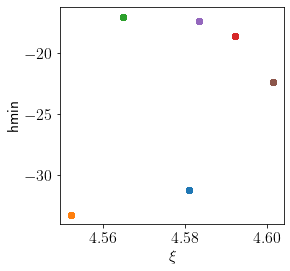

In [444]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'$\xi$',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/NegativeModulus.txt >> hmin.txt'%(mg,i))
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        ax.scatter(0.5*(sarr[:,2]+sarr[:,1]),-hmin[:,1],marker='o',label=mg)
    #
#    fig.legend()
    plt.savefig('crltnMu.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


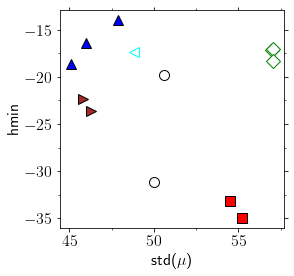

In [87]:
if not RemoteMachine:
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
    ax.set_xlabel(r'std($\mu$)',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for itimee in range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/NegativeModulus.txt'%pathh
                file1 = '%s/mu_mean_std.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    os.system('cat %s >> hmin.txt' %file0 )
                    os.system('cat %s >> mu_size.txt'%file1)
                
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        if len(sarr.shape) == 2:
            slope = -hmin[:,1]
            std_mu = sarr[:,2]
            mean_mu = sarr[:,1]
        elif len(sarr.shape) == 1:
            slope = -hmin[1]
            std_mu = sarr[2]
            mean_mu = sarr[1]

        #
        ax.plot(std_mu,slope,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%mg)
        # 
#    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
#     #
    plt.show()


## Crltns with SRO
### scatter map 

77 77


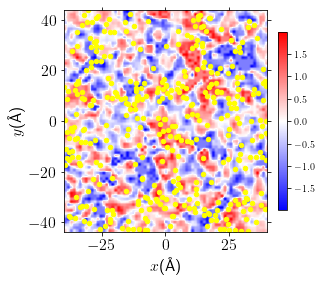

In [1299]:
if ModuAnl and not RemoteMachine:
    #--- voronoi data
#    !ovitos OvitosCna.py 'dump.xyz' 'Voronoi.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5  
#    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
#    lmpVor.GetCords( ncount = sys.maxsize)
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    atomm, box0, 'C66',
                    vor,
                    Plot = True,
                    title='mapCxyxySro.png'
                   )

### scatter mu and sro

InputFile= junk.xyz
num_frames= 1
frame=0


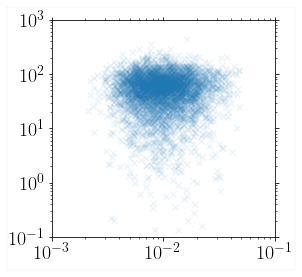

In [1300]:
if ModuAnl and not RemoteMachine:

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #--- density of SROs: see PRB draft
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    atomm.tmp = atomm.C66
    #
    ScatterXY(  vor, atomm,
                Plot = True, 
                PLOT_AVERAGE = None,
                xlim=np.array([1e-3,1e-1,1e-1,1e3]),
                title = 'scatterModuRho.png',
                axisLabels=(r'$\rho_{sro}$',r'$\mu$'),
                )            


#### gr

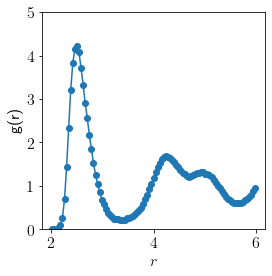

In [1301]:
if ModuAnl and not RemoteMachine:

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 100, 
                  bins=np.linspace(2.0,cutoff,100), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    #plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

    PltErr(bin_edges,hist,err,
          ylim=[0,5],
           ystr='g(r)',
           title='gr.png'
          )

#### mean mu.rho

In [1302]:
if ModuAnl and not RemoteMachine:

    #--- compute the product using the neighbor list

    icoFiltr = vor.id[ vor.tmp > 0.0 ] #--- atom id with ico. symmetry
    neigh_filtrd = FilterDataFrame(neigh,key='id',val=icoFiltr) #--- filter neighbor list

    #--- ij pairs
    atomiIds = np.array(neigh_filtrd.id)
    atomjIds = np.array(neigh_filtrd.J,dtype=int)

    # #--- product of rho and mu
    df_vor=pd.DataFrame(vor.__dict__)
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_vor_filtrd = FilterDataFrame(df_vor,key='id',val=atomiIds)
    df_mod_filtrd = FilterDataFrame(df_mod,key='id',val=atomjIds)

    x = np.array(df_vor_filtrd['tmp'])
    y = np.array(df_mod_filtrd['C66'])

#    prod = Zscore(x) * Zscore(y)
#    y=(y-y.mean())/y.mean()
#    prod = x * y

#### mean vs r.

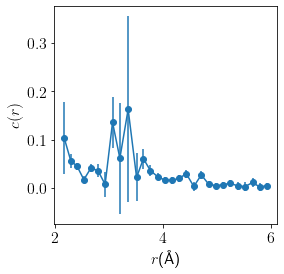

In [1304]:
if ModuAnl and not RemoteMachine:
    crltn = lp.ComputeCrltn(  atoms, box, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh_filtrd.DIST,
                    rvect = np.c_[neigh_filtrd[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
#           ylim=[-0.001,0.004],#[-.1,.3],
           title='crMuRho.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuRho.txt',np.c_[rv, hist, err],header='r\tc(r)\terr')
    

##### multiple systems

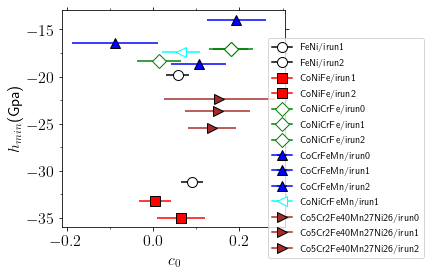

In [1042]:
if not RemoteMachine:
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
#    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
#    ax.set_ylabel(r'$c(r)$',fontsize=16)
    ax.set_ylabel(r'$h_{min}$(Gpa)',fontsize=16)
    ax.set_xlabel(r'$c_0$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                             'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
#         try:
#             os.system('rm crMuRho_concat.txt')
#         except:
#             pass
#         try:
#             os.system('rm hmin.txt')
#         except:
#             pass
        #
        for itimee in [200]: #range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/crMuRho.txt'%pathh
                file1 = '%s/NegativeModulus.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    sarr = np.loadtxt(file0)
                    sarr2nd = np.loadtxt(file1)
                    #
                    xdata = sarr[:,0] #--- r
                    ydata = sarr[:,1] #--- c(r)
                    yerr = sarr[:,2]
                    #--- find min/max
                    slist = list(zip((ydata),range(len(ydata))))
                    slist.sort(reverse=True)
                    (junk,indx0)=slist[0]
                    indx0 = 0
                    ydata0 = ydata[indx0]
                    yerr0 = yerr[indx0]
                    #
                    slope = -sarr2nd[1]
                    #
                    attrs={ 'color':color,
                            'markersize':10,
                            'marker':marker,
                            'markerfacecolor':fillstyle,
                            'markeredgecolor':'black' if not fillstyle else None,
                            'label':'%s/irun%s'%(mg,irun),
                          }
                        
                    PltErr(ydata0,slope, err=None,      
#                           xlim=[-.1,.3],
                           title='crMuRho.png',
                           ax = ax,
                           attrs = attrs,
                           xerr=yerr0,
                          )
    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
    plt.show()


### kde

(nx,ny,nz)= (77, 69, 77)
77 77


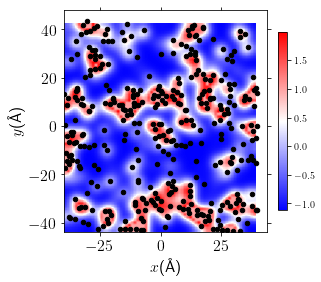

rho.shape= (77, 69, 77)


In [551]:
if ModuAnl and not RemoteMachine:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    mapp = lp.Map( vor, box ) 
    mapp.ChangeBasis()
    mapp.Set( vor ) #--- atoms: add mapped xyz
    #--- filter icosahedral atoms
    icoFiltr = GetFullIcosahedra( vor )
    #--- kde density
    rho = DensityMap(vor, icoFiltr, xlin, ylin, zlin )
    print('rho.shape=',rho.shape)

#### cross crltn

In [527]:
if ModuAnl and not RemoteMachine:

    mu_reshaped = np.array(mu_intrp.C66).reshape(xv.shape)
    print('mu.shape=',mu_reshaped.shape)

    (nx,ny,nz)=list(map(len,[xlin, ylin, zlin]))

    rhoq = np.fft.fftn( Zscore( rho ) )
    muq = np.fft.fftn( Zscore( mu_reshaped ) ) #mu_reshaped ) )

    crq=rhoq.conjugate() * muq
    cr = np.fft.ifftn(crq) / (nx*ny*nz)

    assert np.abs(cr.imag).max() < 1.0e-10, 'inverse is not real!'


mu.shape= (77, 69, 77)


#### Plot

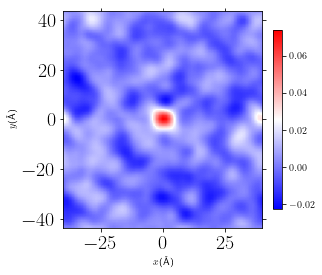

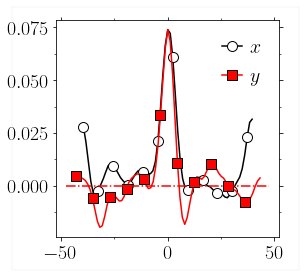

In [549]:
if ModuAnl and not RemoteMachine:

    cr_shift = np.fft.fftshift(cr)

    val = cr_shift[:,:,int(nz/2)]
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )

    PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = None,
                  frac = 1.0, #--- plot a patch
                  title = 'crMapModu.png',
                  colorbar=True,
                )
    
    PltCrltnFunc(   cr, 
                     xv,yv,
                     fileName = 'crxyModu.png',
                     title = '', #r'$\gamma=%3.2f$'%(ebulk),
                     cTOL = 1.0e-2,
                     dpi = 150,
                     symmetry = False,
                    )

In [676]:
# def GetSroDensity(vor,box):
#         indices = GetFullIcosahedra( vor )

        
#         #--- output dump file (apply filtering), run ovitos
#         atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
#         #
#         wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
#         wdf.Write('junk.xyz')
#         #--- load to ovitos
#         rad1=0.0#AtomicRadius[1]
#         rad2=0.0#AtomicRadius[2]
#         rad3=0.0#AtomicRadius[3]
#         rad4=0.0#AtomicRadius[4]
#         rad5=0.0#AtomicRadius[5]
#         !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
#         #--- read from ovito output
#         lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
#         lmpDataFiltrd.GetCords( ncount = sys.maxsize )
#         #
#         vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
#         x = 1.0/np.array(vorFiltrd.AtomicVolume)
        
#         return indices, x
    
# def sroDensityField( d2min, box, attr, vor,
#                     AtomicRadius,     
#                   Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
#                  axisLabels = True,
#                  **kwargs,
               
#                 ):
        
#         icoFiltr, icoRho = GetSroDensity(vor,box) #--- icoFiltr: true if atom has icosahedral symmetry
        
#         #--- filter d2min        
#         y = lp.Atoms(**pd.DataFrame(d2min.__dict__)[icoFiltr].to_dict(orient='series'))
#         y = np.array(y[attr])

#         #--- filter atoms
#         assert icoRho.shape == y.shape
        
#         icoRho = icoRho[y>0.0]
#         y = y[y>0.0]
        
#         #--- cross crltn.
#         x = icoRho
#         if 'zscore' in kwargs and kwargs['zscore']:
#             x = Zscore(x)
#             y = Zscore(y)
        
#         crs[itimee] = CrssCrltn( np.log10(x.copy()), np.log10(y.copy()) )
        
#         if Plot:
#             fig = plt.figure(figsize=(4,4))
#             ax = fig.add_subplot(111)
#             #
#             ax.scatter(x,y,marker='x',alpha=0.08)
#             if PLOT_AVERAGE:
#                 xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = 8 )
#                 nevery = int(np.ceil(len(xb)/10.0))
#                 ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
#                     fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                             markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                     linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#             if 'xlim' in kwargs:
#                 ax.axis(kwargs['xlim'])
#     #        makeTickLabels(ax, x, y)
#             #
#             ax.set_yscale('log')
#             ax.set_xscale('log')
#             #
#             if axisLabels:
#                 ax.set_ylabel(r'$\mu$',fontsize=16)
#                 ax.set_xlabel(r'$\rho_{sro}$',fontsize=16)
#                 #
# #                ax.set_title(r'cxy=%3.2e'%crs[itimee],fontsize=16)
#                 #
#     #        ax.legend(frameon=False, fontsize=12)
#             #
#             ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#             DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_X=True,LOG_Y=True) 
#             #
#             plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#             plt.show()
        
#         return icoFiltr



# if DminAnalysis and VorAnl:    
    
#     #--- sro density based on voronoi volumes
#     icoFiltr = sroDensityField( 
#                         atomm, box0, 'C66',
#                         vor,
#                        AtomicRadius=AtomicRadius,
#                        Plot = True, 
#                        PLOT_AVERAGE = None,
#                        axisLabels = True,
#                        title = 'scatterMuSro.png', 
#                         zscore = None,
#                            )


## Distributions

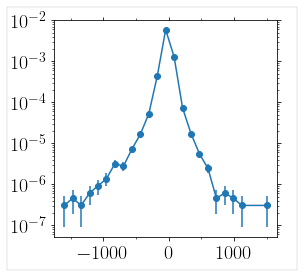

In [107]:
def Pdf( value,  label='',n_per_decade=32, Error = True, density=True, linscale=True,
             ):
    #--- size distribution
#    while True:
    hist, edges2, error = GetPDF( value, linscale = linscale, n_per_decade=n_per_decade,density=density)
    return hist, edges2, error 
    
    
if ModuAnl: # and not RemoteMachine:


    #
    hist, edges2, error =\
    Pdf( atomm.C66,#[atomm.C66>0.0], #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
         label = 'Total',
        density=True,
        linscale=True,
        n_per_decade=32,
        )
#
    PltErr(edges2,hist, 
       yerr=error, 
#       attrs = attrs,
       Plot = True,
#       xstr=r'$\mu$(Gpa)',
#       ystr=r'Histogram',
        yscale='log',
#        ylim = (1e-6,1e-1),
#        xlim = (-500,500),
        DrawFrame=(0.21,0.09,0.15,0.06,0.1),
        title='pdfMu.%s.png'%itime,

      )

    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()
#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    #--- fit        
#    x=np.linspace(-4,4,1000)
#    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #plt.plot(x,y,'.-',color='black',zorder=2)
    #
    #--- bulk strain
    ebulk = GetStrain(lmpData,itime,0)
    #
    np.savetxt('mu_mean_std.txt',np.c_[ebulk,mu,mu_std],header='strain\tmu\tmu_std')
    #
    np.savetxt('pdfMu.txt',np.c_[edges2,hist,error],header='mu\tp(mu)\terr')



### Plot multiple frames

Co5Cr2Fe40Mn27Ni26


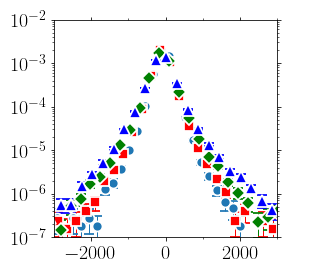

In [64]:
if not RemoteMachine:
    utl.PlotPaperVersion(3,9,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[5],
#                         xlabel=r'$\mu$(Gpa)',
#                         ylabel=r'Histogram',
                        title='pdfMu.png',
                        yscale='log',
                        ylim = (1e-7,1e-2),
                        xlim = (-3000,3000),
                        PlotMean = False,
                        times=[0,32,64,128], #np.arange(0,200+1,8),
                        timeseries=None,
                        runs=[0],
#                        legend = True,
                        DrawFrame=(0.21,0.21,0.15,0.06,0.001),
                     dpi=300,
#                     verbose=True,
                        PlotEvery=True,
                    )


### variance: multiple frames

Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26


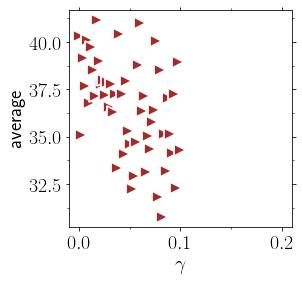

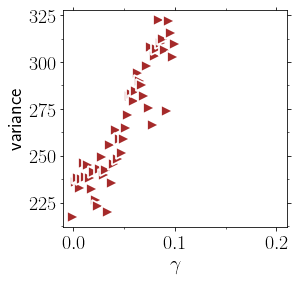

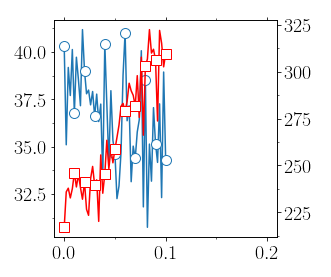

In [68]:
if not RemoteMachine:
    ax=utl.PlotPaperVersion(3,10,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[5],
                        xlabel=r'$\gamma$',
                        ylabel=r'average',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        timeseries=True,
                        times=np.arange(0,100+1,2),
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
#                        verbose=True,
                        runs=[0],
                        PlotEvery=True,
                    )

    ax2=utl.PlotPaperVersion(3,11,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[5],
                        xlabel=r'$\gamma$',
                        ylabel=r'variance',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        timeseries=True,
                        times=np.arange(0,100+1,2),
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
#                        verbose=True,
                        runs=[0],
                        PlotEvery=True,
                     )

#     #--- fetch data
    ydata = ax.lines[0].get_ydata() #list(map(lambda x:ax.lines[x].get_ydata()[0],range(len(ax.lines))))
    ydata2 = ax2.lines[0].get_ydata() #list(map(lambda x:ax2.lines[x].get_ydata()[0],range(len(ax2.lines))))
    xdata = ax.lines[0].get_xdata() #list(map(lambda x:ax.lines[x].get_xdata()[0],range(len(ax.lines))))

#    print(ydata)
    attrs={ 
    #        'alpha':0.5,
            'fmt':'-o',
             'markersize':10,
             'color':'C0',
              'markerfacecolor':'white',
              'markeredgecolor':'C0',
              'markevery':int(len(xdata)/10.0),
    #          'linewidth':3,

           }
    #--- 1st plot 
    ax=None
    ax=PltErr(xdata,ydata, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
          )
    #

    #--- 2nd plot
    attrs={ 
    #        'alpha':0.5,
            'fmt':'-s',
             'markersize':10,
             'color':'red',
              'markerfacecolor':'white',
              'markeredgecolor':'red',
              'markevery':int(len(xdata)/10.0),
    #          'linewidth':3,

          }
    kwargs = {
            'DrawFrame':(0.21,0.21,0.15,0.06,0.001),
           'xlim':(-0.01,0.21),
    #       'ylim':(-0.5,2.5),
            'title':'varMu.png',
            'dpi':300,
             }

    PltErr(xdata,ydata2,
           yerr=None, 
           attrs = attrs,
           Plot = True,
           ax = ax,
           twinx = True,
           **kwargs
          )    

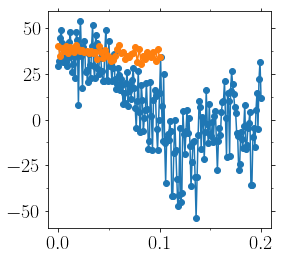

In [69]:
if ModuAnl and not RemoteMachine:
    xarray=np.loadtxt('./loadCurve.txt')
    #ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
    ax=PltErr(xarray[:,0],np.gradient(xarray[:,1],xarray[:,0]),Plot=False)
    PltErr(xdata,ydata,
    #       ylim=[0,30],
           ax=ax,
           Plot=False)


<AxesSubplot:>

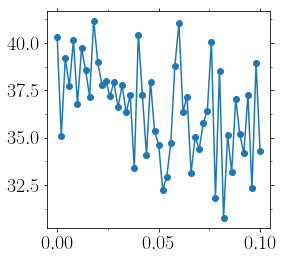

In [70]:
PltErr(xdata,ydata,
#       ylim=[0,30],
       Plot=False)


### scale dependence
#### partition

In [527]:
if ModuAnl and not RemoteMachine:
    #--- length scales
    nn=[list(set(np.logspace(5,1,16,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int)))
       ][0]
    nn.sort()
    nn=nn[:-1][:-1]

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    rsub = [
            [10.0,15.0],
            list(map(lambda x: box0.CellVector[0,0]/x,nn))
           ][0]
    print('rsub=',rsub)
    rsub = rsub
    # #--- composition and pressure fluctuations
    # cplist = list(map(lambda x: GetPressComp( atoms,box, x ), rsub))



rsub= [39.9617, 26.641133333333332, 19.98085, 15.98468, 13.320566666666666, 11.41762857142857, 9.990425, 7.99234, 6.660283333333333, 5.328226666666667, 4.440188888888889, 3.632881818181818]


In [528]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    for typei in types:
        c[typei] = 1.0*np.sum(atoms.type == typei)/n

    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    nx -= 1
    ny -= 1
    nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.C66)*np.array(x.AtomicVolume)))*(1/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
    plist = list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist

if ModuAnl and not RemoteMachine:
    cplist=list(map(lambda x: GetPressComp(atomm,box0,x), rsub))

    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list


39.9617 8
26.641133333333332 27
19.98085 64
15.98468 125
13.320566666666666 216
11.41762857142857 343
9.990425 512
7.99234 1000
6.660283333333333 2028
5.328226666666667 3840
4.440188888888889 6498
3.632881818181818 11638


##### Plot

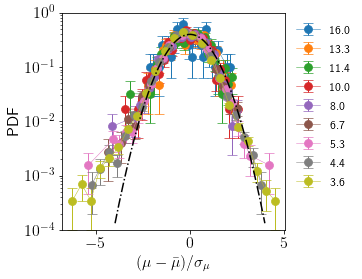

In [645]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim(1e-4,1)
    # ax.set_xlim(1e-2,1e4)
    #ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
    ax.set_xlabel([r'$(\mu-\bar{\mu})/\sigma_\mu$',r'$\mu$(Gpa)'][0],fontsize=16)
    ax.set_ylabel(r'PDF',fontsize=16)
    ax.tick_params(labelsize=16)
    #--- fit        
    x=np.linspace(-4,4,1000)
    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #
    var={}
    mean={}
    kurt = {}
    for key in list(cplist.keys())[3:]:
        slist = cplist[key][1]
        #
        var[key]=np.std(slist)
        mean[key]=np.mean(slist)
        var[key]/=mean[key]
        kurt[key] = kurtosis(slist)
        #--- rescale
        slist -= np.mean(slist)
        slist /= np.std(slist)
        #
        Pdf( slist, 
         ax,
         label = '%3.1f'%key,
         Error = True,
       )

#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    plt.plot(x,y,'-.',color='black',zorder=2)
    ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1,1))
    plt.savefig('pdfMuRescaled.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    

#### variance

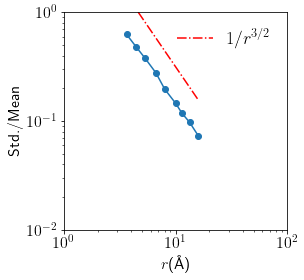

In [646]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'Std./Mean',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,1e-2,1e0])
    #ax.axis([1e0,1e3,1e-3,1e0])
    PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(var.keys()),list(map(var.get,var.keys())),'-o')
    #
    xx=np.array(list(var.keys()))
    xx.sort()
    ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('var.png',dpi=75,bbox_inches='tight')
    plt.show()

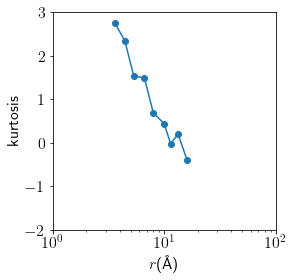

In [647]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'kurtosis',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,-2,3])
    #PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(kurt.keys()),list(map(kurt.get,kurt.keys())),'-o')
    #
    # xx=np.array(list(var.keys()))
    # xx.sort()
    # ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    #ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('kurt.png',dpi=75,bbox_inches='tight')
    plt.show()

## cluster analysis

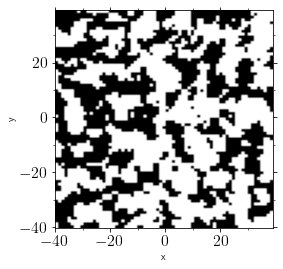

value.shape= (77, 69, 77)
p= 0.5014189649988634


cls_id           size        rg_sq  percTrue
0       1.0  308131.128655  1819.633471       1.0
178   179.0      31.614464     3.646900       0.0
72     73.0      18.065408     2.041911       0.0
253   254.0      16.559957     1.469082       0.0
85     86.0      15.054507     1.656031       0.0
..      ...            ...          ...       ...
103   104.0       1.505451     0.000000       0.0
104   105.0       1.505451     0.000000       0.0
105   106.0       1.505451     0.000000       0.0
106   107.0       1.505451     0.000000       0.0
265   266.0       1.505451     0.000000       0.0

[266 rows x 4 columns]

In [19]:
if ModuAnl:# and not RemoteMachine:

     #-----------------
     #--- INTERPOLATE
     #-----------------
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = Intrp(atomm, box0, 'C66',
                Plot = None,
               )
    mu=(atomm.C66).mean() 
    mu_std=(atomm.C66).std()

    value = PltBinary(
                        xlin,ylin,zlin, mu_intrp.C66,
                        box0,
                        0.0, #--- threshold
                        cmap='Greys',
                        title='ModuAnl/negative_mu.%s.png'%itime,
                        zscore=False,
                        #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )
    print('value.shape=',value.shape)
    
    #---------------------
    #--- cluster analysis
    #---------------------
    mask = value<0.0 #--- threshold
    print('p=',np.sum(mask)/value.size)
    
    stats = Stats(mask, xlin, ylin, zlin)
    stats.GetSize()
    display(stats.stats)
    
    #--- save
    np.save('ModuAnl/negative_mu',mask)
    np.savetxt('ModuAnl/xlin.txt',np.c_[xlin,],header='xlin')
    np.savetxt('ModuAnl/ylin.txt',np.c_[ylin,],header='ylin')
    np.savetxt('ModuAnl/zlin.txt',np.c_[zlin,],header='zlin')
    
    

    

In [1002]:
# val = mask0 #[:,:,0]
# label_im, nb_labels = ndimage.label(val)
# sliced=ndimage.find_objects(label_im)#,max_label=0)

# for xlabel in [9,20]: #np.arange(1, nb_labels+1):
# #    print('label=',xlabel)
#     assert xlabel > 0
#     sliceX = sliced[xlabel-1][1]
#     sliceY = sliced[xlabel-1][0]
#     slicez = sliced[xlabel-1][2]
#     (yc,xc,zc) = ndimage.measurements.center_of_mass(val, label_im,[xlabel])[0]
#     #sliceZ = sliced[0][2]
#     print(xc,yc,zc)

#     (ny,nx,nz) = val.shape
#     xv,yv,zv=np.meshgrid(range(nx),range(ny),range(nz))
#     print('xc=',ndimage.mean(xv, label_im, [xlabel])[0])
#     print('yc=',ndimage.mean(yv, label_im, [xlabel])[0])
#     print('zc=',ndimage.mean(zv, label_im, [xlabel])[0])
#     print('varx=',ndimage.variance(xv, label_im, [xlabel])[0])
#     print('vary=',ndimage.variance(yv, label_im, [xlabel])[0])
#     print('varz=',ndimage.variance(zv, label_im, [xlabel])[0])

#     ones = np.ones(nx*ny*nz).reshape(ny,nx,nz)
#     print('label=',xlabel,'size=',ndimage.sum(ones, label_im, [xlabel])[0])


#     im3=plt.imshow(val,cmap='Greys',origin='lower')

#     #--- rectangle
#     plotxlim=im3.axes.get_xlim()
#     plotylim=im3.axes.get_ylim()
#     plt.plot([sliceX.start, sliceX.start, sliceX.stop, sliceX.stop, sliceX.start],
#                      [sliceY.start, sliceY.stop, sliceY.stop, sliceY.start, sliceY.start],
#                      color="red")
#     plt.xlim(plotxlim)
#     plt.ylim(plotylim)
#     plt.plot(xc,yc,'s')
#     plt.show()


5.642857142857143 0.35714285714285715 21.928571428571427
xc= 5.642857142857143
yc= 0.35714285714285715
zc= 21.928571428571427
varx= 1.2295918367346939
vary= 0.3724489795918367
varz= 1.9234693877551017
label= 9 size= 14.0
15.8125 3.1875 28.4625
xc= 15.8125
yc= 3.1875
zc= 28.4625
varx= 6.20234375
vary= 4.32734375
varz= 2.648593749999999
label= 20 size= 80.0


### parse bitmaps: multiple strains

In [266]:
def PrintvarTemporal(xpath,filee,x, header):
        os.system('mkdir -p %s'%xpath)
        np.savetxt('%s/%s'%(xpath,filee),x,header=header)

        
if ModuAnl and not RemoteMachine:
    try:
        !rm ModuAnl/percCluster.xyz ModuAnl/everyCluster.xyz ModuAnl/*.png
    except:
        pass
    #---
    indxxxx = 0
    Plot = [True,False][0]
    pathh='./ElasticityT300/%s'%{0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    times = np.arange(0,201,2)
    runs = [0,1,2]
    nave = 5
#    masks = []
    #---
    for irun in runs:
        for itimee, counter in zip(times,range(len(times))): #--- read 3d matrix
            try:
                mask0 = np.load('%s/itime%s/Run%s/ModuAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
                
                #
                if counter % nave == 0: #--- for printing only: average every nave
                    if counter != 0:
                        assert len(masks) == nave
                        mask_acc=np.any(masks,axis=0)

                    masks = [] #--- reset 
                #---
                masks += [mask0] #--- concat
                

                #--------------------------
                #--- statistics
                #--------------------------
                df_cls = GetClsSize(mask0, xlin, ylin, zlin)
                percCount = df_cls[df_cls['percTrue']==True].shape[0]
                pinf =  1.0*percCount/df_cls.shape[0]
                (ny,nx,nz) = mask0.shape
                nsize = nx*ny*nz
                p =  1.0*mask0.sum()/nsize #--- occupation prob.
                try:
                    p_acc =  1.0*mask_acc.sum()/nsize #--- occupation prob.
                except: 
                    pass
                #--- <s^2>/<s>
                smean = (df_cls['size']*df_cls['size']).sum()/df_cls['size'].sum()
                #--- correlation length
                crltnl_sq = 2*(df_cls['rg_sq']*df_cls['size'] * df_cls['size']).sum()/\
                              (df_cls['size'] * df_cls['size']).sum()

                #--------------------------
                #--- plot
                #--------------------------
                conds = counter % nave == 0 and counter != 0 #np.abs(p-0.134)/p <= 1.0e-2 # percCount > 0:# and itimee == 60 or itimee == 0
                if conds: #--- plot in ovito
#                     #--- all clusters
#                     PrintOvito( pd.DataFrame( np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask0.flatten()],columns=['x','y','z','mass'] ), 
#                                     open( 'ModuAnl/everyCluster.xyz','a'), 
#                                     footer = 'ITIME=%s'%p, #(GetStrain(lmpData,itimee*10000,0)),
#                                     attr_list=['x','y','z','mass'] )

#                     #--- percolating cluster
#                     if percCount > 0:
#                         label_im, nb_labels = ndimage.label(mask0)
#                         label = df_cls[df_cls['percTrue']==True]['cls_id'].iloc[0]
#                         filtr = label_im == label
#                         tmp = np.zeros(mask0.shape)
#                         tmp[filtr] = 1.0
#                         PrintOvito( pd.DataFrame( np.c_[xv.flatten(),yv.flatten(),zv.flatten(),tmp.flatten()],columns=['x','y','z','mass'] ), 
#                                         open( 'ModuAnl/percCluster.xyz','a'), 
#                                         footer = 'ITIME=%s'%itimee,
#                                         attr_list=['x','y','z','mass'] )

#                     junk = PltBinary(
#                                         xlin,ylin,zlin, (~mask_acc).flatten().astype(int),
#                                         box0,
#                                         0.5, #--- threshold
#                                         cmap='Greys',
#                                         title='ModuAnl/negative_mu_%s.png'%itimee,
#                                         zscore=False,
#                                         DrawFrame=(0.17,0.17,0.15,0.06,0.1),
#                                         xlabel = '', ylabel = '',
#                                         labels = True,
#                                         fontsize=18,
#                                      )

                    print('itime=%s,gamma=%s,p=%s,percCount=%s'
                          %(itimee,GetStrain(lmpData,itimee*10000,0),p_acc,percCount))




            except:
                traceback.print_exc()
                continue

rm: ModuAnl/percCluster.xyz: No such file or directory
rm: ModuAnl/everyCluster.xyz: No such file or directory
rm: ModuAnl/*.png: No such file or directory
itime=10,gamma=0.010000000000000035,p=0.2516982358879592,percCount=0
itime=20,gamma=0.02000000000000007,p=0.2547683823799013,percCount=0
itime=30,gamma=0.029999999999999943,p=0.26132177628507386,percCount=0
itime=40,gamma=0.03999999999999998,p=0.2667263096399178,percCount=0
itime=50,gamma=0.05000000000000002,p=0.28395677351069787,percCount=0
itime=60,gamma=0.06000000000000005,p=0.30803395738460676,percCount=0
itime=70,gamma=0.07000000000000008,p=0.3232991363990799,percCount=0
itime=80,gamma=0.07999999999999996,p=0.3617150776947502,percCount=1
itime=90,gamma=0.09000000000000001,p=0.39522269561795254,percCount=2
itime=100,gamma=0.10000000000000003,p=0.4199134199134199,percCount=2
itime=110,gamma=0.11000000000000007,p=0.45458212030769907,percCount=3
itime=120,gamma=0.11999999999999997,p=0.4497080183133261,percCount=1
itime=130,gamma=0.

### stats

In [38]:
def Wrapper(pathh, lmpData, itime):
    #---
    try:
        stats = Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                         xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                         ylin=np.loadtxt('%s/ylin.txt'%pathh),
                         zlin=np.loadtxt('%s/zlin.txt'%pathh),
                        )
        stats.GetSize()
    #    display(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()    
        #--- print pinf on disc
        stats.Print( pathh, #--- path
                    'pinf.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.pinf], #--- vals
                    '\gamma\tp\tpinf', #--- header
                        )
        #--- print <S>
        stats.Print(pathh, #--- path
                    'muClustersize_gamma.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.smean],
                    header='gamma\tp\t<S>')
        #--- print correlation length
        stats.Print(pathh, #--- path
                    'crltnl_gamma.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.si_sq**0.5],
                    header='gamma\tp\tsi')
        #--- size distributions
        hist, edges, error = GetPDF( stats.stats['size'].astype(float),n_per_decade=8)
        #
        np.savetxt('%s/ps.txt'%pathh,
                   np.c_[edges,hist,error],
                   header='s\tp(s)\terror')
        #--- radius of gyration
        filtr = stats.stats['rg_sq'] > 0.0
        x,y=stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr]    
        stats.Print(pathh, #--- path
                    's_rg.txt',
                    np.c_[x,y],
                    header='rg\ts')
    except:
        traceback.print_exc()
        pass
if ModuAnl and not RemoteMachine:
    
    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3',7:'Co5Cr2Fe40Mn27Ni262nd'}[5]
    runs = [0]#,1,2]
    times = np.arange(0,101,4)
    #---
    x, y = np.meshgrid(runs,times) #--- different realizations and times
    list(map(lambda x: Wrapper( './ElasticityT300/%s/eps6/itime%s/Run%s/ModuAnl'%(mg,x[1],x[0]), lmpData, x[1] ), zip(x.flatten(),y.flatten()) ))

In [418]:
def Wrapper(pathh):
    stats = Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                     xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                     ylin=np.loadtxt('%s/ylin.txt'%pathh),
                     zlin=np.loadtxt('%s/zlin.txt'%pathh),
                    )
    stats.GetSize()
    #display(stats.stats)
    filtr = stats.stats['rg_sq'] > 0.0
#     plt.scatter(stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr])
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()

    x,y=stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr]
    df=np.polyfit(np.log10(x.tolist()),np.log10(y.tolist()),deg=1)[0]
    return df

if ModuAnl and not RemoteMachine:

    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[4]

    df=list(map(lambda x: Wrapper( './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x,1)),np.arange(0,202,2)))

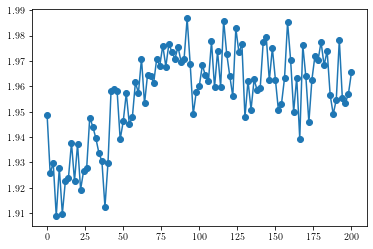

In [419]:
#plt.plot(np.arange(0,202,2),df,'-o')
#plt.show()

### timescale

<AxesSubplot:xlabel='$t$', ylabel='$c(t)$'>

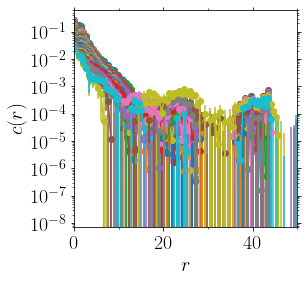

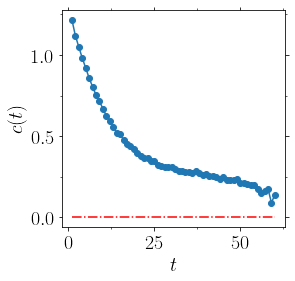

In [314]:
def TwoPointCrltn( pathi, pathf, plot = False, verbose=False ):
    if verbose: 
        print(pathi, pathf)
    maski = np.load('%s/negative_mu.npy'%pathi)
    maskf = np.load('%s/negative_mu.npy'%pathf)
    
    #--- zscore
    maski = Zscore(maski.astype(float))
    maskf = Zscore(maskf.astype(float))
    #--- fft
    maskiq = np.fft.fftn(maski)
    maskfq = np.fft.fftn(maskf)
    #--- crltn
    cr = np.fft.ifftn(maskiq.conjugate()*maskfq).real/maski.size
    #--- shift
    cr_shift = np.fft.fftshift(cr)
    #--- plot
    if plot:
        ny,nx, nz = maski.shape
        val = cr_shift[:,:,int(nz/2)]

        ax=plt.imshow(val)
        plt.colorbar(ax)
        plt.show()
    #---
    return cr_shift

def GetPairs(Ti,Tf,ishift):

    t=np.arange(Ti, Tf+2,2) #--- time sequence
#    print(t)
    n=len(t)
    return n-1, list(zip(t[:n-ishift],t[ishift:n]))


def Wrapper(Ti,Tf,ishift,verbose=False):
    maxshift, dt = GetPairs(Ti,Tf,ishift) #--- pairs
    if verbose:
        print('pairs=',dt)
    crs=list(map(lambda x:TwoPointCrltn(
                './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x[0],0),
                './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x[1],0), verbose=verbose,
                ),dt))
    crs_sq = list(map(lambda x:x*x,crs))
#    crs = [np.array([0,1,2]),np.array([3,4,5])]
    #--- average
    npair = len(crs)
    xmean = reduce(lambda x,y:x+y,crs)/npair
    x2 = reduce(lambda x,y:x+y,crs_sq)/npair
#    pdb.set_trace()
    x2 = x2-(xmean * xmean)
    assert not np.any(np.isnan(x2)), 'isnan=True!'
    assert np.all(x2>=0.0), '<x2> is negative!'
    xstd = x2**0.5
    if verbose:
        print('pairs=',dt)
        print('n=',npair)
    return ishift, [xmean, 1.0*xstd/npair**0.5]

def Binning(pathi,val,bins):
    xlin=np.loadtxt('%s/xlin.txt'%pathi)
    ylin=np.loadtxt('%s/ylin.txt'%pathi)
    zlin=np.loadtxt('%s/zlin.txt'%pathi)
    #---
    xv,yv,zv=np.meshgrid(xlin,ylin,zlin)
    (ny,nx,nz)=xv.shape
    assert val.shape==(ny,nx,nz)
    #--- center
    xv -= xv[int(ny/2),int(nx/2),int(nz/2)]
    yv -= yv[int(ny/2),int(nx/2),int(nz/2)]
    zv -= zv[int(ny/2),int(nx/2),int(nz/2)]
    rsq = xv*xv+yv*yv+zv*zv
    #--- binning
    r = (rsq**0.5).flatten()
    value = val.flatten()
    #
    count, bin_edges = np.histogram(r,bins=bins)
    rsum, bin_edges = np.histogram(r,bins=bins,weights=r)
    vsum, bin_edges = np.histogram(r,bins=bins,weights=value)
    v2sum, bin_edges = np.histogram(r,bins=bins,weights=value*value)

    #
    vsum /= count
    v2sum /= count
    rsum /= count
    #--- error
    v2sum -= vsum * vsum
    return rsum, vsum, (v2sum/count)**0.5

if ModuAnl and not RemoteMachine:

    # # #--- 75%
    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[5]
    # ti = 10
    # tf = 10
    # cr = TwoPointCrltn(
    #             './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,ti,0),
    #             './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,tf,0)
    #             )


    (Ti, Tf)=(100-60, 100+60) #--- temporal window
    maxshift, dt = GetPairs(Ti,Tf,0)

    #----------------------------
    #--- c = mu(r,t).mu(r',t')
    #----------------------------
    cr_dict = dict(list(map(lambda x:Wrapper(Ti,Tf,x,verbose=False),range(1,maxshift+1)))) #--- key: t-t', val = mu(r,t).mu(r',t')

    #--- plot
    # key = 0
    # cr_shift = cr_dict[key][0]
    # ny,nx, nz = cr_shift.shape
    # val = cr_shift[:,:,int(nz/2)]
    # #
    # PltBitmap( val,
    #               xlabel = 'x', ylabel = 'y',
    # #                  xlim = (-0.5,0.5), ylim = (-0.5,0.5),
    #               frac = 0.4, #--- plot a patch
    #               zscore = False,
    #               title = 'cxy.png',
    #               colorbar=True,
    #               vmin = -0.01,
    #               vmax=0.3,
    #              )

    #--- c(tau) @ r=0
    # xdata = list(map(lambda x:x,cr_dict.keys()))
    # ydata = list(map(lambda x:cr_dict[x][0][int(ny/2),int(nx/2),int(nz/2)],cr_dict.keys()))
    # yerr = list(map(lambda x:cr_dict[x][1][int(ny/2),int(nx/2),int(nz/2)],cr_dict.keys()))

    # PltErr(xdata,ydata,
    #        yerr=yerr,
    #       xstr='$t$',
    #       ystr='$c(t,r=0)$'
    #       )

    #----------------------------
    #--- isotropic part: c(r,t)
    #----------------------------
    pathi = './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,0,0) #--- initial grid only!
    data = list(map(lambda x: Binning(pathi,cr_dict[x][0],128),cr_dict.keys()))
    # plot
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    list(map(lambda x:PltErr(x[0],x[1],
           yerr=2*x[2],
          xstr='$r$',
          ystr=r'$c(r)$',
            Plot=False,
           ax=ax,
           xlim=(0,50),
           yscale='log',
          ),data))



    #----------------------------
    #--- int c(r,t) dr
    #----------------------------
    c=list(map(lambda x:(np.sum(x[1])*(x[0][1]-x[0][0])),data)) #--- x[1]: c(r) x[0]:r
    t=list(map(lambda x:x,cr_dict.keys()))
    #--- plot
    ax=PltErr(t,c,
    #           yerr=2*yerr,
              xstr='$t$',
              ystr=r'$r(t)$',
                Plot=False,
        #       ax=ax,
    #           xlim=(0,10),
    #           yscale='log',
    #            ax=ax,
              )
    PltErr([np.min(t),np.max(t)],[0,0],
    #           yerr=2*yerr,
              xstr='$t$',
              ystr=r'$c(t)$',
                Plot=False,
               ax=ax,
              attrs={'fmt':'-.r'},
    #           xlim=(0,10),
    #           yscale='log',
    #            ax=ax,
              )

### other statistics


#### fraction p

Co5Cr2Fe40Mn27Ni26
ydata= [0.42412265 0.41816569 0.414328   0.42217936 0.42471908 0.41719526
 0.4205954  0.42657681 0.41177851 0.42663303 0.42330378 0.41874989
 0.42285646 0.42621015 0.44302996 0.42330378 0.43342109 0.4195101
 0.42508574 0.42358488 0.43647412 0.42898209 0.41686038 0.42545728
 0.41780881 0.41629084]
plot irun=0,len(ax.lines)=0
Co5Cr2Fe40Mn27Ni26
ydata= [0.42412265 0.41816569 0.414328   0.42217936 0.42471908 0.41719526
 0.4205954  0.42657681 0.41177851 0.42663303 0.42330378 0.41874989
 0.42285646 0.42621015 0.44302996 0.42330378 0.43342109 0.4195101
 0.42508574 0.42358488 0.43647412 0.42898209 0.41686038 0.42545728
 0.41780881 0.41629084]
plot len(ax.lines)=0


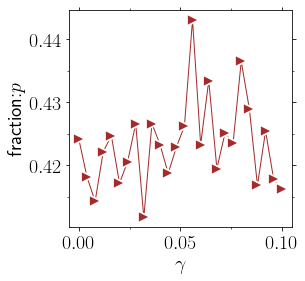

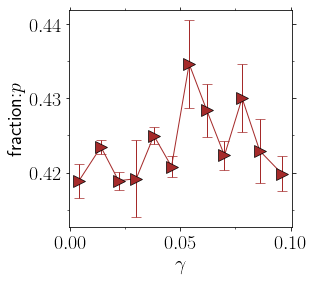

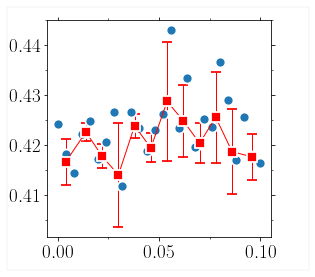

In [40]:
if ModuAnl and not RemoteMachine:
    indxxxx=5
    ax_s = utl.PlotPaperVersion(4,13,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'Co5Cr2Fe40Mn27Ni262nd'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'fraction:$p$',
                        PlotEvery = True,
                        timeseries = True,
#                        title='fraction.png',
#                        ylim=(35,70),
#                        xlim=(-0.01,.21),
#                        PlotMean = True,
#                        legend = True,
#                        yscale='log',
                        runs=[0],#,1,2],
                        times = np.arange(0,101,4),
                        fmt='-',
                        verbose=True,
                    )
    
#     #--- get scatter data
    ax_m = utl.PlotPaperVersion(4,13,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'fraction:$p$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=[0],#,1,2],
                    times = np.arange(0,101,4),
                    verbose=True,
                )
    
    Pltt(ax_s,ax_m,
         indices=[0],#,5,10],
#          yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
#          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/p_gamma.png',
#         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )

In [41]:
np.savetxt('p_gamma_T_64.txt',np.c_[ax_s.lines[0].get_xdata(),ax_s.lines[0].get_ydata()])

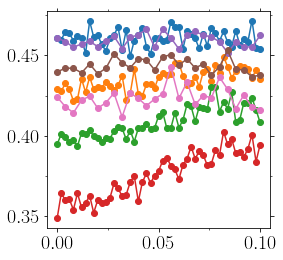

In [42]:
for i in [1,2,4,8,16,32,64]:
    sarray = np.loadtxt('p_gamma_T_%s.txt'%i)
    if i == 1: 
        kwargs={}
    else:
        kwargs={'ax':ax}
    ax=PltErr(sarray[:,0],sarray[:,1],**kwargs,Plot=False)

#### crltn length

Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
ydata= [60.01005304 60.13082054 60.09825433 60.09355725 59.78333928 60.07260193
 60.02490748 59.64955738 59.98922622 59.95274453 60.04937291 60.12768083
 59.60055313 59.88001859 59.84509949 60.34620277 59.93160622 59.99147484
 60.46124897 60.35064739 59.97491419 60.18966874 60.02678114 60.4020418
 60.26968156 60.42911254 60.16867628 60.06941221 60.43234559 60.00037068
 60.02266108 59.83093656 59.86915589 59.81948256 59.76125625 60.20862137
 59.78849624 59.86408961 59.93141332 60.24092591 59.69892594 60.52143621
 59.88687744 59.94944365 59.09878632 59.79137974 60.09438291 59.68783256
 59.5987027  60.19285322 59.49567733]
plot irun=0,len(ax.lines)=0
ydata= [60.01005304 60.13082054 60.09825433 60.09355725 59.78333928 60.07260193
 60.02490748 59.64955738 59.98922622 59.95274453 60.04937291 60.12768083
 59.60055313 59.88001859 59.84509949 60.34620277 59.93160622 59.99147484
 60.46124897 60.35064739 59.97491419 60.18966874 60.02678114 

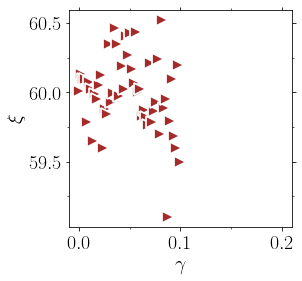

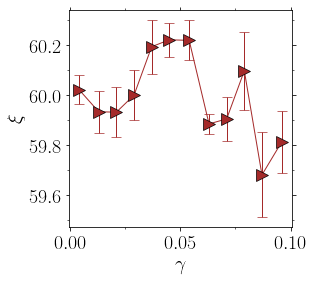

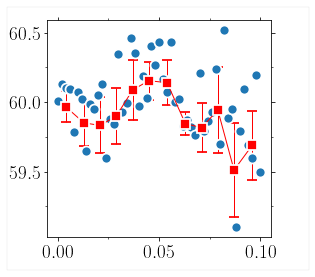

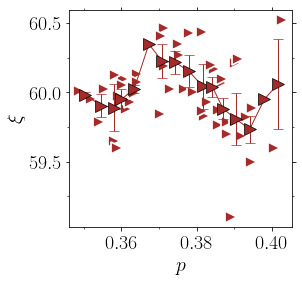

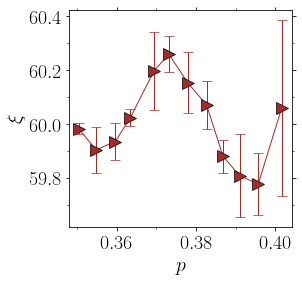

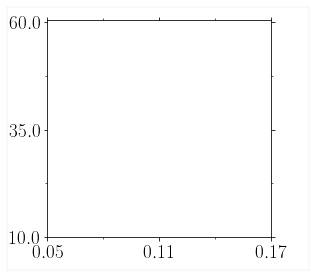

In [78]:
if ModuAnl and not RemoteMachine:
    indxxxx = 5
    ax_s0=utl.PlotPaperVersion(4,22,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$\xi$',
                    PlotEvery = True,
                    timeseries = True,
#                    title='ModuAnl/pinf.png',
#                    ylim=(1e-4,1e-2),
                    xlim=(-0.01,.21),
#                    yscale = 'log',
                    runs=[0],#,1,2],
                    times = np.arange(0,101,2),
#                    yscale='log',
#                    verbose = True,
                )
    
    ax_m0 = utl.PlotPaperVersion(4,22,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$\xi$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=[0],#,1,2],
                    times = np.arange(0,101,2),
                )
    
    Pltt(ax_s0,ax_m0,
         indices=[0],#,5,10],
#          yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
#          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/crltnl_gamma.png',
#         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )
    
#--- get scatter data
    ax_s=utl.PlotPaperVersion(4,23,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'$p$',
                ylabel=r'$\xi$',
                PlotEvery = True,
                timeseries = True,
                PlotMean = True, #--- plot average
                nbins = 16, #--- nbins
#                title='ModuAnl/pinf.png',
#                yscale = 'log',
                runs=[0],#,1,2],
                times = np.arange(0,101,2),
#                verbose = True,
            )
    
#     #--- get scatter data
    ax_m = utl.PlotPaperVersion(4,23,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$p$',
                    ylabel=r'$\xi$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=[0],#,1,2],
                    times = np.arange(0,101,2),
                )
    
    utl.Pltt(ax_s,ax_m,
         indices=[0],#,5,10],
         yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
         xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/crltnl_p.png',
         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )

##### rescaled

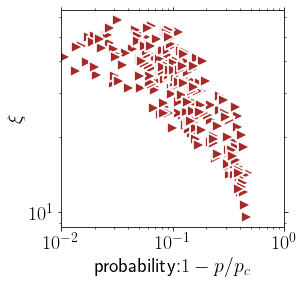

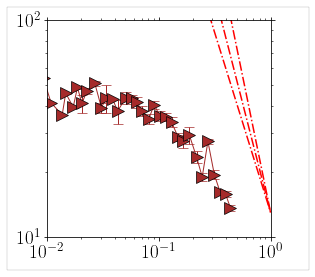

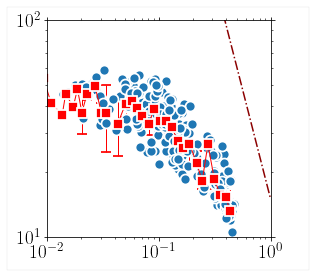

In [2280]:
if ModuAnl and not RemoteMachine:
    #--- 1st
    ax_rs = PlotPaperVersion(4,24,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'$\xi$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                     ylim=(1e-4,1e-2),
                     xlim=(1e-2,1e0),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=[0,1,2],
                    times = np.arange(0,202,2),
#                    verbose = True,
#                    pmax=0.18
                )
    #--- 2nd
    ax_rm = PlotPaperVersion(4,24,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'$\xi$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                     ylim=(1e-4,1e-2),
                     xlim=(1e-2,1e0),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 64, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=[0,1,2],
                    times = np.arange(0,202,2),
#                    verbose = True,
#                    pmax=0.18
                )
    #--- fit
    xx=np.logspace(-2,0,4)
    for alpha in [alpha_min,alpha_mean,alpha_max]:
        yy=1.3e1/xx**alpha
        PltErr(xx,yy,yerr=None,
               Plot=False,
               attrs={'fmt':'-.','color':'red'},
               fontsize=FontSize,
                title='ModuAnl/crltnl_p_rescaled.png',
                yscale='log',
                xscale='log',
                 ylim=(1e1,1e2),
                 xlim=(1e-2,1e0),
                DrawFrame=DFset,
                 ax=ax_rm)    
    #--- 3rd
    ax3=Pltt(ax_rs,ax_rm,
             indices=[0,5,10],
     xscale='log',
     yscale='log',
     ylim=(1e1,1e2),
     xlim=(1e-2,1e0),
#     title='ModuAnl/pinf_p_rescaled.png',
     fontsize=FontSize,
#    DrawFrame=DFset,
    )
    
    #--- fit
    yy=1.5e1/xx**(alpha_mean)
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/crltnl_p_rescaled.png',
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
             ax=ax3)

##### exponents

exponent= -0.8412648319184066


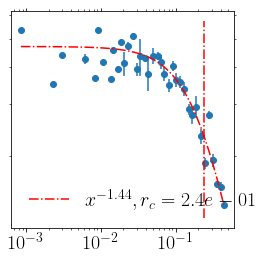

In [2281]:
def func0(x,a, alpha,rc):
    return a/(1.0+(x/rc)**alpha)
 
def func1(x, a,b):
    return b*x**a

def Wrapper(ax_h,item, Plot = True, **kwargs):
    
    #--- fetch data
    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr0 = Filtr(xdata,0.0,np.inf)    
    filtr1 = Filtr(ydata,0.0,np.inf)    
    filtr2 = Filtr(yerr,1.0e-5,np.inf)
    filtr = {0:np.ones(len(xdata),dtype=bool)*True,
             1:np.all([filtr0,filtr1,filtr2],axis=0),
             2:filtr2}[1]
#    assert np.all(ydata[filtr]>0.0),'y<=0.0!'
#    assert np.all(yerr[filtr]>0.0),'yerr<=0.0, increase bin size!'
    
    
    if not 'rc' in kwargs:
        #--- make a fit: compute rc
        popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                           p0=(50.0,2.0,0.1), #(a,alpha,rc),
                           bounds=((0.0,0.0,0.0), (np.infty,np.infty,np.infty)),    
                           sigma=yerr[filtr]
                              )
        rc = popt[2]
    
        #--- plot fit
        if Plot:
            ax = PltErr(xdata,func0(xdata,*popt), 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',
                        'label':r'$x^{-%3.2f},r_c=%2.1e$'%(popt[1],popt[2]),
                        },
                        ax=ax,
                        legend=True,
                         xscale = 'log',
                        yscale='log',
                      )        

        #--- plot rc
        if Plot:
            ax=PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',

                        },
                        ax=ax,
                         xscale = 'log',
                        yscale='log',
                        )
        
    else:
        rc = kwargs['rc']
        
    #--- filter: x>rc
    filtr = np.all([filtr,Filtr(xdata,rc,np.inf)],axis=0)
    
    #--- fit
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]
    try:
        popt, pcov = curve_fit( func1, xdata[filtr], ydata[filtr], 
                                p0=(-1.0,0.1), #(a,b),
                                bounds=((-np.infty,0.0), (0.0,np.infty)),    
                                sigma=yerr[filtr]
                                  )
    except:
        return np.nan, np.nan, np.nan
    
    return rc, popt[0], pcov[0,0]**0.5


if ModuAnl and not RemoteMachine:
    rc, alpha, err_alpha = Wrapper(ax_rm,0)
    print('exponent=',alpha)

In [2282]:
#--- vary cutoff 
rcc=np.logspace(np.log10(0.001),np.log10(1.0),32)
X = list(map(lambda x:Wrapper(ax_rm,0,Plot=False,rc=x), rcc))

exponent: 0.5328683351945822 - 1.0771718339230942


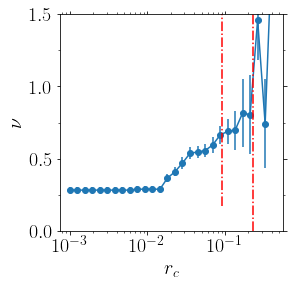

In [2283]:
#--- plot
r=np.c_[X][:,0]
nu=-np.c_[X][:,1]
yerr=np.c_[X][:,2]
ax = PltErr(r,nu, yerr=yerr,
      xstr=r'$r_c$',
      ystr=r'$\nu$',
      Plot=False,
      xscale='log',
      )

#--- bound
#--- bound
r0, r1 ={
            0:(0.15,0.4),
            1:(0.1,0.26),
            2:(0.16,0.3),
            3:(0.1,0.32),
            4:(0.03,0.12),
            5:(0.09,0.23),
        }[indxxxx]


#--- plot
for rr in [r0,r1]:
    ax = PltErr([rr,rr],ax.axis()[2:],
          Plot=False,
         ax=ax,
          xstr=r'$r_c$',
      ystr=r'$\nu$',
         attrs={'fmt':'-.r'},
         xscale='log',
         ylim=(0,1.5)
          )

#--- filter
filtr = Filtr(r,r0,r1)
alpha_min = (nu[filtr]-yerr[filtr]).min()
alpha_max = (nu[filtr]+yerr[filtr]).max()
alpha_mean = nu[filtr].mean()
print('exponent:',alpha_min,'-',alpha_max)
alpha=alpha_mean

In [2284]:
alpha

0.7522934882023182

##### print

xdata= [0.13] 
ydata= [-21.17886453] 
erry= [nan]
plot itime=0,irun=0,len(ax.lines)=0
xdata= [0.1316708] 
ydata= [-31.16022562] 
erry= [nan]
plot itime=0,irun=1,len(ax.lines)=5
xdata= [0.1323282] 
ydata= [-19.8307539] 
erry= [nan]
plot itime=0,irun=2,len(ax.lines)=10


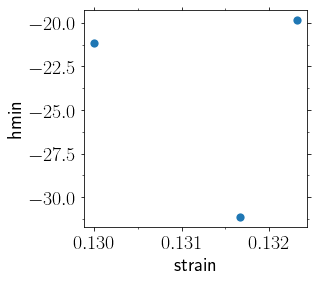

In [2150]:
#--- fetch hmin
ax = PlotPaperVersion(2,5,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'strain',
                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = False,
                runs=[0,1,2],
                times = [0],
                 verbose=True,
            )
#--- print
indices = [0,5,10] #--- set verbose=True and assign
hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
hmin = hmin[~np.isnan(hmin)]
glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
pathh='Exponents/%s'%(glass)
os.system('mkdir -p %s'%(pathh))
filee = '%s/hmin_nu_exp.txt'%pathh
np.savetxt(filee,np.c_[hmin.mean(),0.5*(alpha_max+alpha_min),hmin.std(),0.5*(alpha_max-alpha_min)],
           header='hmin\tnu\terr_hmin\terr_nu'
          )

##### scatter plot

<AxesSubplot:>

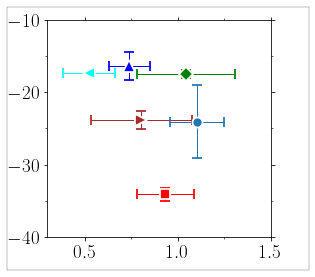

In [2153]:
PlotPaperVersion(5,26,
#                xlabel=r'$\nu$',
#                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = True,
                title='ModuAnl/hmin_nu_exp.png',
                xlim=(0.3,1.5),
                ylim=(-40.0,-10.0),
                runs=[0],
                times = [0],
                #                 legend=True,
                #                        yscale='log',
#                verbose=True,
                fontsize=FontSize,
                DrawFrame=DFset,          
                )

#### pinf

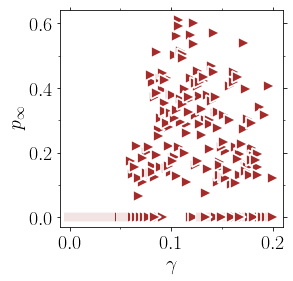

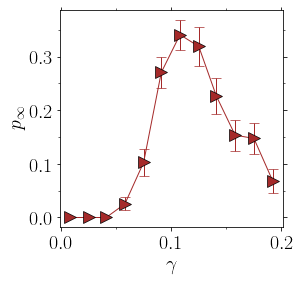

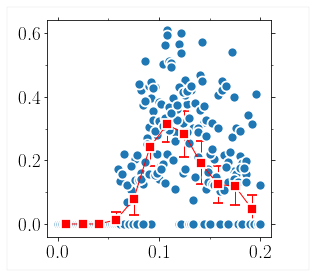

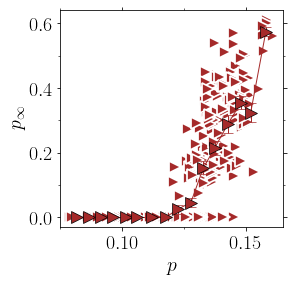

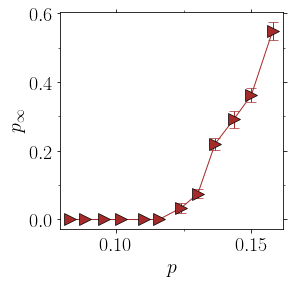

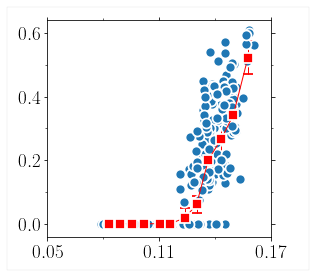

In [325]:
if ModuAnl and not RemoteMachine:
    indxxxx = 5
    runs = [0,1,2]
    #--- 1st
    ax_s0=PlotPaperVersion(4,19,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$p_\infty$',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/pinf.png',
#                    ylim=(1e-4,1e-2),
                    xlim=(-0.01,.21),
#                    yscale = 'log',
                    runs=runs,
                    times = np.arange(0,202,2),
#                    yscale='log',
                    verbose = False,
                )

    ax_m0 = PlotPaperVersion(4,19,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$p_\infty$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = np.arange(0,202,2),
                    verbose = False
                )
    Pltt(ax_s0,
         ax_m0,
         indices = [0,5,10], #--- curve index in ax_s: set verbose = True
#         yticks=(['0','0.5','1.0','1.5'],['0','0.0005','0.001','0.0015']),
#         xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/pinf_gamma.png',
#         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )
    
    #--- 2nd
    #--- get scatter data
    ax_s=PlotPaperVersion(4,20,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'$p$',
                ylabel=r'$p_\infty$',
                PlotEvery = True,
                timeseries = True,
                PlotMean = True, #--- plot average
                nbins = 16, #--- nbins
                title='ModuAnl/pinf.png',
#                yscale = 'log',
                    runs=runs,
                times = np.arange(0,202,2),
#                verbose = True,
            )
    #--- 3rd
    #--- get scatter data
    ax_m = PlotPaperVersion(4,20,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$p$',
                    ylabel=r'$p_\infty$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = np.arange(0,202,2),
                    verbose = False
                )
    #--- 4th
    Pltt(ax_s,
         ax_m,
         indices = [0,5,10], #--- curve index in ax_s: set verbose = True
#         yticks=(['0','0.5','1.0','1.5'],['0','0.0005','0.001','0.0015']),
         xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/pinf_p.png',
         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )

In [2105]:
ind = np.arange(len(ax_m.lines[0].get_ydata()))[ax_m.lines[0].get_ydata()>0][0]
pc = ax_m.lines[0].get_xdata()[ind-1]
print(pc)

0.11595099172738925


##### rescaled

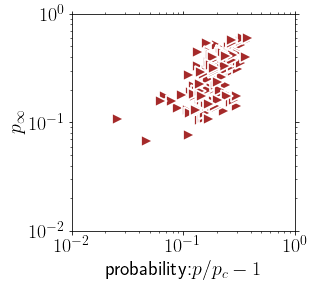

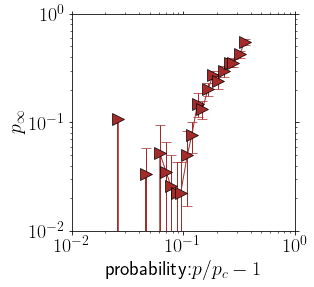

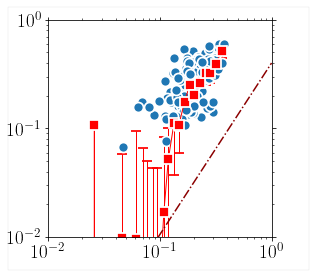

In [2257]:
if ModuAnl and not RemoteMachine:
    #--- 1st
    ax_rs = PlotPaperVersion(4,21,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p/p_c-1$',
                   ylabel=r'$p_\infty$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                     ylim=(1e-2,1e0),
                     xlim=(1e-2,1e0),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = np.arange(0,202,2),
#                    verbose = True,
#                    pc = pc,
                )
    #--- 2nd
    ax_rm = PlotPaperVersion(4,21,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p/p_c-1$',
                   ylabel=r'$p_\infty$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                     ylim=(1e-2,1e0),
                     xlim=(1e-2,1e0),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 32,#22, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = np.arange(0,202,2),
#                    verbose = False,
#                    pc = pc,
                )
    #--- 3rd
    ax3=Pltt(ax_rs,ax_rm,
     indices = [0,5,10],
     xscale='log',
     yscale='log',
     ylim=(1e-2,1e0),
     xlim=(1e-2,1e0),
     fontsize=FontSize,
    )
    #--- fit
    xx=np.logspace(-2,0,4)
    yy=.4/xx**(-alpha)
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/pinf_p_rescaled.png',
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
             ax=ax3)

##### fit powerlaw

exponent= 1.4541572773110576 - 1.6982621470009587
err= 0.12205243484495044


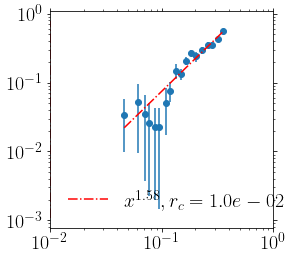

In [2254]:
def func0(x, a,b):
    return b*x**a

def Wrapper(ax_h,item, rc, Plot = True, **kwargs):
    
    #--- fetch data
    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- filter
    filtr0 = Filtr(xdata,rc,np.inf)    
    filtr1 = Filtr(ydata,0.0,np.inf)    
    filtr2 = Filtr(yerr,1.0e-5,np.inf)
    filtr = {0:np.ones(len(xdata),dtype=bool)*True,
             1:np.all([filtr0,filtr1,filtr2],axis=0),
             2:filtr2}[2]
#    assert np.all(ydata[filtr]>0.0),'y<=0.0!'
#    assert np.all(yerr[filtr]>0.0),'yerr<=0.0, increase bin size!'
    #--- Plot
    if Plot:
        ax = PltErr( xdata[filtr],ydata[filtr],
                     yerr=yerr[filtr],
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                     yscale='log',
              )
        
    
     #--- fit
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]

    #--- make a fit
    popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                            p0=(1.0,1.0), #(a,b),
                            bounds=((0.0,0.0), (np.infty,np.infty)),    
                            sigma=yerr[filtr]
                              )
        
    #--- plot fit
    if Plot:
        ax = PltErr(xdata[filtr],func0(xdata[filtr],*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[0],rc),
                    },
                    ax=ax,
                    legend=True,
                     xscale = 'log',
                    yscale='log',
                  )        

    #--- plot rc
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:],
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',

                    },
                    ax=ax,
                     xscale = 'log',
                    yscale='log',
                    xlim=(1e-2,1)
                    )    
    
    return rc, popt[0], pcov[0,0]**0.5


if ModuAnl and not RemoteMachine:
    rc, alpha, err_alpha = Wrapper(ax_rm,0,1.0e-2)
    print('exponent=',alpha-err_alpha,'-',alpha+err_alpha)
    print('err=',err_alpha)

In [2108]:
# rcc=np.linspace(1.0e-2,0.1,16)
# X = list(map(lambda x:Wrapper(ax_rm,0,x,Plot=False) , rcc))
# PltErr(np.c_[X][:,0],np.c_[X][:,1], yerr=np.c_[X][:,2],
#       xstr=r'$r_c$',
#       ystr=r'$\beta$'
#       )

##### print

xdata= [0.1203889] 
ydata= [-23.6514228] 
erry= [nan]
plot itime=0,irun=0,len(ax.lines)=0
xdata= [0.1131581] 
ydata= [-22.36639043] 
erry= [nan]
plot itime=0,irun=1,len(ax.lines)=5
xdata= [0.123885] 
ydata= [-25.47968151] 
erry= [nan]
plot itime=0,irun=2,len(ax.lines)=10


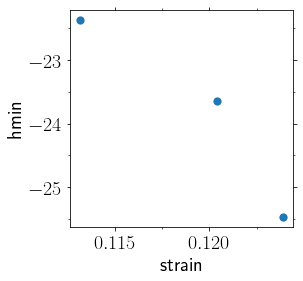

In [2109]:
#--- fetch hmin
ax = PlotPaperVersion(2,5,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'strain',
                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = False,
                runs=[0,1,2],
                times = [0],
                 verbose=True,
            )
#--- print
indices = [0,5,10] #--- set verbose=True and assign
hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
hmin = hmin[~np.isnan(hmin)]
glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
pathh='Exponents/%s'%(glass)
os.system('mkdir -p %s'%(pathh))
filee = '%s/hmin_beta_exp.txt'%pathh
np.savetxt(filee,np.c_[hmin.mean(),alpha,hmin.std(),err_alpha],
           header='hmin\tbeta\terr_hmin\terr_beta'
          )

##### scatter plot

<AxesSubplot:>

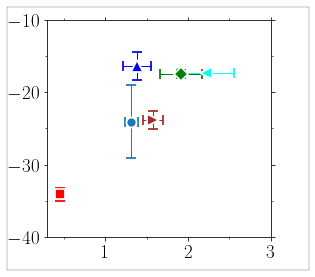

In [2110]:
PlotPaperVersion(5,27,
#                xlabel=r'$\beta$',
#                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = True,
                title='ModuAnl/hmin_beta_exp.png',
                xlim=(0.3,3.0),
                ylim=(-40.0,-10.0),
                runs=[0],
                times = [0],
                #                 legend=True,
                #                        yscale='log',
#                verbose=True,
                fontsize=FontSize,
                DrawFrame=DFset,          
                )

#### mean size


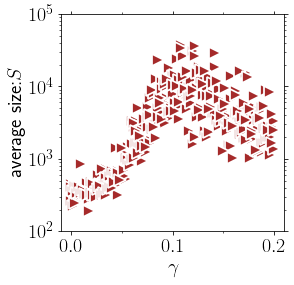

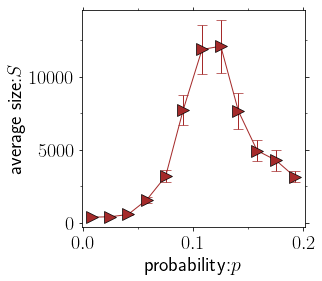

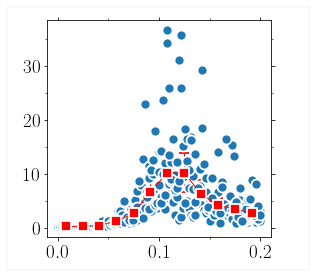

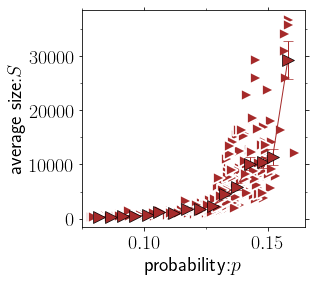

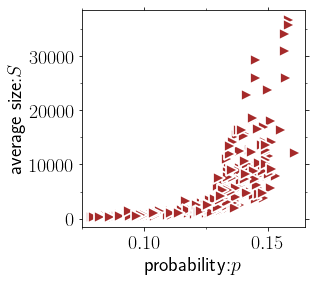

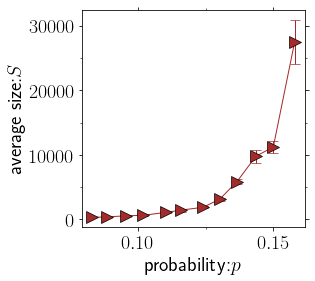

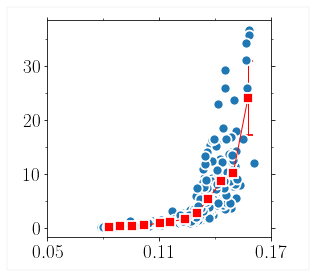

In [328]:
if ModuAnl and not RemoteMachine:
    indxxxx = 5
    runs = [0,1,2]
    times = np.arange(0,202,2)
    #--- fetch data
    ax_s0=PlotPaperVersion(4,14,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'average size:$S$',
                    PlotEvery = True,
                    timeseries = True,
#                    title='ModuAnl/mean_size.png',
                    ylim=(1e2,1e5),
                    xlim=(-0.01,.21),
                    runs=runs,
                    times = times,
                        yscale='log',
                )    

    #--- get averaged data
    ax_m0 = PlotPaperVersion(4,14,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
                    runs=runs,
                    times = times,
                )
    Pltt(ax_s0,ax_m0, indices=[0,5,10],
         title='ModuAnl/smean_gamma.png',
#         xlim=(0.05,0.17),
           yticks=(['0','10','20','30'],['0','10000','20000','30000']),
#           xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
        fontsize=FontSize,
        DrawFrame=DFset,
#        fill_between = True,
        )    

    PlotPaperVersion(4,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 16, #--- nbins
                    legend = False,
                    yscale='linear',
                    xscale='linear',
                    runs=runs,
                    times = times,
                    verbose = False,
                )
    
    #--- get scatter data
    ax_s = PlotPaperVersion(4,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    PlotMean = False,
                    runs=runs,
                    times = times,
#                    verbose=True
                ) 
    
    #--- get averaged data
    ax_m = PlotPaperVersion(4,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
                    runs=runs,
                    times = times,
                )
    Pltt(ax_s,ax_m, indices=[0,5,10],
         title='ModuAnl/smean_p.png',
         xlim=(0.05,0.17),
          yticks=(['0','10','20','30'],['0','10000','20000','30000']),
          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
        fontsize=FontSize,
        DrawFrame=DFset,
#        fill_between = True,
        )

##### rescaled

<AxesSubplot:>

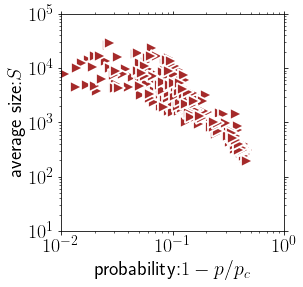

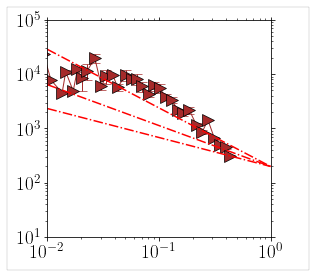

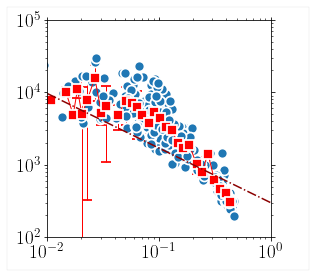

In [2274]:
if ModuAnl and not RemoteMachine:
    #--- 1st
    ax_rs = PlotPaperVersion(4,15,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'average size:$S$',
                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                   ylim=(1e1,1e5),
                    xlim=(1e-2,1),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
#                    verbose = True,
                )
    #--- 2nd
    ax_rm = PlotPaperVersion(4,15,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'average size:$S$',
                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                   ylim=(1e1,1e5),
                    xlim=(1e-2,1),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 64, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
#                    verbose = True,
                )

#--- fit
xx=np.logspace(-2,0,4)
for alpha in [alpha_min,alpha_mean,alpha_max]:
    yy=1/xx**alpha

    PltErr(xx,2e2*yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'red'},
           fontsize=FontSize,
            title='ModuAnl/smean_p_rescaled.png',
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
             ax=ax_rm)
    
#--- 3rd
ax3 = Pltt(ax_rs,ax_rm, indices=[0,5,10],
           xscale = 'log',
           yscale = 'log',
           ylim=(1e2,1e5),
           xlim=(1e-2,1),
#           DrawFrame=DFset,
           fontsize=FontSize,
#           title='ModuAnl/smean_p_rescaled.png',

    )

#--- fit
yy=3e2/xx**alpha_mean
PltErr(xx,yy,yerr=None,
       Plot=False,
       attrs={'fmt':'-.','color':'darkred'},
       fontsize=FontSize,
        title='ModuAnl/smean_p_rescaled.png',
        yscale='log',
        xscale='log',
        DrawFrame=DFset,
         ax=ax3)



##### extract exponent

exponent= -1.9843705183683666


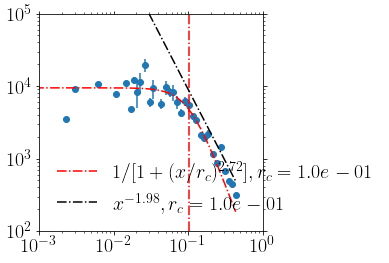

In [2275]:
def func0(x,a, alpha,rc):
    return a/(1.0+(x/rc)**alpha)
 
def func1(x, a,b):
    return b*x**a

def func2(x, a,b,x0):
    return a*np.exp(-(x/x0)**b)

def Wrapper(ax_h,item, Plot = True, **kwargs):
    #-----------------
    #--- fetch data
    #-----------------
    xdata, ydata, yerr = FetchData(ax_h, item )
    

        
    #-----------------
    #--- filter
    #-----------------
    filtr0 = Filtr(xdata,0.0,np.inf)    
    filtr1 = Filtr(ydata,0.0,np.inf)    
    filtr2 = Filtr(yerr,1.0e-06,np.inf)
    filtr = np.all([filtr0,filtr1,filtr2],axis=0)             
   
    #-----------------
    #--- Plot
    #-----------------
    if Plot:
        ax = PltErr( xdata[filtr],ydata[filtr],
                     yerr=yerr[filtr],
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
                    xlim=(1e-3,1),
                    ylim=(1e2,1e5),
              )
        
    #-----------------
    #--- make a fit: compute rc
    #-----------------
    if not 'rc' in kwargs:
        etol = 3e-16
        popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                           p0=(1.0e4,1.0,0.11) if not 'p0' in kwargs else kwargs['p0'], #(a,alpha,rc),
                           bounds=((1.0e3,0.5,.001), (1.0e5,6.0,1.0)) if not 'bounds' in kwargs else kwargs['bounds'],    
#                           sigma=yerr[filtr],
#                            method = ['lm', 'trf', 'dogbox'][0],
#                            max_nfev = 10000,
#                          absolute_sigma=True,
#                            verbose=2,
                            ftol=etol, xtol=etol, gtol=etol,
                              )
        rc = popt[2]
        
        #--------------
        #--- plot fit
        #--------------
        if Plot:
            ax = PltErr(xdata,func0(xdata,*popt), 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',
                        'label':r'$1/[1+(x/r_c)^{%3.2f}],r_c=%2.1e$'%(popt[1],popt[2]),
                        },
                        ax=ax,
                        legend=True,
                         xscale = 'log',
                        yscale='log',
                    xlim=(1e-3,1),
                    ylim=(1e2,1e5),
                       )        
        
    else:
        rc = kwargs['rc']

    #--------------
    #--- plot rc
    #--------------
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',

                    },
                    ax=ax,
                     xscale = 'log',
                    yscale='log',
                xlim=(1e-3,1),
                ylim=(1e2,1e5),
                     )
    #--------------
    #--- filter: x>rc
    #--------------
    filtr3 = np.all([filtr,Filtr(xdata,rc,np.inf)],axis=0)
    
    #--------------
    #--- linear fit: x>rc
    #--------------
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]
    
    #--------------
    #--- nonlinear fit: x>rc
    #--------------
    try:
        popt, pcov = curve_fit( func1, xdata[filtr3], ydata[filtr3], 
    #                            p0=(-1.0,1.0e3), #(a,b),
    #                            bounds=((-np.infty,0.0), (0.0,np.infty)),    
                                sigma=yerr[filtr3]
                                  )
    except:
        return np.nan, np.nan, np.nan

    #--------------
    #--- plot fit
    #--------------
    if Plot:
        ax = PltErr(xdata[filtr],func1(xdata[filtr],*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'black',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[0],rc),
                    },
                    ax=ax,
                    legend=True,
                     xscale = 'log',
                    yscale='log',
                xlim=(1e-3,1),
                ylim=(1e2,1e5),
                   )        
    
    return rc, popt[0], pcov[0,0]**0.5


if ModuAnl and not RemoteMachine:
    rc, alpha, err_alpha = Wrapper(ax_rm,0,
                                   p0=(1.0e4,1.0,0.11), #(a,alpha,rc),
                                   bounds=((1.0e3,0.5,.001), (1.0e5,6.0,1.0)),    
                                  
                                  )
#     rc, alpha, err_alpha = Wrapper(ax_rm,0,
#                                    p0=(1.0e4,-0.7*alpha,1.06*rc), #(a,alpha,rc),
#                                    bounds=((1.0e3,-0.6*alpha,1.05*rc), (1.0e5,-1.6*alpha,rc*2)),    
#                                   )

    print('exponent=',alpha)

In [2276]:
#--- vary cutoff 
rcc=np.logspace(np.log10(0.001),np.log10(1.0),32)
X = list(map(lambda x:Wrapper(ax_rm,0,Plot=False,rc=x), rcc))


exponent: 1.6506741800719067 - 2.4997882868476147


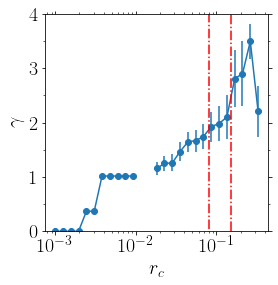

In [2277]:
#--- plot
r=np.c_[X][:,0]
nu=-np.c_[X][:,1]
yerr=np.c_[X][:,2]
ax = PltErr(r,nu, yerr=yerr,
      xstr=r'$r_c$',
      ystr=r'$\gamma$',
      Plot=False,
      xscale='log',
      )

#--- bound
r0, r1 ={
            0:(0.13,0.25),
            1:(0.02,0.05),
            2:(0.06,0.16),
            3:(0.14,0.36),
            4:(0.05,0.1),
            5:(0.08,0.15),
        }[indxxxx]

#--- plot
for rr in [r0,r1]:
    ax = PltErr([rr,rr],ax.axis()[2:],
          Plot=False,
         ax=ax,
          xstr=r'$r_c$',
          ystr=r'$\gamma$',
         attrs={'fmt':'-.r'},
         xscale='log',
         ylim=(0,4)
          )

#--- filter
filtr = Filtr(r,r0,r1)
alpha_min = (nu[filtr]-yerr[filtr]).min()
alpha_max = (nu[filtr]+yerr[filtr]).max()
alpha_mean = nu[filtr].mean()
print('exponent:',alpha_min,'-',alpha_max)
alpha=alpha_mean

In [2278]:
alpha_mean

2.004519649832829

##### Print

xdata= [0.13] 
ydata= [-21.17886453] 
erry= [nan]
plot itime=0,irun=0,len(ax.lines)=0
xdata= [0.1316708] 
ydata= [-31.16022562] 
erry= [nan]
plot itime=0,irun=1,len(ax.lines)=5
xdata= [0.1323282] 
ydata= [-19.8307539] 
erry= [nan]
plot itime=0,irun=2,len(ax.lines)=10


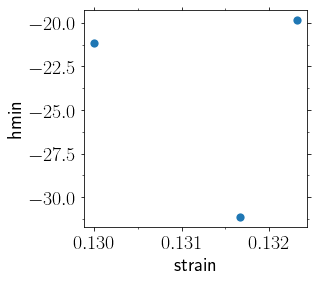

In [2196]:
#--- fetch hmin
ax = PlotPaperVersion(2,5,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'strain',
                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = False,
                runs=[0,1,2],
                times = [0],
                 verbose=True,
            )
#--- print
indices = [0,5,10]
hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
hmin = hmin[~np.isnan(hmin)]
glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
pathh='Exponents/%s'%(glass)
os.system('mkdir -p %s'%(pathh))
filee = '%s/hmin_gamma_exp.txt'%pathh
np.savetxt(filee,np.c_[hmin.mean(),0.5*(alpha_max+alpha_min),hmin.std(),0.5*(alpha_max-alpha_min)],
           header='hmin\tgamma\terr_hmin\terr_gamma'
          )

##### scatter plot

ydata= [-24.05661468]
plot irun=0,len(ax.lines)=0
ydata= [-34.08132368]
plot irun=0,len(ax.lines)=5
ydata= [-17.48745152]
plot irun=0,len(ax.lines)=10
ydata= [-16.34312562]
plot irun=0,len(ax.lines)=15
ydata= [-17.40530244]
plot irun=0,len(ax.lines)=20
ydata= [-23.83249824]
plot irun=0,len(ax.lines)=25


<AxesSubplot:>

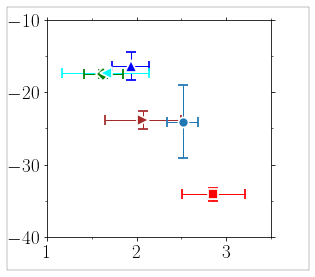

In [2197]:
PlotPaperVersion(5,25,
#                xlabel=r'$\gamma$',
#                ylabel=r'hmin',
                PlotEvery = True,
                timeseries = True,
                title='ModuAnl/hmin_gamma_exp.png',
                xlim=(1,3.5),
                ylim=(-40.0,-10.0),
                runs=[0],
                times = [0],
                #                 legend=True,
                #                        yscale='log',
                verbose=True,
                fontsize=FontSize,
                DrawFrame=DFset,          
                )

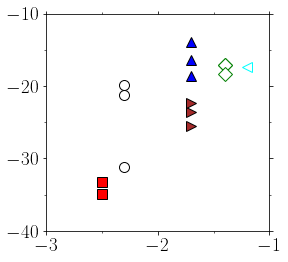

In [1819]:
if not RemoteMachine:
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=7, colx = 1, #--- x: delta (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                           xlabel=r'$\alpha$',
                           ylabel=r'$h_{min}$',
                        title='ModuAnl/hmin_gamma.png',
                        xlim=(-3,-1),
                        ylim=(-40.0,-10.0),
                        DataFrame=DFset,
                        fontsize=FontSize,
#                            legend = True,
                        verbose = False,
                    )

#### size distributions

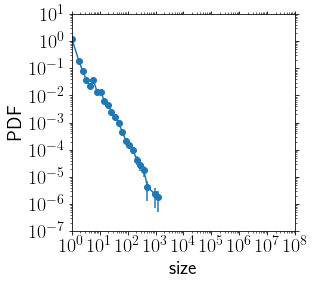

In [484]:
# if ModuAnl:
#     hist, edges, error = GetPDF( df_cls['size'].astype(float),n_per_decade=8)
#     #
#     PltErr(edges,hist, 
#        yerr=error, 
#        Plot = True,
#         xstr=r'size',
#         ystr=r'PDF',
#         yscale='log',
#         xscale='log',
#          ylim = (1e-7,1e1),
#          xlim = (1,1e8),
#     #     DrawFrame=(0.21,0.09,0.15,0.06,0.1),
#     #     title='pdfMu.%s.png'%itime,

#       )
#     np.savetxt('ModuAnl/ps.txt',
#                np.c_[edges,hist,error],
#                header='s\tp(s)\terror')


##### Plot

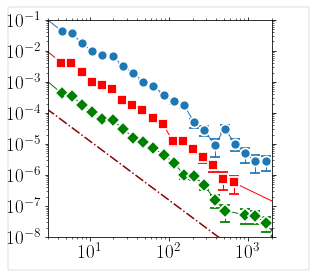

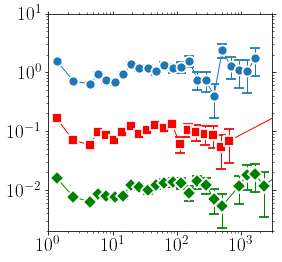

In [2227]:
if ModuAnl and not RemoteMachine:
    indxx = 5
    ax_h = PlotPaperVersion(4,16,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
                        title='ModuAnl/pdfClsSize.png',
                        yscale='log',
                        xscale='log',
                        ylim = (1e-8,1e-1),
                        xlim = (3,2e3),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
                        DrawFrame=DFset,
                         dpi=300,
                        times = [50,110,190],
                        scaley=[1.0,10.0,100.0],
                         runs = [1],#,1,2],
#                     verbose=True,
                     fontsize=FontSize,
                     fmt='-',
#                     nevery=2, #--- set to 1 for making a fit
                    )
    #--- fit
    xx=np.array(ax_h.lines[0].get_xdata())
    yy=1e-3/xx**1.9
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/pdfClsSize.png',
            yscale='log',
            xscale='log',
             ax=ax_h)

    #--- rescaled
    ax_rh = PlotPaperVersion(4,18,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
                        title='ModuAnl/pdfClsSize_rescaled.png',
                        yscale='log',
                        xscale='log',
                        ylim = (2e-3,10),
                        xlim = (1,3e3),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
#                        DrawFrame=(0.17,0.17,0.15,0.06,0.1),
                         dpi=300,
                        times = [50,110,190],
                        scaley=[1.0,10.0,100.0],
                         runs = [1],
#                     verbose=[True,False][1],
                     fontsize=FontSize,
                     fmt='-',
#                     nevery=1,
                    )

##### Exponent

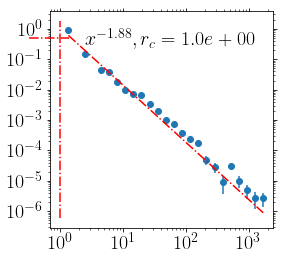

In [2206]:
def fnn(x, a,b):
    return a*x**b

def Wrapper(ax_h,item,rc, Plot = True):
    
    #--- fetch data
    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr = Filtr(xdata,rc,np.inf)
    
    #--- plot rc
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
        Plot = False,
        attrs={'fmt':'-.',
               'color':'red',

              },
        ax=ax,
          )
        
        
    #--- fit
    popt, pcov = curve_fit(fnn, xdata[filtr], ydata[filtr], 
#               p0=p0,
#               bounds=bounds,    
               sigma=yerr[filtr])
    
    
    #--- plot fit
    if Plot:
        ax = PltErr(xdata,fnn(xdata,*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[1],rc),
                    },
                    ax=ax,
                    legend=True,
                     xscale = 'log',
                    yscale='log',
                  )
    return rc, popt[1], pcov[1,1]**0.5


if ModuAnl and not RemoteMachine:
    Wrapper(ax_h,0,1)
    

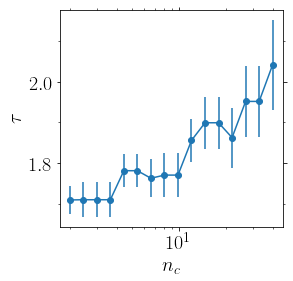

exponent: 1.665964040927893 - 2.152680819772246


In [2211]:
rcc=np.logspace(np.log10(2.0),np.log10(40.0),16)
X = list(map(lambda x:Wrapper(ax_h,3,x, Plot=None) , rcc))
nc=np.c_[X][:,0]
tau=-np.c_[X][:,1]
err = np.c_[X][:,2]
PltErr(nc,tau, yerr=err,
      xstr=r'$n_c$',
      ystr=r'$\tau$',
       xscale='log',
      )
print('exponent:',(tau-err).min(),'-',(tau+err).max())

#### fractal dimension

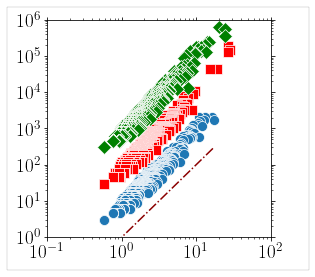

In [408]:
if ModuAnl and not RemoteMachine:
    indxx = 5
    ax_h = PlotPaperVersion(4,28,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
#                        title='ModuAnl/rg_s.png',
                        yscale='log',
                        xscale='log',
                         ylim = (1e0,1e6),
                         xlim = (1e-1,1e2),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
                        DrawFrame=DFset,
                         dpi=300,
                        times = [50,110,190],
                        scaley=[1.0,1/10.0,1/100.0],
                         runs = [1],#,1,2],
#                     verbose=True,
                     fontsize=FontSize,
                     fmt='.',
                     markeredgewidth=0.7,
#                     nevery=2, #--- set to 1 for making a fit
                    )
#     #--- fit
    xx=np.array(ax_h.lines[0].get_xdata())
    xx=np.array([np.min(xx),np.max(xx)])
    yy=xx**2
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/rg_s.png',
            yscale='log',
            xscale='log',
             ax=ax_h)

#     #--- rescaled
#     ax_rh = PlotPaperVersion(4,18,
#                       glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
#                              4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxx],
# #                         xlabel=r'$s$',
# #                         ylabel=r'$n_s$',
#                         title='ModuAnl/pdfClsSize_rescaled.png',
#                         yscale='log',
#                         xscale='log',
#                         ylim = (2e-3,10),
#                         xlim = (1,3e3),
#                         PlotEvery = True,
#                         PlotMean = False,
#                          timeseries = False,
# #                        legend = True,                 
# #                        DrawFrame=(0.17,0.17,0.15,0.06,0.1),
#                          dpi=300,
#                         times = [50,110,190],
#                         scaley=[1.0,10.0,100.0],
#                          runs = [1],
# #                     verbose=[True,False][1],
#                      fontsize=FontSize,
#                      fmt='-',
# #                     nevery=1,
#                     )

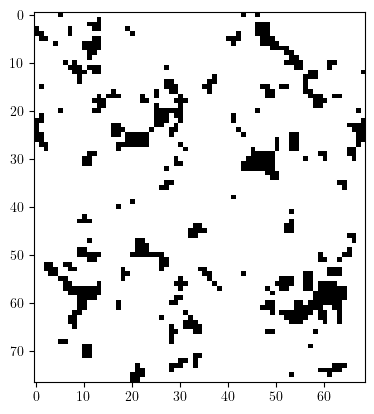

gamma= 0.2


In [347]:

#     #--- reshape value
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 
# value = np.c_[d2intrp.C66].reshape(((ny,nx,nz)))

# #--- xy plane
# #--- 2d slice
# nzl=[0]
# val = Get2dSlice( value, zlin, 
#                     zlin[-1], nzll=nzl  )
# mask = val<0
# plt.imshow(mask,cmap='Greys')
# plt.show()
# # #--- threshold
# #--- cluster analysis
# label_im, nb_labels = ndimage.label(mask)

# print('gamma=',GetStrain(lmpData,itime,0))
# # # 			#--- strain rate
# # d={} #---intensity
# # xcont={} #---area
# # rcx={};rcy={};rsq={};
# # Ixx={};Iyy={};Ixy={} #--- moment of inertia
# # for i,irow in zip(label_im,xrange(sys.maxint)):
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in d:
# #             d[j]+=mask[irow,jcol]*valmx[irow,jcol] #--- sum_ep
# #             xcont[j]+=1
# #             rcx[j]+=jcol #--- centroid
# #             rcy[j]+=irow
# #         else:
# #             d[j]=mask[irow,jcol]*valmx[irow,jcol]
# #             xcont[j]=1
# #             rcx[j]=jcol #--- centroid
# #             rcy[j]=irow
# # for j in rcx: #--- centroid
# #     rcx[j]/=1.0*xcont[j]	
# #     rcy[j]/=1.0*xcont[j]
# # for i,irow in zip(label_im,xrange(sys.maxint)): #--- radius of gyr.
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in rsq:
# #             rsq[j]+=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]+=(jcol-rcx[j])**2*dxsq #--- sum (x_i-<x>)^2
# #             Iyy[j]+=(irow-rcy[j])**2*dysq
# #             Ixy[j]+=(jcol-rcx[j])*(irow-rcy[j])*DXY #--- sum (x_i-<x>)*(y_i-<y>)

# #         else:
# #             rsq[j]=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]=(jcol-rcx[j])**2*dxsq
# #             Iyy[j]=(irow-rcy[j])**2*dysq
# #             Ixy[j]=(jcol-rcx[j])*(irow-rcy[j])*DXY
# # for j in rsq: #--- normalize
# #     rsq[j]/=xcont[j]	
# #     Ixx[j]/=xcont[j]	
# #     Iyy[j]/=xcont[j]	
# #     Ixy[j]/=xcont[j]	

# # #--- find eigendirections of I (l1,l2) l2>l1
# # T=[[0.0,0.0],[0.0,0.0]]
# # l1={};l2={};theta={};
# # for items in Ixx:
# #     R = (0.25 * ( Ixx[items]-Iyy[items])**2+ Ixy[items]*Ixy[items])**0.5 #--- naisotropy
# #     lc=0.5*(Ixx[items]+Iyy[items]) #--- 1st invariant
# #     l2[items]=R+lc #--- eigenvalues
# #     l1[items]=lc-R
# #     assert l1[items] >= 0.0 and l2[items] >= 0.0 
# #     theta[items]=atan2(Ixy[items],0.5*( Ixx[items]-Iyy[items]))*0.5 #--- eigen directions
# #     n=[cos(theta[items]),sin(theta[items])]
# #     t=[-sin(theta[items]),cos(theta[items])]
# #     #--- sanity check 
# #     T0=[[Ixx[items],Ixy[items]],[Ixy[items],Iyy[items]]]
# #     x=0.0
# #     for i in xrange(2):
# #         for j in xrange(2):
# #             T[i][j]=l2[items]*n[i]*n[j]+l1[items]*t[i]*t[j]
# #             x+=(T[i][j]-T0[i][j])**2
# #     assert x < 1.0e-10, '|T-T0|=%s'%x
# # #				print [T[0][0],T[0][1],T[1][1]], [Ixx[items],Ixy[items],Iyy[items]]

# Local Order Analysis

In [362]:
if CommonNeighAnl and not Ovitos:
    if not TimeSeries:
        #--- extract atom and box properties
        cna = lp.Atoms( **lmpCna.coord_atoms_broken[itime].to_dict(orient='list') )
    else:
        cna = {}
        for iitime in lmpCna.coord_atoms_broken:
            cna[iitime] = lp.Atoms( **lmpCna.coord_atoms_broken[iitime].to_dict(orient='list') )

if CommonNeighAnl and Ovitos:            
    !ovitos OvitosCna.py $fileName Cna.xyz $nevery 0

InputFile= /Users/Home/Desktop/Tmp/txt/FeNi_glass.dump
num_frames= 201


In [364]:
#--- read from d2min.xyz
if CommonNeighAnl and Ovitos:
    lmpData = lp.ReadDumpFile( 'Cna.xyz' )
    lmpData.GetCords( ncount = sys.maxsize)

## Histograms

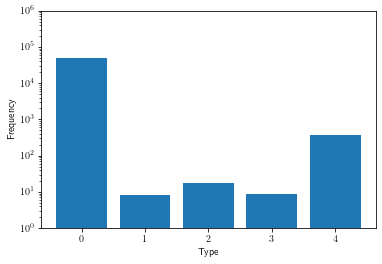

In [365]:
if CommonNeighAnl and not TimeSeries:
    cna = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    plt.yscale('log')
    plt.ylim(1,1e6)
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    #
    x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
    #
    count=np.zeros(5,dtype=int)
    for typee in x:
        count[int(typee)] = y[int(typee)]
    #
    plt.bar(x, count)
    #
    plt.show()
    #--- strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = np.array([dx/l1])

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.concatenate([ebulk,count]).reshape((1,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


## output timeseries

In [378]:
if CommonNeighAnl:
    #
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    ntime = len(times)
    ebulk = np.zeros( ntime )
    Count = np.zeros(ntime*5).reshape((ntime,5))
    #
    for iitime, indxx in zip(times,range(ntime)):
        cna = lp.Atoms( **lmpData.coord_atoms_broken[iitime].to_dict(orient='list') )
        #
        x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
        #
        for typee, count in zip(x,y):
            typee = int(typee)
            count = int(count)
            Count[indxx,typee] = count
        #
        #--- strain
        if indxx == 0:
            box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
            box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        box = lp.Box( BoxBounds = lmpData.BoxBounds[iitime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk[indxx] = dx/l1

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.c_[ebulk,Count].reshape((ntime,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


### Multiple Frames

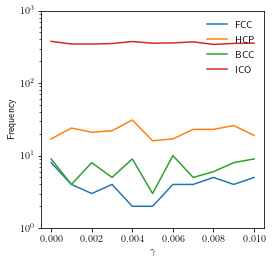

In [379]:
if CommonNeighAnl:
    path = '.'
    sarr = np.loadtxt('%s/StructureTypeCounts.txt'%path)

    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('Frequency')
    ax.set_ylim(1e0,1e3)
    ax.set_yscale('log')
    #
    #ax.plot(sarr[:,0],sarr[:,1],label='Other')
    ax.plot(sarr[:,0],sarr[:,2],label='FCC')
    ax.plot(sarr[:,0],sarr[:,3],label='HCP')
    ax.plot(sarr[:,0],sarr[:,4],label='BCC')
    ax.plot(sarr[:,0],sarr[:,5],label='ICO')
    #
    ax.legend(frameon=False)
    plt.savefig('StructureTypeGamma.png',dpi=75,bbox_inches='tight')
    plt.show()

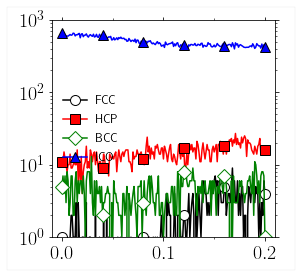

In [389]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e0,1e3)
    
    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    #
    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    sarr  = np.loadtxt('CnaCo5Cr5Fe40Mn27Ni26/Run0/StructureTypeCounts.txt')
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        'FCC','HCP','BCC','ICO'
                                        ],markers, colors, fillstyles, range(10) )):

        #--- fliter
        ydata = sarr[:,indx+2] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/5),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('CrysFracGood.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Crltns with d2min

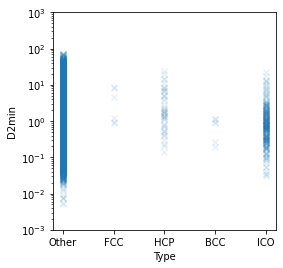

In [124]:
if CommonNeighAnl and DminAnalysis:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Type')
    ax.set_ylabel('D2min')
    ax.set_ylim(1e-3,1e3)
    ax.xaxis.set_ticks([0,1,2,3,4])
    ax.xaxis.set_ticklabels(['Other','FCC','HCP','BCC','ICO'])
    
    ax.set_yscale('log')
    ax.scatter(pd.DataFrame(cna.__dict__).sort_values(by='id')['StructureType'],
                pd.DataFrame(d2min.__dict__).sort_values(by='id')['d2min'],
                alpha = 0.1,
                marker='x'
               )

# Displacement Gradients

## Interpolate Displacements
### cubic grid

In [91]:
if StrnAnalysis:
    #--- mean dist between atoms 
    natoms = len( atoms0.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 

    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


### center box + margin

In [92]:
if StrnAnalysis:
    #--- get a chunk of the full copy
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.2, mode = 'isotropic' )

    points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
    values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



### Print

In [289]:
if StrnAnalysis:

    file_name = 'uintrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    #for itime in df_intrp:
    PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','dx','dy','dz'] )


## Strain tensor

In [93]:
if StrnAnalysis:
    csn = lp.ComputeStrn( uintrp, box0 )
    csn.Reshape( xlin, ylin, zlin )
    csn.Gradient()
    csn.SetStrn('exy')
    Exy = csn.Get(attrs = ['x','y','z','exy'])


### imshow

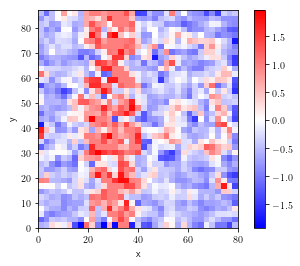

In [96]:
def FilterMatrix( CellVector, CellOrigin,
                  xlin, ylin, zlin,
                  xv, yv, zv ,
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf



if StrnAnalysis:

    #itime = np.max(dfD2min_intrp.keys())
    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
    #value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

    # lx=xlin[-1]-xlin[0]
    # ly=ylin[-1]-ylin[0]
    # #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
    # value = np.c_[df_intrp[itime]['ux']]
    # value = value.reshape(((ny,nx,nz)))
    #print value.shape

    #--- filter value
    # value = FilterMatrix( box0.CellVector, box0.CellOrigin,
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )
    #print value.shape
    #print vf.shape

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()
    #val = value[:,:,nz/2].copy()
    #print val.shape

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
               title = 'strain.png',
           )

In [89]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [90]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

### Print

In [30]:
if StrnAnalysis:

    file_name = 'strain.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    # times = Strain.keys()
    # times.sort()
    #--- bulk strain
    dx=box.CellVector[0,1]-box.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1


    PrintOvito( pd.DataFrame(Exy.__dict__), 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exy'] )
    

### Auto-Correlations

In [97]:
if StrnAnalysis:

    #Crltn = {}
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Exy.exy].reshape((ny,nx,nz))
    #    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
    #    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
        #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    Crltn = GetAutoCorrelation( value )


### Print

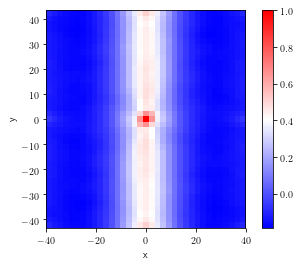

In [99]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    
    crltn = Crltn #[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_strain.%s.png'%itime,
              dpi = 60
            )
        # #--- zx plane
        # val = crltn[0,:,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'x',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )
        # #--- zy plane
        # val = crltn[:,0,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'y',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )



### Crltn Length

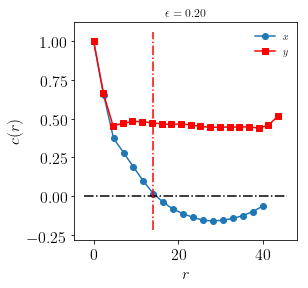

(14.108201970564707, nan)

In [107]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_strain.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    np.savetxt('Cx.txt',np.c_[xdata0.real,ydata0.real],header='x\tc(x)')
    np.savetxt('Cy.txt',np.c_[xdata.real,ydata.real],header='y\tc(y)')

#### multiple plots

In [109]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()


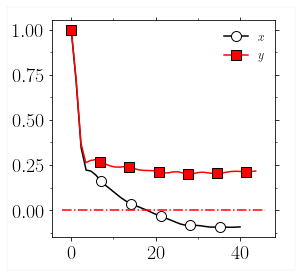

In [201]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 5
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'x','y'
#                                           'CoNiFe',
#                                             'CoNiCrFe',
#                                             'CoCrFeMn',
#                                             'CoNiCrFeMn',
#                                             'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('CrltnFeNi/Run2/C%s.txt'%GlassType,dtype=str)
        #--- fliter
        ydata = list(map(eval,sarr[:,1])) #--- first 2nd col is stress drop
        xdata = list(map(eval,sarr[:,0])) #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black',
                markevery=6,
                label = '$%s$'%GlassType)
    ax.plot(ax.axis()[:2],[0,0],'r-.')

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('cr.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# Composition dependence

In [254]:
if CompFluc:
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0]))
    #--- partition & compute \delta within each subvolume
    (xlin,ylin,zlin), df_comp =\
                            GetPressComp(atoms,
                                         box, 
                                         4.0,
                                         AtomicRadius,
                                        ) 
    display(df_comp.head())
    #--- add as an attribute
    atoms.tmp = GetMismatchIco(pd.DataFrame(atoms.__dict__),box,
                       df_comp,
                       xlin,ylin,zlin,
                      )

4.0 8820


indxx indxy indxz          x          y          z     Type1 Type2 Type3  \
0     0     0     0 -40.134051 -43.803007 -43.791535       0.2   0.0   0.0   
1     0     0     1 -40.134051 -43.803007 -39.620913       0.0   0.2   0.0   
2     0     0     2 -40.134051 -43.803007  -35.45029       0.0   0.0   0.0   
3     0     0     3 -40.134051 -43.803007 -31.279668       0.0   0.0   0.0   
4     0     0     4 -40.134051 -43.803007 -27.109045  0.166667   0.5   0.0   

      Type4     Type5    deltaa  
0       0.2       0.6  0.005612  
1       0.6       0.2  0.007076  
2       0.8       0.2  0.003527  
3       0.5       0.5  0.004564  
4  0.166667  0.166667  0.006667

In [253]:
#itime=2000000
#CompFluc=True
#itime=[700000,1000000,1300000,1600000][0] #: #times[0::10]:
#

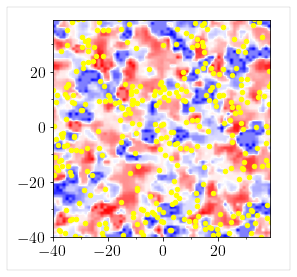

In [337]:
if CompFluc:
    
    PlotAttrs = {
                'zscore' : True,
                'scale' : 'linear',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
                'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
                'colorbar':False,
#                'vmin':-0.5,
#                'vmax':+2.1,
                 'Plot' : 'True',
                'frac':1.0,
                'title':'mapDeltaSro.%s.png'%itime,
                'color':'yellow',
                's':20,
#                'ticklabels': True,
                'dpi':300,
                }
    #--- plot
#     (xlin, ylin, zlin), (xv, yv, zv), delta_intrp = Intrp(atoms, box, 'tmp',
#                     Plot = True,
#     #                title='mapCxyxy.%s.png'%itime,
#     #                    cmap='Greys',
#     #                    colorbar=True,
#                     zscore=True,
#     #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                     xlabel = '', ylabel = '',
#     #                    vmin=,vmax=,
#                    )
    #--- plot with ico
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), delta_intrp =\
    IntrpScatter(
                    atoms, box, 'tmp',
                    vor,
                    **PlotAttrs
                   )

## Plot CG field

In [221]:
def plott(sarr,xlin,ylin,zlin,box, title):
    nx,ny,nz = len(xlin), len(ylin), len(zlin)
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    nzl=[0]
    val = Get2dSlice( value, zlin, 
                      zlin[-1], nzll=nzl  )
    nzz=nzl[0]
    
#     pdb.set_trace()
#     print(val.max())
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = False,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
if CompFluc:
    plott(df_comp['deltaa'].astype(float),xlin,ylin,zlin,box, 'delta_map.png')

ValueError: cannot reshape array of size 8820 into shape (77,69,77)

## Crltns

### with d2min

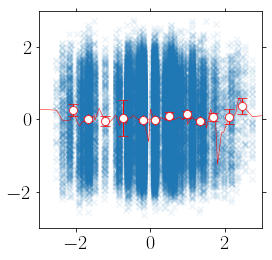

0.0051534393925736265

In [143]:
if CompFluc:
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atoms,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*3,
    #            title = 'scatterModuRho.png',
    #            axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

### with SRO

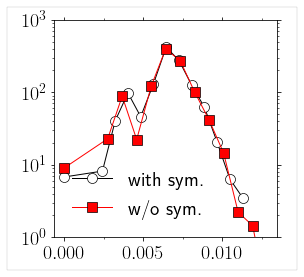

In [340]:
if CompFluc:
    hist, edges, error =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#
    hist2, edges2, error2 =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[~GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#---plot
    attrs={ 
            'color':'black',
            'markersize':10,
            'marker':'o',
            'markerfacecolor':'white',
            'markeredgecolor':'black',#None,
            'label':r'with sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
          }
#---
    ax =    PltErr(edges,hist, 
           yerr=None,#error, 
           attrs = attrs,
           Plot = False,
            yscale='log',
          )
#--- 2nd plot
    attrs={ 
            'color':'red',
            'markersize':10,
            'marker':'s',
            'markerfacecolor':None,
            'markeredgecolor':'black',
            'label':'w/o sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
         }
    
    PltErr(edges2,hist2, 
           yerr=None,#error2, 
           attrs = attrs,
           Plot = True,
    #       xstr=r'$\mu$(Gpa)',
    #       ystr=r'Histogram',
            yscale='log',
           ax=ax,
           legend=True,
            ylim = (1e0,1e3),
    #        xlim = (-500,500),
            DrawFrame=(0.21,0.09,0.15,0.06,0.1),
            title='pdfDelta.%s.png'%itime,
            dpi=300,

          )

In [282]:
GetMismatch(lmpData,2000000,AtomicRadius)

0.006973932876198204

In [284]:
np.mean(atoms.tmp)

0.0069347623381881005

# bar chart

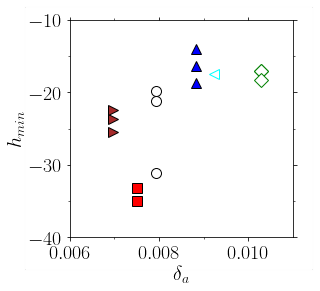

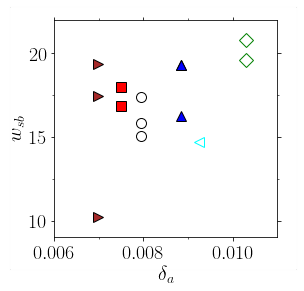

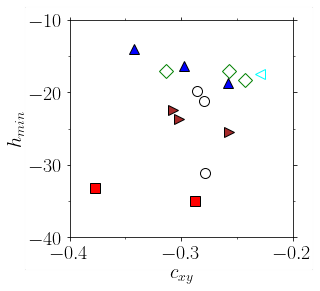

In [120]:
if not RemoteMachine:

    ax_hmin=    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                       xlabel=r'$\delta_a$',
                       ylabel=r'$h_{min}$',
                       xlim=(0.006,0.011),
                       ylim=(-40.0,-10.0),
                    )

    ax_wsb=    PlotPaperVersionScatter( 2, #--- path:
                                xindx=6, colx = 0, #--- x: delta (1st column)
                                yindx=3, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$\delta_a$',
                            ylabel=r'$w_{sb}$',
                            xlim=(0.006,0.011),
                            ylim=(9.0,22.0),
                        )


    ax_cxy = PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$c_{xy}$',
                            ylabel=r'$h_{min}$',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
    #                        legend = True,
    #                        yscale='log',
                           )

In [246]:
if not RemoteMachine:
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))), #--- hmin
    list(map(lambda x:ax_hmin.lines[x].get_xdata()[strain_indx],range(len(ax_hmin.lines)))), #--- delta
    list(map(lambda x:ax_wsb.lines[x].get_ydata()[strain_indx],range(len(ax_wsb.lines)))),   #--- wsb
    list(map(lambda x:ax_cxy.lines[x].get_xdata()[strain_indx],range(len(ax_cxy.lines)))),   #--- cxy
    ]
    print('X.shape=',X.shape)

X.shape= (18, 4)


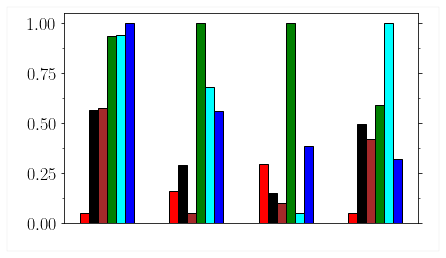

In [132]:
def Scale(d):
    xmin=np.min(list(d.values()))
    xmax=np.max(list(d.values()))
    for key in d:
        x=(d[key]-xmin)/(xmax-xmin)
        d[key]=x if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    col=0
    xx=X[:,col].reshape((nglass,nrun))
    delta = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(delta)
    #
    col=1
    xx=X[:,col].reshape((nglass,nrun))
    hmin = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(hmin)
    #
    col=2
    xx=X[:,col].reshape((nglass,nrun))
    wsb = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(wsb)
    #
    col=3
    xx=X[:,col].reshape((nglass,nrun))
    cxy = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(cxy)
    
    #--- sort based on a specific measured quantity
    tmp = hmin #delta
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
#    X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
    X = ['$h_{min}$','$\delta_a$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):

        ax.bar(X_axis - 0.3+indxx*0.1, 
#               [delta[GlassType],hmin[GlassType],wsb[GlassType],cxy[GlassType]], 
               [hmin[GlassType],delta[GlassType],wsb[GlassType],cxy[GlassType]], 
               0.1, color =color, edgecolor ='black', label =GlassType)
#    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    DrawFrame(ax, 0.16,0.06,0.13,0.03,0.04)
    #
    plt.savefig('barchart.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#     plt.show ()

metrics= {0: {'FeNi': -24.056614682249347, 'CoNiFe': -34.081323684193194, 'CoNiCrFe': -17.487451523542404, 'CoCrFeMn': -16.343125618373353, 'CoNiCrFeMn': -17.405302442610264, 'Co5Cr2Fe40Mn27Ni26': -23.832498244941235}, 1: {'FeNi': 0.007936586225505048, 'CoNiFe': 0.007502533224194396, 'CoNiCrFe': 0.010289512237036523, 'CoCrFeMn': 0.008838300533593824, 'CoNiCrFeMn': 0.009240771894279727, 'Co5Cr2Fe40Mn27Ni26': 0.006972035495180782}, 2: {'FeNi': 16.095755612713045, 'CoNiFe': 17.446272847844178, 'CoNiCrFe': 23.85055146670533, 'CoCrFeMn': 18.27395945913044, 'CoNiCrFeMn': 14.728425974025981, 'Co5Cr2Fe40Mn27Ni26': 15.676099141092196}, 3: {'FeNi': -0.28135338221233247, 'CoNiFe': -0.3323517062111617, 'CoNiCrFe': -0.2714970300874306, 'CoCrFeMn': -0.2995402299612517, 'CoNiCrFeMn': -0.22980893322512733, 'Co5Cr2Fe40Mn27Ni26': -0.288908150257608}}


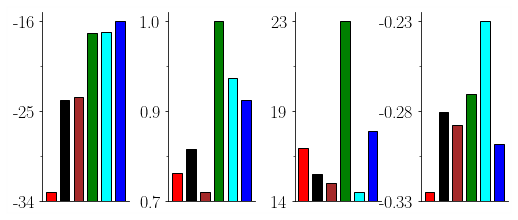

In [247]:
# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)



    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    metric={}
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    cols = X.shape[1]
    for col in range(cols):
        xx=X[:,col].reshape((nglass,nrun))
        metric[col] = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
#    print('metrics.shape=',metric.shape)
    print('metrics=',metric)
#    Scale(delta)
    
    #--- sort based on a specific measured quantity
    tmp = metric[0]
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X_axis = np.arange(len (metric))
    
    #--- plot
    fig = plt.figure(figsize=(7,3))
    ax={}
    for col in range(cols):
        ax[col] = fig.add_subplot(1,4,col+1)

    fig.tight_layout(pad=-.1)
    for col in range(cols):

        data = metric[col]
        tmp = data.copy()
        Scale(data)
        
        for GlassType, color, fillstyle, indxx in list(zip( Glasslist, colors, fillstyles,range(20))):

        
            ax[col].bar(range(nglass)[indxx], 
                   data[GlassType],
                   width=.7,
                   color =color, edgecolor ='black', label =GlassType)
            xmin = np.min(list(tmp.values()))
            xmax = np.max(list(tmp.values()))
            
            if col == 1 : #--- delta
                ax[col].yaxis.set_ticklabels([r'%2.1f%%'%(100*xmin),r'%2.1f%%'%(100*(xmin+xmax)/2),r'%2.1f%%'%(100*xmax)])
            elif col == 0 or col == 2: #--- hmin & wsb
                ax[col].yaxis.set_ticklabels(['%d'%(xmin),'%d'%((xmin+xmax)/2),'%d'%(xmax)])
            elif col == 3: #--- cxy
                ax[col].yaxis.set_ticklabels(['%3.2f'%(xmin),'%3.2f'%((xmin+xmax)/2),'%3.2f'%(xmax)])
                
                
            ax[col].yaxis.set_ticks([0,0.5,1])
        #

    for ii in range(cols):
        ax[ii].axes.xaxis.set_visible(False)
        ax[ii].spines['right'].set_visible(False)
        ax[ii].spines['top'].set_visible(False)
        ax[ii].yaxis.set_minor_locator (AutoMinorLocator (2))

    DrawFrame(ax[0], 0.4,4.4,0.06,0.03,0.01)
    #
    plt.savefig('barchart2nd.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show ()

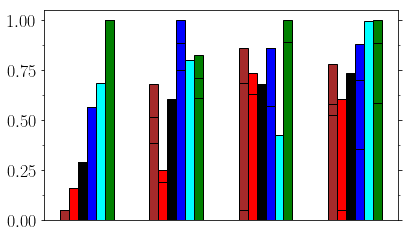

In [277]:
# def Scale(d):
# #    pdb.set_trace()
#     xmin=np.min([item for key in d for item in d[key]]) #list(d.values())#np.min(np.array().flatten())
#     xmax=np.max([item for key in d for item in d[key]])
#     for key in d:
#         x=(np.array(d[key])-xmin)/(xmax-xmin)
#         x[x==0.0]=0.05
#         d[key]=x #if x >0.0 else 0.05

# # ********* ************************************************** ***************************************
# # Importing libraries and font formating
# # **** ************************************************** ********************************************
# if not RemoteMachine:
#     import numpy as eg
#     import matplotlib .pyplot as plt
#     import matplotlib.ticker as ticker
#     from matplotlib.ticker import AutoMinorLocator
#     plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
#     plt.rc ('text', usetex = True)
#     plt.rc ('xtick', labelsize = 18)
#     plt.rc ('ytick', labelsize = 18)

#     fig = plt.figure ()
#     ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
# #    ax.set_ylim (0,1.1)
#     ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
#     ax.xaxis.set_minor_locator (AutoMinorLocator (2))
#     ax.yaxis.set_minor_locator (AutoMinorLocator (2))

#     colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
#     fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
#     markers=['o','s','D','^','<','>','v']
    
#     #--- store different measurements
#     sarr_Mismatch = {}
#     sarr_StrsDrop = {}
#     sarr_BandWidth = {}
#     sarr_Cxy = {}
#     for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
#                                         'FeNi',
#                                          'CoNiFe',
#                                           'CoNiCrFe',
#                                           'CoCrFeMn',
#                                            'CoNiCrFeMn',
#                                           'Co5Cr2Fe40Mn27Ni26'
#                                         ],markers, colors, fillstyles,range(20))):

#         sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
#         sarr_StrsDrop[GlassType]= -sarr[:,1][~np.isnan(sarr[:,1])]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
#         xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
#         indices = np.any(~np.isnan(xdata),axis=1)
#         sarr_BandWidth[GlassType] = xdata[~np.isnan(xdata)]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
#         sarr_Mismatch[GlassType] = sarr[:,0][~np.isnan(sarr[:,0])]
#         #---
#         cxy=[]
#         for irun in range(3):
#             try:
#                 sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
#                 hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
#                 #--- fliter
#                 xdata = sarr[:,1] #--- first 2nd col is stress drop
#                 cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
#             except:
#                 continue
#         sarr_Cxy[GlassType] = cxy
        
        
#     #--- scale
#     Scale(sarr_StrsDrop)
#     Scale(sarr_BandWidth)
#     Scale(sarr_Mismatch)
#     Scale(sarr_Cxy)
    
#     #--- sort based on a specific measured quantity    
#     slist=[[np.mean(sarr_Mismatch[key]),key,colors[indxx]] for key,indxx in zip(sarr_Mismatch,range(32))]
#     slist.sort()
#     Glasslist=np.array(slist)[:,1]
#     colors=np.array(slist)[:,2]
    
#     #--- quantities
#     X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
#     X_axis = np.arange(len (X))
    
#     #--- plot
#     for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):
#         for iprop,prop in zip(range(len(X_axis)),
#                               [sarr_Mismatch[GlassType], sarr_StrsDrop[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]]): 
#             prop=list(prop)
#             prop.sort(reverse=True)
#             for irun in range(3):
#                 try:
#                     ax.bar([X_axis[iprop] - 0.3+indxx*0.1], [prop[irun]],
#                    0.1, color =color, edgecolor ='black', label =GlassType)
#                 except:
#                     continue
# #    plt.xticks(X_axis, X)
#     ax.axes.xaxis.set_visible(False)
# #    plt.ylabel("Observables")
# #    plt.legend(bbox_to_anchor=(1,1))
#     fig.savefig ("barchart.png",dpi=150)
# #     plt.show ()

# Correlation Matrix

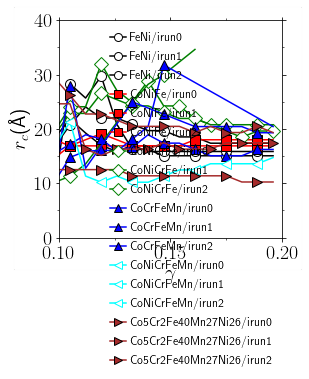

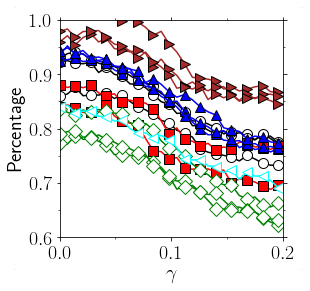

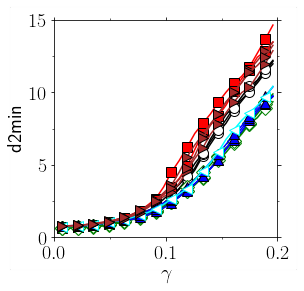

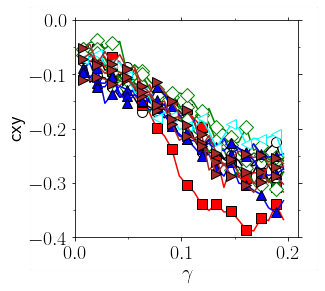

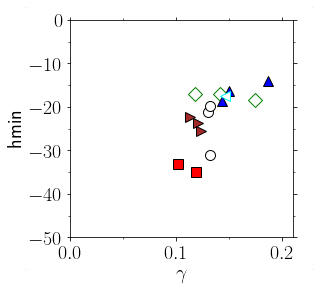

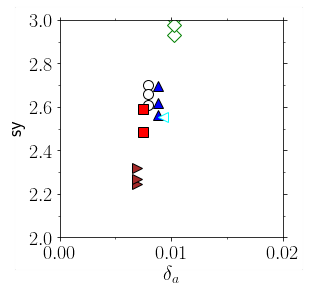

error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiFe/Run0/gr_peak_gamma.txt
error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiCrFeMn/Run0/gr_peak_gamma.txt
error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiCrFeMn/Run2/gr_peak_gamma.txt


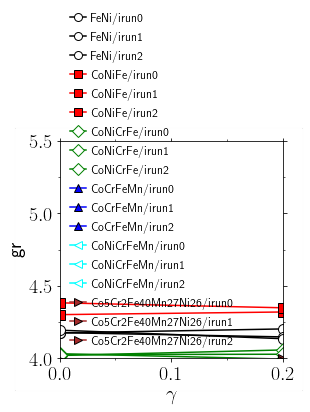

In [253]:
if not RemoteMachine:
    
    attrs = {           'xlabel':r'$\gamma$',
                        'ylabel':r'$r_c$(\r{A})',
                        'ylim':(0,40),
                        'xlim':(0.1,.2),
                        'PlotMean' : False,
                        'legend' : True,
    #                        yscale='log',
                        'borderwidth' : 0.01,
            }
    #---
    ax_ws = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 3,
                        #
                        **attrs,
                      )
    #---
    ax_ico = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 1,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'Percentage',
                        ylim=(0.6,1),
                        xlim=(0.0,.2),
                      )
    #---
    ax_d2min = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 2,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'd2min',
                        ylim=(0.0,15),
                        xlim=(0.0,.2),
                      )
    #---
    ax_cxy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_hmin = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 5,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'hmin',
                        ylim=(-50,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_sy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 6,
                        #
                        xlabel=r'$\delta_a$',
                        ylabel=r'sy',
                        ylim=(2,3),
                        xlim=(0.0,.02),
                      )
    #---
    ax_gr = GetMetrics(
                        pathh_indx = 0,
                        file0_indx = 7,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'gr',
                        legend = True,
                        ylim=(4,5.5),
                        xlim=(0.0,.2),
                      )

In [254]:
if not RemoteMachine:
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_ws.lines[x].get_ydata()[strain_indx],range(len(ax_ws.lines)))),
    list(map(lambda x:ax_ico.lines[x].get_ydata()[strain_indx],range(len(ax_ico.lines)))),
    list(map(lambda x:ax_gr.lines[x].get_ydata()[0],range(len(ax_gr.lines)))),
    list(map(lambda x:ax_d2min.lines[x].get_ydata()[strain_indx],range(len(ax_d2min.lines)))),
    list(map(lambda x:ax_cxy.lines[x].get_ydata()[strain_indx],range(len(ax_cxy.lines)))),
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_ydata()[strain_indx],range(len(ax_sy.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_xdata()[strain_indx],range(len(ax_sy.lines)))),
    ]
    print('X.shape=',X.shape)

X.shape= (18, 8)


          delta        ws       ico        gr     d2min       cxy      hmin  \
delta  1.000000  0.580452 -0.850879 -0.312320 -0.886660  0.350656  0.633484   
ws     0.580452  1.000000 -0.553000 -0.069545 -0.399428  0.277581  0.239633   
ico   -0.850879 -0.553000  1.000000 -0.159189  0.600495 -0.200606 -0.248221   
gr    -0.312320 -0.069545 -0.159189  1.000000  0.639760 -0.316212 -0.754765   
d2min -0.886660 -0.399428  0.600495  0.639760  1.000000 -0.522423 -0.802783   
cxy    0.350656  0.277581 -0.200606 -0.316212 -0.522423  1.000000  0.481383   
hmin   0.633484  0.239633 -0.248221 -0.754765 -0.802783  0.481383  1.000000   
sy     0.888267  0.569669 -0.864782  0.003911 -0.690007  0.225054  0.383635   

             sy  
delta  0.888267  
ws     0.569669  
ico   -0.864782  
gr     0.003911  
d2min -0.690007  
cxy    0.225054  
hmin   0.383635  
sy     1.000000  


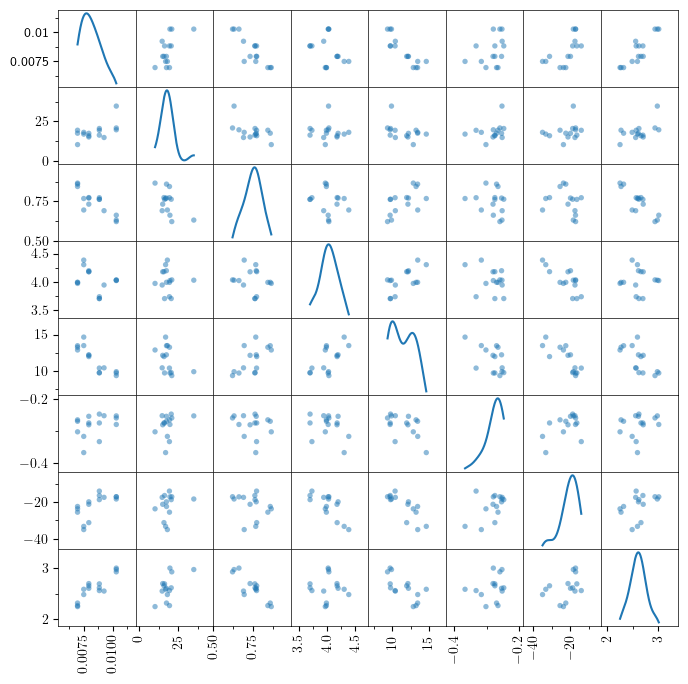

In [261]:
if not RemoteMachine:
    sns.reset_defaults()
    #--- labels
    # ylabel=np.array([0,0,0])
    # for i in range(1,6):
    #     ylabel=np.c_[ylabel,np.ones(3,dtype=int)*i]
    # ylabel = ylabel.T.flatten()

    #
    #indices = np.all(~np.isnan(X),axis=1) #--- remove nans
    df = pd.DataFrame(X,columns=['ws','ico','gr','d2min','cxy','hmin','sy','delta']) #,dtype=float)


    #    display(df)
    markers=['o','s','D','^','<','>']
    colors = ['black','red','green','blue','cyan','brown']
    plt.rcParams['text.usetex'] = True
    #
    ms=scatter_matrix( df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']],
                      figsize=(8, 8),
                    range_padding = 1,
                    s=15.0,
                    diagonal='kde',
    #               c=df['label'],
                   marker='o',
                  )
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
#            ms[i,i].set_visible(False)
            ms[i,j].set_xlabel('')
            ms[i,j].set_ylabel('')

            ms[i,j].spines['top'].set_linewidth(.5)
            ms[i,j].spines['right'].set_linewidth(.5)
            ms[i,j].spines['bottom'].set_linewidth(0.5)
            ms[i,j].spines['left'].set_linewidth(0.5)

            ms[i,j].tick_params(labelsize=10,which='both',axis='both', top=False, right=False)
            PutMinorTicks(ms[i,j])

    plt.savefig('scatter_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.1)

    corr = df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']].corr()
    print(corr)
    plt.show()

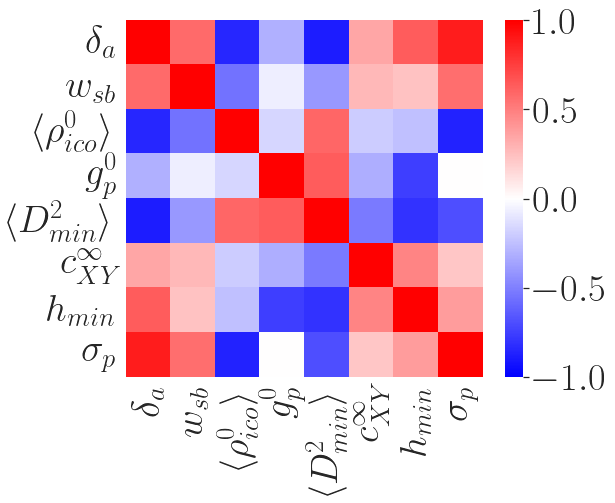

In [259]:
if not RemoteMachine:
    import seaborn as sns

    sns.set(font_scale=3.5, rc={'text.usetex' : True})

    xticklabels = [r'$\delta_a$',r'$w_{sb}$',r'$\langle\rho_{ico}^0\rangle$',r'$g_p^0$',r'$\langle D^2_{min}\rangle$',r'$c^\infty_{XY}$',r'$h_{min}$',r'$\sigma_p$']

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sns.heatmap(corr,
    #            annot=True,
                cmap = 'bwr',
    #            fmt = '%2.1f',
                vmin=-1, 
                vmax=1,
                square = True,
                xticklabels=xticklabels,
                yticklabels=xticklabels,
                ax=ax,
                cbar_kws={"shrink": .82}
               )
    plt.savefig('correlation_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.0)
    plt.show()
    
#    sns.reset_defaults()


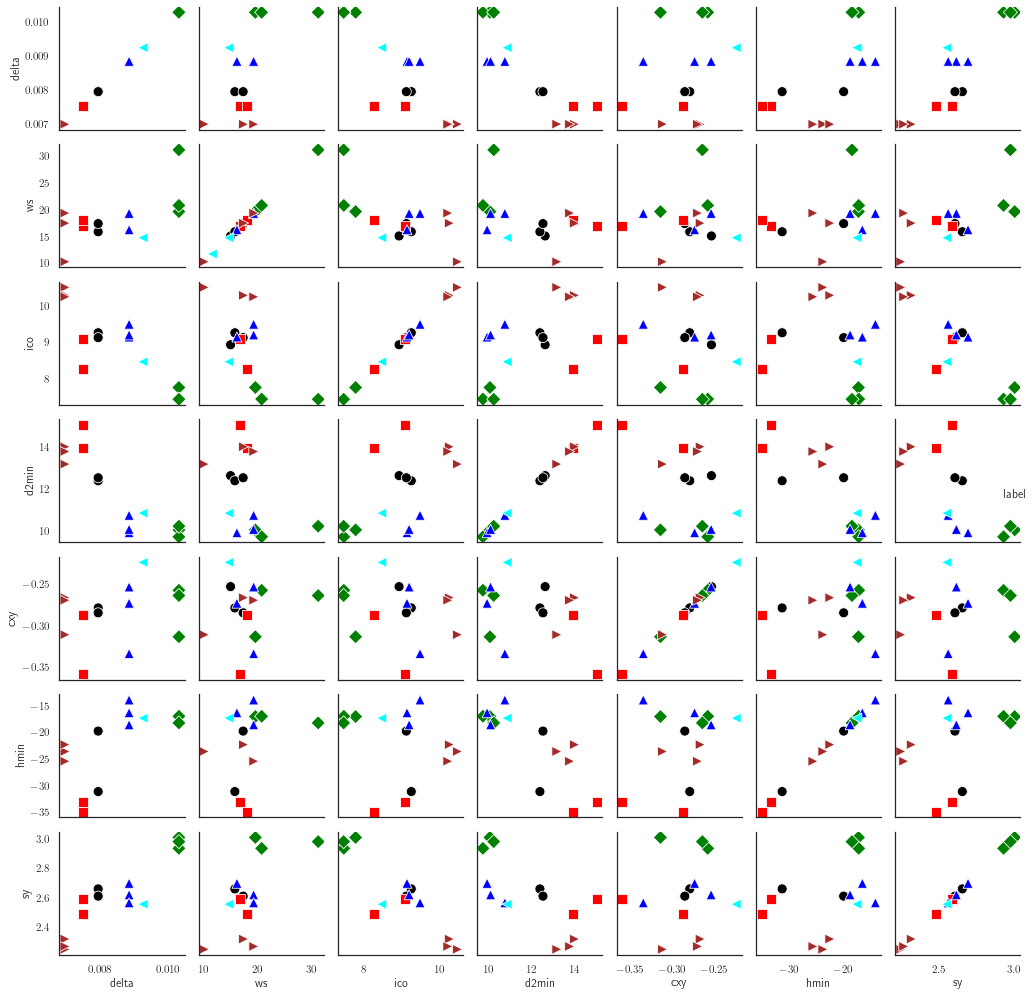

In [120]:
# import seaborn as sns
# #
# sns.set_theme(style="ticks")
# sns.set(font_scale=1.0, rc={'text.usetex' : True})
# sns.set_style("white")

# #
# markers=['o','s','D','^','<','>']
# colors = ['black','red','green','blue','cyan','brown']
# #
# g = sns.pairplot(df, 
#              vars=['delta','ws','ico','d2min','cxy','hmin','sy'],
#              hue="label",
#              diag_kind=None,
#              markers=markers,
#              palette=colors,
#              size = 2,
# #             corner = True,
#              plot_kws={'s':100.0,'legend' : False},
            
#             )
# #fig.tick_params(labelsize=5)
# g.fig.tight_layout()
# plt.show()

# Machine learning

* NeighList = True #--- build neighbor list 
* DminAnalysis = True #--- d2min as labels
* VorAnl = True #--- icosahedral symmetry as labels

In [323]:
StructFuncAng = False
os.system('mkdir MlAnl')

mkdir: 

256

MlAnl: File exists


## Descriptors

In [450]:
def GetAttribute(df,rbar,sigma):
    sigma2=sigma*sigma
    rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
    #---
    tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
    tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
    return np.array(tmp_sum)


if ml:
    
    #--- structure function
    if not ReadDisc:
        df = lmpNeigh.coord_atoms_broken[itime] #--- ref. state!!

        #--- radial
    #    rbar = 1.0*rpeak #--- density around rbar
    #    x = GetAttribute(df,rbar,sigma) #--- attribute vector
        #
        rpeak = dlgr0
        sigma=0.05*rpeak
        rbars = np.arange(0.6*rpeak,cutoff,sigma) #[0.6*rpeak]
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)
#        assert structFuncRad.shape[0] == len(d2min.x), 'some atoms have no neighbors!'

        #--- angular
        if StructFuncAng:
            cutoffAng = 4.5 #--- 2nd peak
            #--- filter df: decrease cutoff distance for the anglular analysis
            df_filtrd = df[df['DIST']<cutoffAng]
            df_filtrd.reset_index(drop=True,inplace=True)
            #---
            t0=time.time()
    #         pdb.set_trace()
            angst = lp.AngularStruct(df_filtrd)
            angst.GetDistAngle()
            print('assemble triplets t=%s s'%(time.time()-t0))
            #--- set params. list
            deltas = np.arange(0.6*rpeak,cutoffAng,3.0*sigma)
            b=np.array([1.0,-1.0])
            c=np.array([0.5,1.0,2.0])
            #
            xx, yy, zz = np.meshgrid(deltas,b,c)
            plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
            print('num(ang. features)=%s'%(len(plist)))
            #
            t0=time.time()    
            structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
            print('apply parameters t=%s s'%(time.time()-t0))
            print('structFuncAng.shape=',structFuncAng.shape)


In [431]:
#ReadDisc=True;WritDisc=False

### Plot

In [451]:
if ml:
    if not ReadDisc: 
        X=np.c_[structFuncRad,structFuncAng] if StructFuncAng else np.c_[structFuncRad]
        if WritDisc:
            with open('MlAnl/features.npy','wb') as f:
                np.save( f, X )
    else:
        with open('MlAnl/features.npy','rb') as f:
            X = np.load(f)
        print('X.shape=',X.shape)
            
#    df = pd.DataFrame(X[:,0:3]) #,dtype=float)
#    display(df)
#     scatter_matrix(df, figsize=(12, 8))
#     print(df.corr())
#     plt.show()


X.shape= (50688, 34)


## response vector

In [452]:
if ml:
    #--- voronoi data
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
#    icoFilter = GetFullIcosahedra( vor )
    #--- d2min
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') ) #--- modulus analysis!!!
    
    
    y = {
            '0':np.c_[np.log10(d2min.d2min) >= 0.0],#mu_divide],
#            '1':np.c_[icoFilter]
        }['0']


## visualize ico

In [311]:
# center_row = np.arange(len(y_true))[~np.all([y_true.flatten(), y_pred.flatten()],axis=0)][4]
# center_id = int(lmpData.coord_atoms_broken[itime].iloc[center_row]['id'])
# print('center_id=',center_id)
# print('is Ico=',y_true[center_row])
# filtr=lmpNeigh.coord_atoms_broken[itime]['id']==center_id
# neigh_id = [center_id]+list(lmpNeigh.coord_atoms_broken[itime][filtr]['J'].astype(int))

# xyz = np.c_[FilterDataFrame(lmpData.coord_atoms_broken[itime], key='id', val=neigh_id)[['x','y','z']]]
# xyz -= xyz[0]
# PrintOvito( pd.DataFrame(np.c_[xyz],columns=['x','y','z']), 
#              open( 'ico.xyz','w'), 
#              footer = 'ITIME=%s'%itime,
#              attr_list=['x','y','z'] )

center_id= 6
is Ico= [False]


In [98]:
# rpeak = dlgr0 
# sigma=0.05*rpeak
# rbars = np.arange(0.6*rpeak,cutoff,sigma)
# PltErr(rbars,X[0,0:len(rbars)],
#        yerr=None,
#        xstr=r'$R_s$',
#        ystr=r'$G^1_i$',
#        title='G1i.png',
#       )

## dimensionality reduction

In [462]:
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def DimReduction(X):
    #--- data
#    


    #--- pipeline
    DimReduc = make_pipeline( 
                              StandardScaler(),
                              TSNE(n_components=3,random_state=0),
#                              PCA(n_components=3, random_state=0),
        
                            )
    DimReduc.fit(X)
    X_embedded = DimReduc.fit_transform(X)
    return X_embedded






if ml:
    pass
    #--- 
    X_embedded = DimReduction(X)

#print(DimReduc.named_steps['tsne'].explained_variance_ratio_)
            


### Plot

In [463]:
if ml:
    pass
#     # plt.scatter(X_train[:,0],X_train[:,1],s=10,c=y_train)
#     # plt.show()
#     plt.scatter(X_embedded[:,0],X_embedded[:,1],s=10,c=y_train)
#     plt.show()

    PrintOvito( pd.DataFrame(np.c_[X_embedded,y],columns=['x','y','z','type']), 
                 open( 'MlAnl/sne_ovito.xyz','w'), 
                 footer = 'ITIME=%s'%itime,
                 attr_list=['x','y','z','type'] )

## classification

In [456]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

if ml:
#     regr = make_pipeline( 
#                           StandardScaler(),
#                           KNeighborsClassifier(n_neighbors=10),
#                         )
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#     #--- fit
#     regr.fit(X_train, y_train)
#     #--- print
#     print('pipeline:',regr.named_steps)
#     for key in ['kneighborsclassifier']:
# #        if 1:
#         try:
#             #--- mse
#             y_true = y_test.flatten()
#             y_pred = regr.named_steps[key].predict(X_test)
#             mse = mean_squared_error(y_true*1, y_pred*1)
#             #--- print
# #            print(key,':','coeffs=',regr.named_steps[key].coef_,'mse=',mse)
#             print(key,':','mse=',mse)
#         except:
#             traceback.print_exc()
#             continue

    #-----------------------
    #--- train and validate
    #-----------------------
    t0 = time.time()
    param_grid = {'n_neighbors':np.logspace(0,10,7,base=2).astype(int)} #np.arange(1,100,4)} #
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_log_error')
    clf.fit(X,y)
    print('training elapsed time:%ss'%(time.time()-t0))
    print('mean_test_score=',-clf.cv_results_['mean_test_score'])
    print('n_neighbors=%s'%(clf.best_estimator_.n_neighbors))

training elapsed time:59.46375393867493s
mean_test_score= [0.14418945]
n_neighbors=1


### Validation

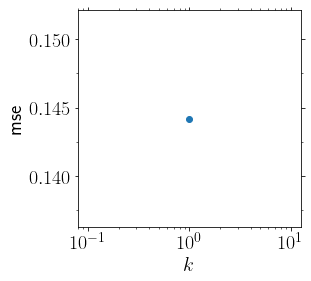

<AxesSubplot:xlabel='$k$', ylabel='mse'>

In [457]:
#-----------------------
#--- validation curve
#-----------------------
PltErr(clf.param_grid['n_neighbors'],-clf.cv_results_['mean_test_score'],
       attrs={'fmt':'-o'},
       xstr = '$k$',
       ystr = 'mse',
       xscale='log',
       title='MlAnl/validation_curve.png'
      )


### confusion matrix

In [458]:
y_pred = clf.best_estimator_.predict(X)
y_true = y

confusion_matrix(y_true, y_pred,
                 labels=[True, False]
                )

array([[10272,     0],
       [    0, 40416]])

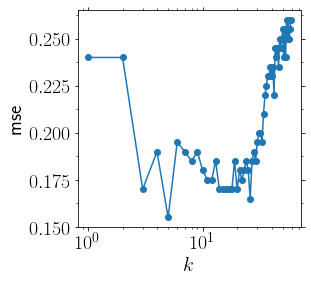

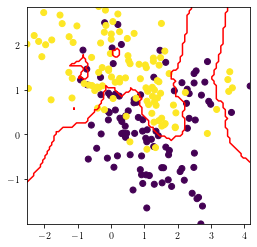

In [133]:
# import rdata

# #---------------
# #--- test case
# #---------------

# #---------------
# #--- parse data
# #---------------
# parsed = rdata.parser.parse_file('/Users/Home/Downloads/ESL.mixture.rda')
# converted = rdata.conversion.convert(parsed)
# #converted['ESL.mixture'].keys()
# #
# X=converted['ESL.mixture']['x']
# y=converted['ESL.mixture']['y']

# #-----------------------
# #--- train and validate
# #-----------------------
# param_grid = {'n_neighbors':np.arange(1,60)}
# knn = KNeighborsClassifier()
# clf = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_error')#, cv=5)
# clf.fit(X,y)

# #-----------------------
# #--- validation curve
# #-----------------------
# PltErr(clf.param_grid['n_neighbors'],-clf.cv_results_['mean_test_score'],
#        attrs={'fmt':'-o'},
#        xstr = '$k$',
#        ystr = 'mse',
#        xscale='log',
#       )


# # knn = make_pipeline( 
# #                       StandardScaler(),
# #                       KNeighborsClassifier(n_neighbors=20),
# #                     )
# # knn.fit(X, y)

# #----------------------
# #--- plot best estimate
# #----------------------
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.scatter(X[:,0],X[:,1],c=y)
    
# PlotNonLinearDecisionBoundary( ax, X, clf.best_estimator_, 100  )
# plt.show()


## icosahedral sym

rm: ico.xyz: No such file or directory


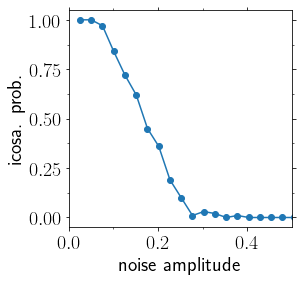

<AxesSubplot:xlabel='noise amplitude', ylabel='icosa. prob.'>

In [400]:
import numpy as np                      
from scipy.spatial.transform import Rotation as R

def vertex(x, y, z): 
    """ Return vertex coordinates fixed to the unit sphere """ 
    length = np.sqrt(x**2 + y**2 + z**2) 
    return [i / length for i in (x,y,z)] 

def middle_point(verts,middle_point_cache,point_1, point_2): 
    """ Find a middle point and project to the unit sphere """ 
    # We check if we have already cut this edge first 
    # to avoid duplicated verts 
    smaller_index = min(point_1, point_2) 
    greater_index = max(point_1, point_2) 
    key = '{0}-{1}'.format(smaller_index, greater_index) 
    if key in middle_point_cache: return middle_point_cache[key] 
    # If it's not in cache, then we can cut it 
    vert_1 = verts[point_1] 
    vert_2 = verts[point_2] 
    middle = [sum(i)/2 for i in zip(vert_1, vert_2)] 
    verts.append(vertex(*middle)) 
    index = len(verts) - 1 
    middle_point_cache[key] = index 
    return index

def icosphere(subdiv):
    # verts for icosahedron
    r = (1.0 + np.sqrt(5.0)) / 2.0;
    verts = np.array([[-1.0, r, 0.0],[ 1.0, r, 0.0],[-1.0, -r, 0.0],
                      [1.0, -r, 0.0],[0.0, -1.0, r],[0.0, 1.0, r],
                      [0.0, -1.0, -r],[0.0, 1.0, -r],[r, 0.0, -1.0],
                      [r, 0.0, 1.0],[ -r, 0.0, -1.0],[-r, 0.0, 1.0]]);
    # rescale the size to radius of 0.5
    verts /= np.linalg.norm(verts[0])
    # adjust the orientation
    r = R.from_quat([[0.19322862,-0.68019314,-0.19322862,0.68019314]])
    verts = r.apply(verts)
    verts = list(verts)

    faces = [[0, 11, 5],[0, 5, 1],[0, 1, 7],[0, 7, 10],
             [0, 10, 11],[1, 5, 9],[5, 11, 4],[11, 10, 2],
             [10, 7, 6],[7, 1, 8],[3, 9, 4],[3, 4, 2],
             [3, 2, 6],[3, 6, 8],[3, 8, 9],[5, 4, 9],
             [2, 4, 11],[6, 2, 10],[8, 6, 7],[9, 8, 1],];
    
    for i in range(subdiv):
        middle_point_cache = {}
        faces_subdiv = []
        for tri in faces: 
            v1  = middle_point(verts,middle_point_cache,tri[0], tri[1])
            v2  = middle_point(verts,middle_point_cache,tri[1], tri[2])
            v3  = middle_point(verts,middle_point_cache,tri[2], tri[0])
            faces_subdiv.append([tri[0], v1, v3]) 
            faces_subdiv.append([tri[1], v2, v1]) 
            faces_subdiv.append([tri[2], v3, v2]) 
            faces_subdiv.append([v1, v2, v3]) 
        faces = faces_subdiv
                
    return np.array(verts)

def IsIco(std=0,Plot=True, Print=True):
    #--- icohahedral structure
    xyz = icosphere(0) * dlgr0
    #--- perturb
    xyz += np.random.normal(scale=std,size=len(tmp)*3).reshape((len(tmp),3))
    xyz = np.concatenate([np.array([[0,0,0]]),xyz])
    #--- print 
    if Print:
        PrintOvito( pd.DataFrame(np.c_[xyz],columns=['x','y','z']), 
                     open( 'ico.xyz','a'), 
                     footer = 'ITIME=%s'%itime,
                     attr_list=['x','y','z'] )
    #--- fake neighbor list
    pairs = np.array(list(zip(np.ones(12,dtype=int),np.arange(2,14))))
    dist = np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
    nlist = pd.DataFrame(np.c_[pairs[:,0],np.ones(12),pairs[:,1],np.ones(12),dist[1:],xyz[1:]],
                         columns=['id','type','J','Jtype','DIST','DX','DY', 'DZ'])
    #--- descriptor
    structFuncRadTrivial = np.array(list(map(lambda x:GetAttribute(nlist,x,sigma),rbars))).T
    #--- Plot
    if Plot:
        PltErr(rbars,structFuncRadTrivial[0])
    #--- predict
    return clf.best_estimator_.predict(structFuncRadTrivial)[0]


def Wrapper(std,nsamp):
    isico = list(map(lambda x:IsIco(std=std,Plot=False,Print=False),range(nsamp)))
    return 1.0*np.sum(isico)/nsamp

std = np.linspace(0.01*dlgr0,0.2*dlgr0,20) #--- perturb with a Gaussian noise
prob = list(map(lambda x:Wrapper(x,100),std))

PltErr(std,prob,
      ystr='icosa. prob.',xstr='noise amplitude',
      title = 'MlAnl/ico.png',
      xlim=(0.0,0.5),
      )

In [408]:
os.system('rm ico.xyz')
nsamp=1
list(map(lambda x:IsIco(std=0.4,Plot=False,Print=True),range(nsamp)))

[False]